In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import missingno as msno

### **Initial data gathering**

In [3]:
db_path ='viewer_interactions.db'

In [4]:
conn = sqlite3.connect(db_path)
cursor = conn.cursor()


### **Inspecting tables in our data**:

Tables' names:

In [5]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("\nTables in database:")
for table in tables:
    print(f"  - {table[0]}")


Tables in database:
  - viewer_ratings
  - movies
  - user_statistics
  - movie_statistics
  - data_dictionary


Clear look into the table contents:

In [6]:
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
table_columns = {}

for table in tables['name']:
    cols = pd.read_sql_query(f"PRAGMA table_info({table});", conn)

    table_columns[table] = cols['name'].tolist()

    print(f"\n Table: '{table}'  —  {len(cols)} columns")
    print(cols[['name', 'type']])
    print("-" * 60)




 Table: 'viewer_ratings'  —  5 columns
             name     type
0        movie_id  INTEGER
1     customer_id  INTEGER
2          rating     REAL
3            date     TEXT
4  anomalous_date  INTEGER
------------------------------------------------------------

 Table: 'movies'  —  3 columns
              name     type
0         movie_id  INTEGER
1  year_of_release     REAL
2            title     TEXT
------------------------------------------------------------

 Table: 'user_statistics'  —  10 columns
                name     type
0        customer_id  INTEGER
1      total_ratings     REAL
2         avg_rating     REAL
3         std_rating     REAL
4         min_rating     REAL
5         max_rating     REAL
6      unique_movies     REAL
7  first_rating_date     TEXT
8   last_rating_date     TEXT
9      activity_days     REAL
------------------------------------------------------------

 Table: 'movie_statistics'  —  11 columns
                 name     type
0            movie_id  IN

**Summary of the database:**

In [7]:
tables_list = tables['name'].tolist()
summary_data = []

for table in tables_list:
    cols_df = pd.read_sql_query(f'PRAGMA table_info("{table}");', conn)
    num_cols = len(cols_df)

    row_count = pd.read_sql_query(f'SELECT COUNT(*) AS count FROM "{table}";',conn).iloc[0, 0]

    summary_data.append({
        'Table': table,
        'Rows': row_count,
        'Columns': num_cols
    })

summary_df = pd.DataFrame(summary_data)
display(summary_df)


Table     Rows  Columns
0    viewer_ratings  4025000        5
1            movies    18008        3
2   user_statistics   438780       10
3  movie_statistics    16015       11
4   data_dictionary       31        4

### **Creating data frames for each table and quickly inspecting them**

We have more cleaning on each table, if, for some reason, we decided to use them separately.

At the end, after merge_3, we clean the initial_df once more.

#### Viewer ratings:

In [8]:
df_viewer_ratings = pd.read_sql_query("SELECT * FROM viewer_ratings", conn)
df_viewer_ratings.head(5)


movie_id  customer_id  rating        date  anomalous_date
0        17      1481737     3.0  2005-10-09             NaN
1      9236      1448424     5.0  2005-11-15             NaN
2      4640      2308980     NaN  2005-08-06             NaN
3      9330       674346     3.0  2005-04-29             NaN
4      4570      1304045     4.0  2005-09-19             NaN

Quick information about the data:

In [9]:
print(f'Data shape: {df_viewer_ratings.shape}')
print(f'Information about the data:')
df_viewer_ratings.info()

Data shape: (4025000, 5)
Information about the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4025000 entries, 0 to 4024999
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   movie_id        int64  
 1   customer_id     int64  
 2   rating          float64
 3   date            object 
 4   anomalous_date  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 153.5+ MB


Cheking for duplicates:

In [10]:
duplicates = df_viewer_ratings[df_viewer_ratings.duplicated(subset=['customer_id','movie_id'], keep=False)]
print("Duplicate movie and customer id's in viewer ratings:")
print(duplicates.sort_values('customer_id'))

Duplicate movie and customer id's in viewer ratings:
         movie_id  customer_id  rating        date  anomalous_date
2001682      4577      1338115     5.0  2005-03-24             NaN
3252014      4577      1338115     5.0  2004-11-03             NaN
877686       4545      1754814     5.0  2005-03-29             NaN
1042261      4545      1754814     5.0  2003-07-02             NaN


 Keeping only the most recent rating from the customer, who rated a certain movie twice:

In [11]:
# Droping duplicates based on customer_id and movie_id and keeping only the most recent rating:
df_viewer_ratings.sort_values(by='date', inplace=True)
df_viewer_ratings.drop_duplicates(subset=['customer_id', 'movie_id'], keep='last', inplace=True)

# Verifying that no duplicates remain:
duplicates = df_viewer_ratings[df_viewer_ratings.duplicated(subset=['customer_id', 'movie_id'], keep=False)]

print("Remaining duplicates:")
print(duplicates.sort_values('customer_id'))


Remaining duplicates:
Empty DataFrame
Columns: [movie_id, customer_id, rating, date, anomalous_date]
Index: []


In [12]:
df_viewer_ratings.shape

(4024998, 5)

**Two rows were deleted.*

Inspecting the anomalous column:

In [13]:
print(f' Anomolous row count in the data: {df_viewer_ratings[df_viewer_ratings['anomalous_date'].notna()].shape[0]}')
print(f' Percentage of anomalous date rows to the whole table row count: {df_viewer_ratings[df_viewer_ratings['anomalous_date'].notna()].shape[0]/df_viewer_ratings.shape[0]}')

 Anomolous row count in the data: 1209
 Percentage of anomalous date rows to the whole table row count: 0.0003003728200610286


*It's ~ 0.03%* . So the easiest thing is just to drop these rows. (These rows indicate that the rarting date and the film release date do not logically align).

In [14]:
#Dropping the anomalous rows and the column indicating that:
df_viewer_ratings = df_viewer_ratings[df_viewer_ratings['anomalous_date'] != 1]
df_viewer_ratings.drop('anomalous_date', axis=1, inplace=True)
df_viewer_ratings.head(5)

movie_id  customer_id  rating        date
2423324     20121      2334207     4.0  1998-10-01
1192136     19129       765000     4.0  1998-10-01
3064550      1238      2203318     3.0  1998-10-01
2038715     21513      1408946     1.0  1998-10-01
1742867     12267      2544427     3.0  1998-10-01

Quick informative information about the data:

In [15]:
#Missing values:
print('Null values in the data:')
print(df_viewer_ratings.isna().sum())
#New data shape:
print(f"\nShape of the data: {df_viewer_ratings.shape}")
#Quick statistics:
print("\nQuick statistics:")
print(df_viewer_ratings.describe())

Null values in the data:
movie_id            0
customer_id         0
rating         402394
date                0
dtype: int64

Shape of the data: (4023789, 4)

Quick statistics:
           movie_id   customer_id        rating
count  4.023789e+06  4.023789e+06  3.621395e+06
mean   6.908000e+03  1.321704e+06  3.608855e+00
std    5.031371e+03  7.645441e+05  1.078033e+00
min    1.000000e+00  6.000000e+00  0.000000e+00
25%    4.503000e+03  6.599830e+05  3.000000e+00
50%    9.217000e+03  1.317589e+06  4.000000e+00
75%    1.337500e+04  1.983817e+06  4.000000e+00
max    2.500000e+04  2.649429e+06  6.000000e+00


There are some deviations:
- max rating from customer 6 (should be from 1 to 5)
- min rating from customer 0 (should be from 1 to 5)

Checking invalid data:

In [16]:
invalid_ratings = df_viewer_ratings[~df_viewer_ratings['rating'].isin([1, 2, 3, 4, 5]) & df_viewer_ratings['rating'].notna()]
print("Invalid ratings found:")
print(invalid_ratings)

Invalid ratings found:
         movie_id  customer_id  rating        date
2832205     22292      2300623     6.0  1998-10-04
1572737     20472      1874098     6.0  1998-10-08
3452067      8473      2509557     0.0  1998-10-13
769091      15923      1159818     6.0  1998-10-27
1887907     21797       552714     0.0  1998-11-04
...           ...          ...     ...         ...
1777930     11604       553285     6.0  2005-12-21
871100      22649      1921953     0.0  2005-12-21
1069821     13799      1896587     0.0  2005-12-30
1023962      1894      1196481     0.0  2005-12-30
664373      16790       246433     0.0  2005-12-30

[761 rows x 4 columns]


Correcting deviations:


In [17]:
# Replacing ratings that are more than 5 with 5 and less than 1 with 1
df_viewer_ratings.loc[df_viewer_ratings['rating'] > 5, 'rating'] = 5
df_viewer_ratings.loc[df_viewer_ratings['rating'] < 1, 'rating'] = 1

df_viewer_ratings['rating'].unique()

array([ 4.,  3.,  1., nan,  5.,  2.])

Fixed.

Let's move on.

#### Movies:

In [18]:
df_movies= pd.read_sql_query("SELECT * FROM movies", conn)
df_movies.head(5)

movie_id  year_of_release                         title
0         1           2003.0               Dinosaur Planet
1         2           2004.0    Isle of Man TT 2004 Review
2         3           1997.0                     Character
3         4           1994.0  Paula Abdul's Get Up & Dance
4         5           2004.0      The Rise and Fall of ECW

Quick information about the data:

In [19]:
print(f'Data shape: {df_movies.shape}')
print(f'Information about the data:')
df_movies.info()

Data shape: (18008, 3)
Information about the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18008 entries, 0 to 18007
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         18008 non-null  int64  
 1   year_of_release  18001 non-null  float64
 2   title            18008 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 422.2+ KB


We can see that we have 7 rows with missing year_of_release (will deal later with this, if needed):

In [20]:
odd_row = df_movies[df_movies['year_of_release'].isna()]
print(odd_row)


       movie_id  year_of_release                                        title
4387       4388              NaN      Ancient Civilizations: Rome and Pompeii
4793       4794              NaN  Ancient Civilizations: Land of the Pharaohs
7240       7241              NaN     Ancient Civilizations: Athens and Greece
10781     10782              NaN                       Roti Kapada Aur Makaan
15917     15918              NaN                      Hote Hote Pyaar Ho Gaya
16677     16678              NaN                              Jimmy Hollywood
17666     17667              NaN                           Eros Dance Dhamaka


Cheking for duplicates:

In [21]:
duplicates_2 = df_movies[df_movies.duplicated(subset=['movie_id'], keep=False)]
print("Duplicate movie id's in movie list:")
print(duplicates_2.sort_values('title'))

Duplicate movie id's in movie list:
       movie_id  year_of_release                 title
17787     19549           1998.0        American Night
17817     19549           1983.0  Kingdom of Detective
17998     21756           1974.0            Red Hunter
17959     21756           1987.0   Silent Freedom King


Removing the fake movies from the duplicates above:

In [22]:
df_movies = df_movies.drop(df_movies[(df_movies['title'] == 'American Night') & (df_movies['movie_id'] == 19549)].index)
df_movies = df_movies.drop(df_movies[df_movies['movie_id'] == 21756].index)

#Recheking the duplicates:
duplicates_2 = df_movies[df_movies.duplicated(subset=['movie_id'], keep=False)]
print("Duplicated movie id's in movie list:")
print(duplicates_2.sort_values('title'))

Duplicated movie id's in movie list:
Empty DataFrame
Columns: [movie_id, year_of_release, title]
Index: []


Good, no duplicated movie id's.


#### User statistics:

In [23]:
df_user_statistics = pd.read_sql_query("SELECT * FROM user_statistics", conn)
df_user_statistics.head(5)

customer_id  total_ratings  avg_rating  std_rating  min_rating  max_rating  \
0      1965326            8.0    3.250000    0.886405         2.0         5.0   
1       506434            1.0    4.000000         NaN         4.0         4.0   
2      1365167            3.0    4.666667    0.577350         4.0         5.0   
3       396632            2.0         NaN    0.000000         4.0         4.0   
4       260614            3.0    4.333333    0.577350         4.0         5.0   

   unique_movies first_rating_date last_rating_date  activity_days  
0            8.0        2004-08-11       2005-06-06          299.0  
1            1.0        2005-08-02       2005-08-02            0.0  
2            3.0        2004-11-16       2005-01-19           64.0  
3            2.0        2004-07-07       2004-07-07            0.0  
4            3.0        2004-03-02       2004-10-13            NaN

Quick information about the data:

In [24]:
# Data shape:
print(f"Data shape: {df_user_statistics.shape}")

# Quick information on the columns:
print("\nInformation about the data:")
df_user_statistics.info()

# Missing values:
print("\nNaN count in each column:")
print(df_user_statistics.isna().sum())


Data shape: (438780, 10)

Information about the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438780 entries, 0 to 438779
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   customer_id        438780 non-null  int64  
 1   total_ratings      416841 non-null  float64
 2   avg_rating         416841 non-null  float64
 3   std_rating         332528 non-null  float64
 4   min_rating         416841 non-null  float64
 5   max_rating         416841 non-null  float64
 6   unique_movies      416841 non-null  float64
 7   first_rating_date  438780 non-null  object 
 8   last_rating_date   438780 non-null  object 
 9   activity_days      416841 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 33.5+ MB

NaN count in each column:
customer_id               0
total_ratings         21939
avg_rating            21939
std_rating           106252
min_rating            21939
max_rating       

Cheking for duplicates:

In [25]:
duplicates_3 = df_user_statistics[df_user_statistics.duplicated(subset='customer_id', keep=False)]
print("Duplicated customers:")
print(duplicates_3.sort_values('customer_id'))

Duplicated customers:
Empty DataFrame
Columns: [customer_id, total_ratings, avg_rating, std_rating, min_rating, max_rating, unique_movies, first_rating_date, last_rating_date, activity_days]
Index: []


No duplicates, good.

We can recalculate 'activity_days' ourselves using 'first_rating_date' and 'last_rating_date' columns.

Afterwards we'll check whether our calculations match with the ones in primary 'activity_days' column.

If so, we'll keep the new(recalculated) column to have 0 missing values.

In [26]:
df_user_statistics['first_rating_date'] = pd.to_datetime(df_user_statistics['first_rating_date'])
df_user_statistics['last_rating_date'] = pd.to_datetime(df_user_statistics['last_rating_date'])

# Difference in days:
df_user_statistics['activity_days_new'] = (df_user_statistics['last_rating_date'] - df_user_statistics['first_rating_date']).dt.days

df_user_statistics.head(3)

customer_id  total_ratings  avg_rating  std_rating  min_rating  max_rating  \
0      1965326            8.0    3.250000    0.886405         2.0         5.0   
1       506434            1.0    4.000000         NaN         4.0         4.0   
2      1365167            3.0    4.666667    0.577350         4.0         5.0   

   unique_movies first_rating_date last_rating_date  activity_days  \
0            8.0        2004-08-11       2005-06-06          299.0   
1            1.0        2005-08-02       2005-08-02            0.0   
2            3.0        2004-11-16       2005-01-19           64.0   

   activity_days_new  
0                299  
1                  0  
2                 64

Cheking consistency in activity_days and activity_days_new columns:

In [27]:
print(" Checking Consistency Between 'activity_days' and 'activity_days_new' \n")

# 1. Finding rows where both columns match:
duplicates_activity = df_user_statistics['activity_days'] == df_user_statistics['activity_days_new']
duplicate_count = df_user_statistics[duplicates_activity].shape[0]

print(f"1. Rows where 'activity_days' = 'activity_days_new': {duplicate_count}")

# 2. Comparing duplicate count with total row count:
total_rows = df_user_statistics.shape[0]
difference = total_rows - duplicate_count

print(f"2. Difference (rows that do not match): {difference}")

# 3. Checking for missing values in the new column:
missing_new = df_user_statistics['activity_days_new'].isna().sum()
print(f"3. Missing values in 'activity_days_new': {missing_new}")

# 4. Missing values in the old column:
missing_old= df_user_statistics['activity_days'].isna().sum()
print(f"4. Missing vlaues in 'activity_days': {missing_old}")



 Checking Consistency Between 'activity_days' and 'activity_days_new' 

1. Rows where 'activity_days' = 'activity_days_new': 416635
2. Difference (rows that do not match): 22145
3. Missing values in 'activity_days_new': 0
4. Missing vlaues in 'activity_days': 21939


Since the numbers don't match, checking mismatched rows:

In [28]:
# Identifying mismatches excluding rows where the old value is missing:
mismatch = df_user_statistics[(df_user_statistics['activity_days'] != df_user_statistics['activity_days_new']) & df_user_statistics['activity_days'].notna()]

print(" Example of mismatched rows:")
print(mismatch.head(10))

print(f"\n Total mismatched row count (excluding NaNs): {mismatch.shape[0]}")

 Example of mismatched rows:
       customer_id  total_ratings  avg_rating  std_rating  min_rating  \
386        2872372          472.0        3.75        1.75         1.0   
1797       2893373          475.0        2.99        0.69         3.0   
2706       2729466          153.0        2.96        1.24         3.0   
4208       2722333           18.0        3.21        1.05         NaN   
6970       2978057          352.0        3.39        1.41         2.0   
11180      2804103           51.0        2.13        0.96         3.0   
16459      2791714          443.0        3.40        1.72         3.0   
20994      2938395          225.0        4.20        1.65         1.0   
22780      2802965          271.0        3.11        1.10         2.0   
25208      2970434          414.0        3.79        0.81         2.0   

       max_rating  unique_movies first_rating_date last_rating_date  \
386           4.0          143.0        2001-11-27       2004-10-29   
1797          5.0        

We can see that those 206 rows that do not match probably have a wrong initial activity_days calculation, therefore we can exclude them from our initial investigation and conclude that activity_days_new contains clean, non-missing data for the customer activity period.

In our future work we'll be using the newly calculated column and we'll drop the old one.

Also, we'll update activity_days_new column so that it would have a 1 (instead of 0), if a person was active for one day.

In [29]:
#Dropping the old column:
df_user_statistics.drop('activity_days', axis=1, inplace=True)

#Updating activity_days_new column so that it would have a 1 (instead of 0), if a person was active for one day.
df_user_statistics['activity_days_new'] = df_user_statistics['activity_days_new'] + 1

df_user_statistics.head(5)

customer_id  total_ratings  avg_rating  std_rating  min_rating  max_rating  \
0      1965326            8.0    3.250000    0.886405         2.0         5.0   
1       506434            1.0    4.000000         NaN         4.0         4.0   
2      1365167            3.0    4.666667    0.577350         4.0         5.0   
3       396632            2.0         NaN    0.000000         4.0         4.0   
4       260614            3.0    4.333333    0.577350         4.0         5.0   

   unique_movies first_rating_date last_rating_date  activity_days_new  
0            8.0        2004-08-11       2005-06-06                300  
1            1.0        2005-08-02       2005-08-02                  1  
2            3.0        2004-11-16       2005-01-19                 65  
3            2.0        2004-07-07       2004-07-07                  1  
4            3.0        2004-03-02       2004-10-13                226

Let's look into the mssing values now.

In [30]:
print("NaN count in each column:")
df_user_statistics.isna().sum()

NaN count in each column:


customer_id               0
total_ratings         21939
avg_rating            21939
std_rating           106252
min_rating            21939
max_rating            21939
unique_movies         21939
first_rating_date         0
last_rating_date          0
activity_days_new         0
dtype: int64

Let's try to work on the missing values.

One way to do this is to use the dataframe df_viewer_ratings and recalculate all the *missing* metrics ourselves:

In [31]:
#Total consumer ratings:
customer_totals = df_viewer_ratings.groupby('customer_id')['rating'].count()
df_user_statistics['total_ratings'] = df_user_statistics['total_ratings'].fillna(df_user_statistics['customer_id'].map(customer_totals))

#Total unique movies:
customer_movies = df_viewer_ratings.groupby('customer_id')['movie_id'].nunique()
df_user_statistics['unique_movies'] = df_user_statistics['unique_movies'].fillna(df_user_statistics['customer_id'].map(customer_movies))

#Avg customer rating:
customer_means = df_viewer_ratings.groupby('customer_id')['rating'].mean()
df_user_statistics['avg_rating'] = df_user_statistics['avg_rating'].fillna(df_user_statistics['customer_id'].map(customer_means))

#Std customer rating:
customer_std = df_viewer_ratings.groupby('customer_id')['rating'].std()
df_user_statistics['std_rating'] = df_user_statistics['std_rating'].fillna(df_user_statistics['customer_id'].map(customer_std))

#Min customer rating:
customer_min = df_viewer_ratings.groupby('customer_id')['rating'].min()
df_user_statistics['min_rating'] = df_user_statistics['min_rating'].fillna(df_user_statistics['customer_id'].map(customer_min))

#Max customer rating:
customer_max = df_viewer_ratings.groupby('customer_id')['rating'].max()
df_user_statistics['max_rating'] = df_user_statistics['max_rating'].fillna(df_user_statistics['customer_id'].map(customer_max))

# Min customer rating date
customer_first_date = df_viewer_ratings.groupby('customer_id')['date'].min()
df_user_statistics['first_rating_date'] = df_user_statistics['first_rating_date'].fillna(df_user_statistics['customer_id'].map(customer_first_date))

# Max customer rating date
customer_last_date = df_viewer_ratings.groupby('customer_id')['date'].max()
df_user_statistics['last_rating_date'] = df_user_statistics['last_rating_date'].fillna(df_user_statistics['customer_id'].map(customer_last_date))

print("Missing values left in each column:")
df_user_statistics.isna().sum()

Missing values left in each column:


customer_id              0
total_ratings           58
avg_rating             565
std_rating           89387
min_rating             536
max_rating             530
unique_movies           65
first_rating_date        0
last_rating_date         0
activity_days_new        0
dtype: int64

Much better, but we still have missing values.

Let's try to investigate each column seperately and see what else can we do about them.

Total_ratings and unique_movies columns should have the same values as in data dictionary they mean the same thing (as we dealed with customers rating the same movie more than once & if we assume that the statistics period is the same as the rating one):
- 'unique_movies' - Number of unique movies rated
- 'total_ratings' - Total number of ratings given by user

Cheking how many of the rows do not match:

In [32]:
same_values = df_user_statistics['total_ratings'] == df_user_statistics['unique_movies']
print(f'Count of missmatching rows: {df_user_statistics.loc[~same_values, ['customer_id', 'total_ratings', 'unique_movies']].shape[0]}')


Count of missmatching rows: 9975


They should match, because in the main dataframe df_viewer_ratings we got rid of the duplicates.

Reasons for not matching:


*   Movie was watched, but the rating was lost (Unique movies>total ratings)
*   User is not in the core table (viewer ratings) and thus it may mean that the period for the statistics for a certain person is different.



First solution is to get rid of the users which are not in our core dataframe:

In [33]:
print("Verifying Consistency Between 'total_ratings' and 'unique_movies'\n")

# 1. Identifying matching and non-matching rows:
same_values = df_user_statistics['total_ratings'] == df_user_statistics['unique_movies']
mismatch_before = df_user_statistics.loc[~same_values, ['customer_id', 'total_ratings', 'unique_movies']]
print(f"1. Mismatching rows before filtering: {mismatch_before.shape[0]}\n")

# 2. Removing users not present in the main ratings dataframe:
df_user_statistics = df_user_statistics[df_user_statistics['customer_id'].isin(df_viewer_ratings['customer_id'])]

# 3. Recalculating the mismatches after filtering out customers:
same_values_after = df_user_statistics['total_ratings'] == df_user_statistics['unique_movies']
not_matching_df = df_user_statistics.loc[~same_values_after, ['customer_id', 'total_ratings', 'unique_movies']]
print(f"2. Mismatching rows after filtering:{not_matching_df.shape[0]}\n")

# 4. Count of deleted rows:
print(f"3. Rows getting rid of: {mismatch_before.shape[0]-not_matching_df.shape[0]}")


Verifying Consistency Between 'total_ratings' and 'unique_movies'

1. Mismatching rows before filtering: 9975

2. Mismatching rows after filtering:9665

3. Rows getting rid of: 310


In [34]:
print("Investigating Mismatches Between 'total_ratings' and 'unique_movies' further:\n")

# 1. Mismatches by total_ratings:
print("1. Example mismatching rows (sorted by total_ratings):")
print(not_matching_df.sort_values('total_ratings', ascending=False).head(5))
print("\n")

# 2. Rows where total_ratings > unique_movies
print("2. Rows where total_ratings > unique_movies:")
larger_total = not_matching_df[not_matching_df['total_ratings'] > not_matching_df['unique_movies']]
print(larger_total)
print(f"\n   Count of rows where total ratings are higher than unique movies: {larger_total.shape[0]}\n")

Investigating Mismatches Between 'total_ratings' and 'unique_movies' further:

1. Example mismatching rows (sorted by total_ratings):
        customer_id  total_ratings  unique_movies
398242       184705          174.0          197.0
30262       1612901          163.0          180.0
195873       394895          142.0          156.0
190343      2155681          136.0          148.0
348999       844028          132.0          150.0


2. Rows where total_ratings > unique_movies:
        customer_id  total_ratings  unique_movies
28148       1754814           26.0           25.0
49754       1044690            2.0            1.0
214794       901154            3.0            2.0
235217      1338115            5.0            4.0
258347      1603164            7.0            6.0
330914        29069            3.0            2.0
332975      1817134            4.0            3.0

   Count of rows where total ratings are higher than unique movies: 7



Interpretation:
- All rows except these 7 above have unique movie count higher than the total ratings, because the movie was watched but the total rating was lost (and as it is a NaN value it's not counted).
- For the few cases where total_ratings > unique_movies, we can change the total rating count with a unique movie count (as the rating was given, but it appears as missing in the df_viewer_ratings).

Inspecting specific customers with the missmatching counts:

In [35]:
print("Inspecting a couple of specific customer rating histories: \n")

# Example 1
customer_1 = 1754814
print(f"    Customer {customer_1}:")
print(df_viewer_ratings[df_viewer_ratings['customer_id'] == customer_1])
print(f"    Total rows found: {df_viewer_ratings[df_viewer_ratings['customer_id'] == customer_1].shape[0]}\n")

# Example 2
customer_2 = 1338115
print(f"    Customer {customer_2}:")
print(df_viewer_ratings[df_viewer_ratings['customer_id'] == customer_2])
print(f"    Total rows found: {df_viewer_ratings[df_viewer_ratings['customer_id'] == customer_2].shape[0]}\n")

Inspecting a couple of specific customer rating histories: 

    Customer 1754814:
         movie_id  customer_id  rating        date
158874        191      1754814     5.0  2005-03-28
3663056     13391      1754814     5.0  2005-03-28
3528059     13511      1754814     5.0  2005-03-29
2695689     13392      1754814     4.0  2005-03-29
877686       4545      1754814     5.0  2005-03-29
256587       4577      1754814     5.0  2005-03-29
2545274     13493      1754814     5.0  2005-03-29
3585349      4640      1754814     4.0  2005-04-04
3886992      4612      1754814     4.0  2005-04-04
3017476        58      1754814     5.0  2005-04-04
774572       9433      1754814     5.0  2005-04-04
2366341      4506      1754814     5.0  2005-04-04
3785426      9381      1754814     4.0  2005-04-04
3165409      9240      1754814     3.0  2005-04-04
144709       4633      1754814     4.0  2005-04-06
346470         77      1754814     NaN  2005-04-15
672864       9265      1754814     4.0  2005-05-16

- For these customers 'total_ratings' should be corrected to equal 'unique_movies'.

 - We can make an assumption that this is true for all mismatching rows above, and fix this issue accordingly.

Changing the total rating count with a unique movie count:

In [36]:
df_user_statistics['total_ratings']=df_user_statistics['unique_movies']

Dealing with other missing values:

In [37]:
df_user_statistics.isna().sum()

customer_id              0
total_ratings            0
avg_rating             499
std_rating           88357
min_rating             478
max_rating             466
unique_movies            0
first_rating_date        0
last_rating_date         0
activity_days_new        0
dtype: int64

Looking at std_rating:

In [38]:
df_user_statistics[df_user_statistics['std_rating'].isna()].head(5)

customer_id  total_ratings  avg_rating  std_rating  min_rating  \
1        506434            1.0         4.0         NaN         4.0   
14      1978899            1.0         5.0         NaN         5.0   
23      1426330            1.0         3.0         NaN         3.0   
27       371042            1.0         1.0         NaN         1.0   
28        46570            1.0         3.0         NaN         3.0   

    max_rating  unique_movies first_rating_date last_rating_date  \
1          4.0            1.0        2005-08-02       2005-08-02   
14         5.0            1.0        2005-06-21       2005-06-21   
23         3.0            1.0        2004-09-02       2004-09-02   
27         1.0            1.0        2004-04-21       2004-04-21   
28         3.0            1.0        2005-07-14       2005-07-14   

    activity_days_new  
1                   1  
14                  1  
23                  1  
27                  1  
28                  1

Most std_rating is NaN because there's only one rating and deviation cannot be 'calculated'. But for easier intepretation we can impute it with 0 (meaning no deviations).

In [39]:
rule = (df_user_statistics['unique_movies'].isin([0, 1])) & (df_user_statistics['std_rating'].isna())
df_user_statistics.loc[rule, 'std_rating'] = 0

print(f'Missing values left: \n{df_user_statistics.isna().sum()}')

Missing values left: 
customer_id            0
total_ratings          0
avg_rating           499
std_rating           593
min_rating           478
max_rating           466
unique_movies          0
first_rating_date      0
last_rating_date       0
activity_days_new      0
dtype: int64


Better.

Inspecting max rating missing values:

In [40]:
df_user_statistics[df_user_statistics['max_rating'].isna()].head()

customer_id  total_ratings  avg_rating  std_rating  min_rating  \
2991      2395876            1.0         NaN         0.0         NaN   
3124      1903613            1.0         3.0         0.0         3.0   
4251       817266            2.0         1.5         NaN         1.0   
4400      1089549            1.0         1.0         0.0         1.0   
5070      1561289            1.0         2.0         0.0         2.0   

      max_rating  unique_movies first_rating_date last_rating_date  \
2991         NaN            1.0        2005-07-18       2005-07-18   
3124         NaN            1.0        2002-06-14       2002-06-14   
4251         NaN            2.0        2005-09-29       2005-09-29   
4400         NaN            1.0        2001-08-16       2001-08-16   
5070         NaN            1.0        2002-03-13       2002-03-13   

      activity_days_new  
2991                  1  
3124                  1  
4251                  1  
4400                  1  
5070                  1

- If 'total_ratings'=1, then 'avg_rating','min_rating,'max_rating' should be equal, so we'll write the code to impute with the value, which is available.

- I round the values, as the rating can only be an integer, and if there is only 1 rating, the average also should be an integer, so if it's a float its incorrect data.

In [41]:
specific_row = df_user_statistics['total_ratings'] == 1

columns = ['avg_rating', 'min_rating', 'max_rating']

values = df_user_statistics.loc[specific_row, columns].bfill(axis=1).iloc[:, 0]

values = values.apply(lambda x: np.ceil(x) if pd.notna(x) else np.nan)

for col in columns:
    df_user_statistics.loc[specific_row, col] = values

#Missing values left:
print(f'Missing values left: \n{df_user_statistics.isna().sum()}')

Missing values left: 
customer_id            0
total_ratings          0
avg_rating            40
std_rating           593
min_rating            33
max_rating            27
unique_movies          0
first_rating_date      0
last_rating_date       0
activity_days_new      0
dtype: int64


Good fix.

We'll look into the left issing values a bit later.


Lets check if there are invalid values in some columns:

In [42]:
# In the avg_rating column, ratings are between 1 and 5, so we can assume that any value outside this range is invalid.
# Checking for invalid values in avg_rating column, the number of values less than 1 and greater than 5:
invalid_low_count = df_user_statistics[df_user_statistics['avg_rating'] < 1].shape[0]
invalid_high_count = df_user_statistics[df_user_statistics['avg_rating'] > 5].shape[0]
print(f"Number of invalid low avg_rating values (<1): {invalid_low_count}")
print(f"Number of invalid high avg_rating values (>5): {invalid_high_count}")

# In the std_rating column, given that ratings are between 1 and 5, the maximum possible standard deviation is 2.
# And since standard deviation cannot be negative, any value less than 0 is invalid.
# Checking for invalid values in std_rating column, the number of values less than 0 and greater than 2:
invalid_std_low_count = df_user_statistics[df_user_statistics['std_rating'] < 0].shape[0]
invalid_std_high_count = df_user_statistics[df_user_statistics['std_rating'] > 2].shape[0]
print(f"Number of invalid low std_rating values (<0): {invalid_std_low_count}")
print(f"Number of invalid high std_rating values (>2): {invalid_std_high_count}")

# In the min_rating and max_rating columns, ratings should also be between 1 and 5.
# Checking for invalid values in min_rating column, the number of values less than 1 and greater than 5:
invalid_min_low_count = df_user_statistics[df_user_statistics['min_rating'] < 1].shape[0]
invalid_min_high_count = df_user_statistics[df_user_statistics['min_rating'] > 5].shape[0]
print(f"Number of invalid low min_rating values (<1): {invalid_min_low_count}")
print(f"Number of invalid high min_rating values (>5): {invalid_min_high_count}")

# Checking for invalid values in max_rating column, the number of values less than 1 and greater than 5:
invalid_max_low_count = df_user_statistics[df_user_statistics['max_rating'] < 1].shape[0]
invalid_max_high_count = df_user_statistics[df_user_statistics['max_rating'] > 5].shape[0]
print(f"Number of invalid low max_rating values (<1): {invalid_max_low_count}")
print(f"Number of invalid high max_rating values (>5): {invalid_max_high_count}")


Number of invalid low avg_rating values (<1): 337
Number of invalid high avg_rating values (>5): 331
Number of invalid low std_rating values (<0): 0
Number of invalid high std_rating values (>2): 8360
Number of invalid low min_rating values (<1): 414
Number of invalid high min_rating values (>5): 330
Number of invalid low max_rating values (<1): 335
Number of invalid high max_rating values (>5): 394


Fixing those values:

In [43]:
# Replace all the rating values that are less than 1 with 1 and all the values greater than 5 with 5.
df_user_statistics.loc[df_user_statistics['avg_rating'] < 1, 'avg_rating'] = 1
df_user_statistics.loc[df_user_statistics['avg_rating'] > 5, 'avg_rating'] = 5


# Replace all the standard deviation values greater than 2 with 2.
df_user_statistics.loc[df_user_statistics['std_rating'] > 2, 'std_rating'] = 2


# Replace all the min/max values that are less than 1 with 1 and all the values greater than 5 with 5.
df_user_statistics.loc[df_user_statistics['min_rating'] < 1, 'min_rating'] = 1
df_user_statistics.loc[df_user_statistics['min_rating'] > 5, 'min_rating'] = 5
df_user_statistics.loc[df_user_statistics['max_rating'] < 1, 'max_rating'] = 1
df_user_statistics.loc[df_user_statistics['max_rating'] > 5, 'max_rating'] = 5


Converting some columns from float to integer types:

In [44]:
# Columns to convert to integer type:
cols_to_int = ['total_ratings', 'min_rating', 'max_rating', 'unique_movies', 'activity_days_new']

# Converting each column to integer type:
for col in cols_to_int:
    df_user_statistics[col] = df_user_statistics[col].astype(pd.Int64Dtype())

# Checking the types:
print(df_user_statistics.info())


<class 'pandas.core.frame.DataFrame'>
Index: 437550 entries, 0 to 438779
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   customer_id        437550 non-null  int64         
 1   total_ratings      437550 non-null  Int64         
 2   avg_rating         437510 non-null  float64       
 3   std_rating         436957 non-null  float64       
 4   min_rating         437517 non-null  Int64         
 5   max_rating         437523 non-null  Int64         
 6   unique_movies      437550 non-null  Int64         
 7   first_rating_date  437550 non-null  datetime64[ns]
 8   last_rating_date   437550 non-null  datetime64[ns]
 9   activity_days_new  437550 non-null  Int64         
dtypes: Int64(5), datetime64[ns](2), float64(2), int64(1)
memory usage: 38.8 MB
None


Final version, that we're going to be using:

In [45]:
df_user_statistics_updated=df_user_statistics.copy()

print("Example of the data:")
print(df_user_statistics_updated.head(5))
print("\n")

print(f"Shape of the data: {df_user_statistics_updated.shape}\n")

print("Missing values in each column:")
print(df_user_statistics_updated.isna().sum())



Example of the data:
   customer_id  total_ratings  avg_rating  std_rating  min_rating  max_rating  \
0      1965326              8    3.250000    0.886405           2           5   
1       506434              1    4.000000    0.000000           4           4   
2      1365167              3    4.666667    0.577350           4           5   
3       396632              2    4.000000    0.000000           4           4   
4       260614              3    4.333333    0.577350           4           5   

   unique_movies first_rating_date last_rating_date  activity_days_new  
0              8        2004-08-11       2005-06-06                300  
1              1        2005-08-02       2005-08-02                  1  
2              3        2004-11-16       2005-01-19                 65  
3              2        2004-07-07       2004-07-07                  1  
4              3        2004-03-02       2004-10-13                226  


Shape of the data: (437550, 10)

Missing values in e

Good. Let's move on.


#### Movie statistics:

In [46]:
df_movie_statistics = pd.read_sql_query("SELECT * FROM movie_statistics", conn)
df_movie_statistics.head(5)

movie_id  total_ratings  avg_rating  std_rating  min_rating  max_rating  \
0         1          548.0    3.744526    1.073389         1.0         5.0   
1         2          146.0    3.547945    1.281606         1.0         5.0   
2         3         2013.0    3.639841    0.978873         1.0         5.0   
3         4          142.0    2.739437    1.302913         1.0         5.0   
4         5         1140.0    3.919298    1.292436         1.0         5.0   

   unique_users first_rating_date last_rating_date  year_of_release  \
0         548.0        2003-07-12       2005-12-30           2003.0   
1         146.0        2004-10-16       2005-12-20           2004.0   
2        2013.0        2000-10-19       2005-12-30           1997.0   
3         142.0        2003-12-06       2005-12-27           1994.0   
4        1140.0        2004-11-02       2005-12-29           2004.0   

                          title  
0               Dinosaur Planet  
1    Isle of Man TT 2004 Review  
2                     Character  
3  Paula Abdul's Get Up & Dance  
4      The Rise and Fall of ECW

Quick information about the data:

In [47]:
print(f'Data shape: {df_movie_statistics.shape}')
print(f'Information about the data:')
df_movie_statistics.info()

Data shape: (16015, 11)
Information about the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16015 entries, 0 to 16014
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           16015 non-null  int64  
 1   total_ratings      15215 non-null  float64
 2   avg_rating         15215 non-null  float64
 3   std_rating         6847 non-null   float64
 4   min_rating         15215 non-null  float64
 5   max_rating         15215 non-null  float64
 6   unique_users       15215 non-null  float64
 7   first_rating_date  16015 non-null  object 
 8   last_rating_date   16015 non-null  object 
 9   year_of_release    11504 non-null  float64
 10  title              11508 non-null  object 
dtypes: float64(7), int64(1), object(3)
memory usage: 1.3+ MB


Immediately getting rid of statistics for the movies, which do not appear in the viewer_ratings table (our core one):

In [48]:
# 1. Initial shape
initial_shape = df_movie_statistics.shape
print(f"Initial shape of df_movie_statistics: {initial_shape}")

# 2. Filtering movies to only those in df_viewer_ratings:
df_movie_statistics = df_movie_statistics[df_movie_statistics['movie_id'].isin(df_viewer_ratings['movie_id'])]

# 3️. New shape
new_shape = df_movie_statistics.shape
print(f"Shape after filtering: {new_shape}")

# 4. Removed rows:
removed_count = initial_shape[0] - new_shape[0]
print(f"Number of movies removed: {removed_count}\n")


Initial shape of df_movie_statistics: (16015, 11)
Shape after filtering: (15583, 11)
Number of movies removed: 432



Cheking for duplicates:

In [49]:
duplicates_4 = df_movie_statistics[df_movie_statistics.duplicated(subset='movie_id', keep=False)]
print("Duplicated movies:")
print(duplicates_4.sort_values('movie_id'))

Duplicated movies:
       movie_id  total_ratings  avg_rating  std_rating  min_rating  \
12489     19549            NaN         2.0         NaN         2.0   
12490     19549            1.0         2.0         NaN         2.0   
13915     21756            NaN         5.0         0.0         5.0   
13916     21756            2.0         5.0         0.0         5.0   

       max_rating  unique_users first_rating_date last_rating_date  \
12489         2.0           1.0        2005-03-05       2005-03-05   
12490         2.0           1.0        2005-03-05       2005-03-05   
13915         5.0           2.0        1999-11-07       2001-08-02   
13916         5.0           NaN        1999-11-07       2001-08-02   

       year_of_release                 title  
12489           1998.0        American Night  
12490           1983.0  Kingdom of Detective  
13915           1987.0   Silent Freedom King  
13916           1974.0            Red Hunter  


We have a two movies with different titles but with the same id's.

They also appeared in the df_movies table, and we removed fake films, thus we'll do the same here:

In [50]:
df_movie_statistics = df_movie_statistics.drop(df_movie_statistics[(df_movie_statistics['title'] == 'American Night') & (df_movie_statistics['movie_id'] == 19549)].index)
df_movie_statistics = df_movie_statistics.drop(df_movie_statistics[df_movie_statistics['movie_id'] == 21756].index)

#Cheking if we really got rid of the duplicates:
duplicates_4 = df_movie_statistics[df_movie_statistics.duplicated(subset='movie_id', keep=False)]
print("Duplicated movies left:")
print(duplicates_4.sort_values('movie_id'))

Duplicated movies left:
Empty DataFrame
Columns: [movie_id, total_ratings, avg_rating, std_rating, min_rating, max_rating, unique_users, first_rating_date, last_rating_date, year_of_release, title]
Index: []


Good.

It's useful to create an additional column for movie rating period (taking the difference between the last day of the rating and the first one):

In [51]:
df_movie_statistics['last_rating_date']=pd.to_datetime(df_movie_statistics['last_rating_date'])
df_movie_statistics['first_rating_date']=pd.to_datetime(df_movie_statistics['first_rating_date'])

df_movie_statistics['movie_rating_period(days)'] = (df_movie_statistics['last_rating_date'] - df_movie_statistics['first_rating_date']).dt.days+1
df_movie_statistics.head(5)

movie_id  total_ratings  avg_rating  std_rating  min_rating  max_rating  \
0         1          548.0    3.744526    1.073389         1.0         5.0   
1         2          146.0    3.547945    1.281606         1.0         5.0   
2         3         2013.0    3.639841    0.978873         1.0         5.0   
3         4          142.0    2.739437    1.302913         1.0         5.0   
4         5         1140.0    3.919298    1.292436         1.0         5.0   

   unique_users first_rating_date last_rating_date  year_of_release  \
0         548.0        2003-07-12       2005-12-30           2003.0   
1         146.0        2004-10-16       2005-12-20           2004.0   
2        2013.0        2000-10-19       2005-12-30           1997.0   
3         142.0        2003-12-06       2005-12-27           1994.0   
4        1140.0        2004-11-02       2005-12-29           2004.0   

                          title  movie_rating_period(days)  
0               Dinosaur Planet                        903  
1    Isle of Man TT 2004 Review                        431  
2                     Character                       1899  
3  Paula Abdul's Get Up & Dance                        753  
4      The Rise and Fall of ECW                        423

Missing values:

In [52]:
df_movie_statistics.isna().sum()

movie_id                        0
total_ratings                 781
avg_rating                    777
std_rating                   8741
min_rating                    782
max_rating                    771
unique_users                  779
first_rating_date               0
last_rating_date                0
year_of_release              4383
title                        4380
movie_rating_period(days)       0
dtype: int64

Giving a 'Unknown' title for the movies which do not have a title:

In [53]:
df_movie_statistics['title'] = df_movie_statistics['title'].fillna('Unknown')

Recalculating numbers for *missing* values:

In [54]:
#Total movie ratings:
movie_totals = df_viewer_ratings.groupby('movie_id')['rating'].count()
df_movie_statistics['total_ratings'] = df_movie_statistics['total_ratings'].fillna(df_movie_statistics['movie_id'].map(movie_totals))

# Unique users:
movie_users = df_viewer_ratings.groupby('movie_id')['customer_id'].nunique()
df_movie_statistics['unique_users'] = df_movie_statistics['unique_users'].fillna(df_movie_statistics['movie_id'].map(movie_users))

#Avg movie ratings:
movie_means = df_viewer_ratings.groupby('movie_id')['rating'].mean()
df_movie_statistics['avg_rating'] = df_movie_statistics['avg_rating'].fillna(df_movie_statistics['movie_id'].map(movie_means))

#Std for movie ratings:
movie_std = df_viewer_ratings.groupby('movie_id')['rating'].std()
df_movie_statistics['std_rating'] = df_movie_statistics['std_rating'].fillna(df_movie_statistics['movie_id'].map(movie_std))

#Min for movie ratings:
movie_min = df_viewer_ratings.groupby('movie_id')['rating'].min()
df_movie_statistics['min_rating'] = df_movie_statistics['min_rating'].fillna(df_movie_statistics['movie_id'].map(movie_min))

#Max for movie ratings:
movie_max = df_viewer_ratings.groupby('movie_id')['rating'].max()
df_movie_statistics['max_rating'] = df_movie_statistics['max_rating'].fillna(df_movie_statistics['movie_id'].map(movie_max))

#Min movie rating date:
movie_first_date = df_viewer_ratings.groupby('movie_id')['date'].min()
df_movie_statistics['first_rating_date'] = df_movie_statistics['first_rating_date'].fillna(df_movie_statistics['movie_id'].map(movie_first_date))

# Max movie rating date:
movie_last_date = df_viewer_ratings.groupby('movie_id')['date'].max()
df_movie_statistics['last_rating_date'] = df_movie_statistics['last_rating_date'].fillna(df_movie_statistics['movie_id'].map(movie_last_date))

Getting rid of deviations between min,max and avg ratings if movie was rated only once:

In [55]:
#Giving the same value for min,max, avg if unique users=1.

specific_row = df_movie_statistics['unique_users'] == 1

columns = ['avg_rating', 'min_rating', 'max_rating']

values = df_movie_statistics.loc[specific_row, columns].bfill(axis=1).iloc[:, 0]

values = values.apply(lambda x: np.ceil(x) if pd.notna(x) else np.nan)

for col in columns:
    df_movie_statistics.loc[specific_row, col] = values


In [56]:
# If movie was not rated or rated once, we assume that there was no std. deviation (0):

rule = (df_movie_statistics['unique_users'].isin([0, 1])) & (df_movie_statistics['std_rating'].isna())
df_movie_statistics.loc[rule, 'std_rating'] = 0


In [57]:
df_movie_statistics.isna().sum()

movie_id                        0
total_ratings                   0
avg_rating                      3
std_rating                     63
min_rating                      7
max_rating                      4
unique_users                    0
first_rating_date               0
last_rating_date                0
year_of_release              4383
title                           0
movie_rating_period(days)       0
dtype: int64

We proceed with the data with missing values above for now without imputing anything else.

By the logic total rating column should match with the unique users one (excluding NaN's), but let's check once more:

In [58]:
print("Investigating mismatches between 'total_ratings' and 'unique_users' \n")

# 1. Identifying rows where total_ratings equals unique_users
duplicates_unique_ratings = df_movie_statistics['total_ratings'] == df_movie_statistics['unique_users']
matching_count = df_movie_statistics[duplicates_unique_ratings].shape[0]
print(f" 1. Rows where total_ratings = unique_users: {matching_count}")

# 2. In how many rows they do not match?
mismatch_count = df_movie_statistics.shape[0] - matching_count
print(f" 2. Rows where total_ratings != unique_users: {mismatch_count}\n")

Investigating mismatches between 'total_ratings' and 'unique_users' 

 1. Rows where total_ratings = unique_users: 15377
 2. Rows where total_ratings != unique_users: 203



There are missmatches between these columns even though they should be the same as:

'total_ratings' - Total number of ratings (the said movie) received

'unique_users' - Number of unique users who rated (the said movie)

In [59]:
# Preview of mismatched rows:
mismatched_rows = df_movie_statistics[df_movie_statistics['total_ratings'] != df_movie_statistics['unique_users']]
print('Example of mismatched rows:')
mismatched_rows.head(5)

Example of mismatched rows:


movie_id  total_ratings  avg_rating  std_rating  min_rating  max_rating  \
20        21          202.0    3.463303    1.002776         1.0         5.0   
42        43           90.0    2.611111    1.286323         1.0         5.0   
56        57         3206.0    3.678080    1.035550         1.0         5.0   
58        59          187.0    2.772947    1.066544         1.0         5.0   
81        82          107.0    3.042017    0.920677         1.0         5.0   

    unique_users first_rating_date last_rating_date  year_of_release  \
20         218.0        2003-10-28       2005-12-18           2002.0   
42         106.0        2001-06-27       2005-12-13           2000.0   
56        3563.0        2000-03-08       2005-12-30           1995.0   
58         207.0        2003-02-08       2005-12-22           2003.0   
81         119.0        2005-04-09       2005-12-28           1951.0   

                   title  movie_rating_period(days)  
20     Strange Relations                        783  
42        Silent Service                       1631  
56           Richard III                       2124  
58  Sex and the Beauties                       1049  
81           The Frogmen                        264

In [60]:
#  Count of mismatches by type:
less_than_count = df_movie_statistics[df_movie_statistics['total_ratings'] < df_movie_statistics['unique_users']].shape[0]
greater_than_count = df_movie_statistics[df_movie_statistics['total_ratings'] > df_movie_statistics['unique_users']].shape[0]
print(f'  total_ratings < unique_users: {less_than_count} rows')
print(f'  total_ratings > unique_users: {greater_than_count} rows\n')

  total_ratings < unique_users: 159 rows
  total_ratings > unique_users: 44 rows



In [61]:
# Preview of cases where total_ratings > unique_users:
print(' Examples where total_ratings > unique_users (first 3):')
df_movie_statistics[df_movie_statistics['total_ratings'] > df_movie_statistics['unique_users']].head(3)


 Examples where total_ratings > unique_users (first 3):


movie_id  total_ratings  avg_rating  std_rating  min_rating  max_rating  \
125        126         1186.0    3.201518    1.094997         1.0         5.0   
846       1243            2.0    3.000000    2.121320         3.0         3.0   
1329      1980            4.0    2.250000    2.061553         0.0         1.0   

      unique_users first_rating_date last_rating_date  year_of_release  \
125         1185.0        2004-02-26       2005-12-28           2003.0   
846            1.0        2005-11-01       2006-03-11           1998.0   
1329           3.0        2001-01-09       2004-05-06           1997.0   

                                                  title  \
125                   Vampire Effect (aka Twins Effect)   
846                           La Femme Nikita: Season 2   
1329  Alien: Resurrection: Collector's Edition: Bonu...   

      movie_rating_period(days)  
125                         672  
846                         131  
1329                       1214

In [62]:
# Inspecting one specific movie in the ratings data:
movie_id_example = 126
movie_ratings_count = df_viewer_ratings[df_viewer_ratings['movie_id'] == movie_id_example].shape[0]
print(f" Movie {movie_id_example} has {movie_ratings_count} ratings in df_viewer_ratings.\n")

 Movie 126 has 1185 ratings in df_viewer_ratings.



Probably most of these mismatches are due to the incorrect data in the first place (same logic as with the customer statistics data). Thus we can update the total ratings column by giving it the value of unique user count as it'll give the accurate number.

In [63]:
df_movie_statistics['total_ratings']=df_movie_statistics['unique_users']

Additional check for invalid data:

In [64]:
# In avg_rating column, ratings are between 1 and 5, so we can assume that any value outside this range is invalid.
# Checking for invalid values in avg_rating column, the number of values less than 1 and greater than 5:
invalid_low_count = df_movie_statistics[df_movie_statistics['avg_rating'] < 1].shape[0]
invalid_high_count = df_movie_statistics[df_movie_statistics['avg_rating'] > 5].shape[0]
print(f"Number of invalid low avg_rating values (<1): {invalid_low_count}")
print(f"Number of invalid high avg_rating values (>5): {invalid_high_count}")

# In std_rating column, given that ratings are between 1 and 5, the maximum possible standard deviation is 2.
# And since standard deviation cannot be negative, any value less than 0 is invalid.
# Checking for invalid values in std_rating column, the number of values less than 0 and greater than 2:
invalid_std_low_count = df_movie_statistics[df_movie_statistics['std_rating'] < 0].shape[0]
invalid_std_high_count = df_movie_statistics[df_movie_statistics['std_rating'] > 2].shape[0]
print(f"Number of invalid low std_rating values (<0): {invalid_std_low_count}")
print(f"Number of invalid high std_rating values (>2): {invalid_std_high_count}")

# In min_rating and max_rating columns, ratings should also be between 1 and 5.
# Checking for invalid values in min_rating column, the number of values less than 1 and greater than 5:
invalid_min_low_count = df_movie_statistics[df_movie_statistics['min_rating'] < 1].shape[0]
invalid_min_high_count = df_movie_statistics[df_movie_statistics['min_rating'] > 5].shape[0]
print(f"Number of invalid low min_rating values (<1): {invalid_min_low_count}")
print(f"Number of invalid high min_rating values (>5): {invalid_min_high_count}")

# Checking for invalid values in max_rating column, the number of values less than 1 and greater than 5:
invalid_max_low_count = df_movie_statistics[df_movie_statistics['max_rating'] < 1].shape[0]
invalid_max_high_count = df_movie_statistics[df_movie_statistics['max_rating'] > 5].shape[0]
print(f"Number of invalid low max_rating values (<1): {invalid_max_low_count}")
print(f"Number of invalid high max_rating values (>5): {invalid_max_high_count}")


Number of invalid low avg_rating values (<1): 202
Number of invalid high avg_rating values (>5): 162
Number of invalid low std_rating values (<0): 0
Number of invalid high std_rating values (>2): 1558
Number of invalid low min_rating values (<1): 411
Number of invalid high min_rating values (>5): 135
Number of invalid low max_rating values (<1): 170
Number of invalid high max_rating values (>5): 385


Fixing deviations:

In [65]:
# Replacing all the rating values that are less than 1 with 1 and all the values greater than 5 with 5.
df_movie_statistics.loc[df_movie_statistics['avg_rating'] < 1, 'avg_rating'] = 1
df_movie_statistics.loc[df_movie_statistics['avg_rating'] > 5, 'avg_rating'] = 5

# Replacing all the std values greater than 2 with 2.
df_movie_statistics.loc[df_movie_statistics['std_rating'] > 2, 'std_rating'] = 2

# Replacing all the min/max values that are less than 1 with 1 and all the values greater than 5 with 5.
df_movie_statistics.loc[df_movie_statistics['min_rating'] < 1, 'min_rating'] = 1
df_movie_statistics.loc[df_movie_statistics['min_rating'] > 5, 'min_rating'] = 5
df_movie_statistics.loc[df_movie_statistics['max_rating'] < 1, 'max_rating'] = 1
df_movie_statistics.loc[df_movie_statistics['max_rating'] > 5, 'max_rating'] = 5

Converting some columns from floats to integers:

In [66]:
# Converting columns to integer type:
cols_to_int = ['total_ratings', 'min_rating', 'max_rating', 'unique_users', 'year_of_release']
for col in cols_to_int:
    df_movie_statistics[col] = df_movie_statistics[col].astype(pd.Int64Dtype())

print(df_movie_statistics.info())

<class 'pandas.core.frame.DataFrame'>
Index: 15580 entries, 0 to 16014
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   movie_id                   15580 non-null  int64         
 1   total_ratings              15580 non-null  Int64         
 2   avg_rating                 15577 non-null  float64       
 3   std_rating                 15517 non-null  float64       
 4   min_rating                 15573 non-null  Int64         
 5   max_rating                 15576 non-null  Int64         
 6   unique_users               15580 non-null  Int64         
 7   first_rating_date          15580 non-null  datetime64[ns]
 8   last_rating_date           15580 non-null  datetime64[ns]
 9   year_of_release            11197 non-null  Int64         
 10  title                      15580 non-null  object        
 11  movie_rating_period(days)  15580 non-null  int64         
dtypes: Int64(

Final dataset that we'll use:

In [67]:
df_movie_statistics_updated=df_movie_statistics.copy()
df_movie_statistics_updated.head(5)

movie_id  total_ratings  avg_rating  std_rating  min_rating  max_rating  \
0         1            548    3.744526    1.073389           1           5   
1         2            146    3.547945    1.281606           1           5   
2         3           2013    3.639841    0.978873           1           5   
3         4            142    2.739437    1.302913           1           5   
4         5           1140    3.919298    1.292436           1           5   

   unique_users first_rating_date last_rating_date  year_of_release  \
0           548        2003-07-12       2005-12-30             2003   
1           146        2004-10-16       2005-12-20             2004   
2          2013        2000-10-19       2005-12-30             1997   
3           142        2003-12-06       2005-12-27             1994   
4          1140        2004-11-02       2005-12-29             2004   

                          title  movie_rating_period(days)  
0               Dinosaur Planet                        903  
1    Isle of Man TT 2004 Review                        431  
2                     Character                       1899  
3  Paula Abdul's Get Up & Dance                        753  
4      The Rise and Fall of ECW                        423

In [68]:
print(f'Missing values: \n{df_movie_statistics_updated.isna().sum()}')
print('Quick stats:')
df_movie_statistics_updated.describe()

Missing values: 
movie_id                        0
total_ratings                   0
avg_rating                      3
std_rating                     63
min_rating                      7
max_rating                      4
unique_users                    0
first_rating_date               0
last_rating_date                0
year_of_release              4383
title                           0
movie_rating_period(days)       0
dtype: int64
Quick stats:


movie_id  total_ratings    avg_rating    std_rating  min_rating  \
count  15580.000000        15580.0  15577.000000  15517.000000     15573.0   
mean   12496.233119     258.312709      3.000891      0.539031    2.489886   
min        1.000000            1.0      1.000000      0.000000         1.0   
25%     6180.750000            1.0      2.000000      0.000000         1.0   
50%    12482.000000            1.0      3.000000      0.000000         2.0   
75%    18824.250000            2.0      4.000000      1.153640         4.0   
max    25000.000000       173598.0      5.000000      2.000000         5.0   
std     7256.065720    3656.673765      1.267249      0.729543    1.433464   

       max_rating  unique_users              first_rating_date  \
count     15576.0       15580.0                          15580   
mean      3.49114    258.312709  2002-06-06 02:10:13.709884544   
min           1.0           1.0            1995-01-02 00:00:00   
25%           2.0           1.0            2000-08-20 00:00:00   
50%           4.0           1.0            2002-07-22 00:00:00   
75%           5.0           2.0            2004-04-28 00:00:00   
max           5.0      173598.0            2005-12-30 00:00:00   
std      1.444373   3656.673765                            NaN   

                    last_rating_date  year_of_release  \
count                          15580          11197.0   
mean   2003-09-26 14:16:25.263157760      1990.202911   
min              1998-10-01 00:00:00           1896.0   
25%              2002-06-05 00:00:00           1985.0   
50%              2004-04-08 00:00:00           1997.0   
75%              2005-05-21 00:00:00           2002.0   
max              2006-03-28 00:00:00           2005.0   
std                              NaN        16.355878   

       movie_rating_period(days)  
count               15580.000000  
mean                  478.504300  
min                     1.000000  
25%                     1.000000  
50%                     1.000000  
75%                   804.000000  
max                  4056.000000  
std                   726.723371

Good.

#### Data Dictionary:

In [69]:
data_dictionary=pd.read_sql_query("SELECT * FROM data_dictionary", conn)
data_dictionary

table_name         field_name data_type  \
0     viewer_ratings           movie_id   integer   
1     viewer_ratings        customer_id   integer   
2     viewer_ratings             rating   integer   
3     viewer_ratings               date      date   
4             movies           movie_id   integer   
5             movies    year_of_release   integer   
6             movies              title    string   
7    user_statistics        customer_id   integer   
8    user_statistics      total_ratings   integer   
9    user_statistics         avg_rating     float   
10   user_statistics         std_rating     float   
11   user_statistics         min_rating   integer   
12   user_statistics         max_rating   integer   
13   user_statistics      unique_movies   integer   
14   user_statistics  first_rating_date      date   
15   user_statistics   last_rating_date      date   
16   user_statistics      activity_days   integer   
17  movie_statistics           movie_id   integer   
18  movie_statistics              title    string   
19  movie_statistics    year_of_release   integer   
20  movie_statistics      total_ratings   integer   
21  movie_statistics         avg_rating     float   
22  movie_statistics         std_rating     float   
23  movie_statistics         min_rating   integer   
24  movie_statistics         max_rating   integer   
25  movie_statistics       unique_users   integer   
26  movie_statistics  first_rating_date      date   
27  movie_statistics   last_rating_date      date   
28         _metadata    dataset_version    string   
29         _metadata      academic_year    string   
30         _metadata       last_updated      date   

                                          description  
0   Unique movie identifier (1-17770 for original ...  
1   Anonymous customer identifier (1-2649429 with ...  
2             Rating score (1-5 stars, integers only)  
3   Date when rating was given (YYYY-MM-DD, range:...  
4                             Unique movie identifier  
5   Year of DVD release (1890-2005, may differ fro...  
6   Movie title in English (Netflix titles, may di...  
7                       Anonymous customer identifier  
8               Total number of ratings given by user  
9                        Average rating given by user  
10                      Standard deviation of ratings  
11                               Minimum rating given  
12                               Maximum rating given  
13                      Number of unique movies rated  
14                               Date of first rating  
15                                Date of last rating  
16                 Days between first and last rating  
17                            Unique movie identifier  
18                                        Movie title  
19                                    Year of release  
20                   Total number of ratings received  
21                            Average rating received  
22                      Standard deviation of ratings  
23                            Minimum rating received  
24                            Maximum rating received  
25                   Number of unique users who rated  
26                               Date of first rating  
27                                Date of last rating  
28                                Luiss ML/AI-project  
29                                          2025-2026  
30                                         2005-12-31

Saving the explenations of the columns to the csv file to see the full descriptions:

In [70]:
# data_dictionary_for_csv = data_dictionary.copy()

# file_path = '/content/drive/MyDrive/Colab Notebooks/Machine Learning/PROJECT/dictionary.csv'

# data_dictionary_for_csv.to_csv(file_path, index=False)
# print(f"Saved CSV to {file_path}")

### **Merging everything into a one concise dataset:**

#### *1st Merge.*

In [71]:
# Merging viewer_ratings with movies (adds movie title and year)
merged = df_viewer_ratings.merge(
    df_movies,
    on='movie_id',
    how='left')
merged.head(10)

movie_id  customer_id  rating        date  year_of_release  \
0     20121      2334207     4.0  1998-10-01              NaN   
1     19129       765000     4.0  1998-10-01              NaN   
2      1238      2203318     3.0  1998-10-01           1984.0   
3     21513      1408946     1.0  1998-10-01              NaN   
4     12267      2544427     3.0  1998-10-01           1948.0   
5      4457      1035001     1.0  1998-10-01           1995.0   
6      9829       792301     NaN  1998-10-01           1996.0   
7       821      1959173     4.0  1998-10-02           1972.0   
8     18557      2511864     4.0  1998-10-02              NaN   
9        79      1283763     1.0  1998-10-02           1956.0   

                                            title  
0                                             NaN  
1                                             NaN  
2                   The Pope of Greenwich Village  
3                                             NaN  
4  James Cagney Collection: The Time of Your Life  
5            Thomas & Friends: 10 Years of Thomas  
6                        Styx: Return to Paradise  
7                                       Slaughter  
8                                             NaN  
9                                     The Killing

In [72]:
merged.shape


(4023789, 6)

**There should be only 4023789 rows** We're finally good:)



Cheking for duplicates:

In [73]:
duplicates_from_merged = merged[merged.duplicated(subset=['customer_id','movie_id','title'], keep=False)]
print("Duplicate movie and customer id's in merged:")
print(duplicates_from_merged.sort_values('customer_id'))

Duplicate movie and customer id's in merged:
Empty DataFrame
Columns: [movie_id, customer_id, rating, date, year_of_release, title]
Index: []


We do not have duplicates.

In [74]:
merged.isnull().sum()

movie_id                0
customer_id             0
rating             402394
date                    0
year_of_release      6901
title                6897
dtype: int64

We'll deal with the new missing values after the final merge.

#### *2nd Merge.*

In [75]:
# Merging the df above with user_statistics (adds user info)
merged_2 = merged.merge(
    df_user_statistics_updated,
    on='customer_id',
    how='left',
    suffixes=('', '_customer'))
merged_2.head(5)

movie_id  customer_id  rating        date  year_of_release  \
0     20121      2334207     4.0  1998-10-01              NaN   
1     19129       765000     4.0  1998-10-01              NaN   
2      1238      2203318     3.0  1998-10-01           1984.0   
3     21513      1408946     1.0  1998-10-01              NaN   
4     12267      2544427     3.0  1998-10-01           1948.0   

                                            title  total_ratings  avg_rating  \
0                                             NaN              1         4.0   
1                                             NaN              1         4.0   
2                   The Pope of Greenwich Village             10         4.5   
3                                             NaN              1         1.0   
4  James Cagney Collection: The Time of Your Life              1         3.0   

   std_rating  min_rating  max_rating  unique_movies first_rating_date  \
0    0.000000           4           4              1        1998-10-01   
1    0.000000           4           4              1        1998-10-01   
2    0.707107           3           5             10        1998-10-01   
3    0.000000           1           1              1        1998-10-01   
4    0.000000           3           3              1        1998-10-01   

  last_rating_date  activity_days_new  
0       1998-10-01                  1  
1       1998-10-01                  1  
2       2005-11-14               2602  
3       1998-10-01                  1  
4       1998-10-01                  1

In [76]:
merged_2.shape

(4023789, 15)

No duplicated rows, good.

In [77]:
merged_2.isnull().sum()

movie_id                  0
customer_id               0
rating               402394
date                      0
year_of_release        6901
title                  6897
total_ratings             0
avg_rating               79
std_rating             1250
min_rating               71
max_rating               53
unique_movies             0
first_rating_date         0
last_rating_date          0
activity_days_new         0
dtype: int64

We'll deal with the missing values after the final merge.

#### *3rd Merge. (Final one)*

In [78]:
# Merging with movie_statistics (adds aggregated movie info)
merged_3 = merged_2.merge(
    df_movie_statistics_updated,
    on=['movie_id','title'],
    how='left',
    suffixes=('', '_movie'))
merged_3.head(5)

movie_id  customer_id  rating        date  year_of_release  \
0     20121      2334207     4.0  1998-10-01              NaN   
1     19129       765000     4.0  1998-10-01              NaN   
2      1238      2203318     3.0  1998-10-01           1984.0   
3     21513      1408946     1.0  1998-10-01              NaN   
4     12267      2544427     3.0  1998-10-01           1948.0   

                                            title  total_ratings  avg_rating  \
0                                             NaN              1         4.0   
1                                             NaN              1         4.0   
2                   The Pope of Greenwich Village             10         4.5   
3                                             NaN              1         1.0   
4  James Cagney Collection: The Time of Your Life              1         3.0   

   std_rating  min_rating  ...  total_ratings_movie  avg_rating_movie  \
0    0.000000           4  ...                 <NA>               NaN   
1    0.000000           4  ...                 <NA>               NaN   
2    0.707107           3  ...                    1               3.0   
3    0.000000           1  ...                 <NA>               NaN   
4    0.000000           3  ...                    2               3.5   

  std_rating_movie min_rating_movie  max_rating_movie  unique_users  \
0              NaN             <NA>              <NA>          <NA>   
1              NaN             <NA>              <NA>          <NA>   
2         0.000000                3                 3             1   
3              NaN             <NA>              <NA>          <NA>   
4         0.707107                3                 4             2   

   first_rating_date_movie  last_rating_date_movie  year_of_release_movie  \
0                      NaT                     NaT                   <NA>   
1                      NaT                     NaT                   <NA>   
2               1998-10-01              1998-10-01                   1984   
3                      NaT                     NaT                   <NA>   
4               1998-10-01              2005-08-03                   1948   

   movie_rating_period(days)  
0                        NaN  
1                        NaN  
2                        1.0  
3                        NaN  
4                     2499.0  

[5 rows x 25 columns]

In [79]:
merged_3.shape

(4023789, 25)

In [80]:
merged_3.isnull().sum()

movie_id                          0
customer_id                       0
rating                       402394
date                              0
year_of_release                6901
title                          6897
total_ratings                     0
avg_rating                       79
std_rating                     1250
min_rating                       71
max_rating                       53
unique_movies                     0
first_rating_date                 0
last_rating_date                  0
activity_days_new                 0
total_ratings_movie            6897
avg_rating_movie               6898
std_rating_movie               6975
min_rating_movie               6904
max_rating_movie               6900
unique_users                   6897
first_rating_date_movie        6897
last_rating_date_movie         6897
year_of_release_movie          6901
movie_rating_period(days)      6897
dtype: int64

### **Initial dataframe's cleaning and dealing with missing values:**

In [81]:
initial_df=merged_3
print(f'Data shape: {initial_df.shape}')
print(f'Information about the data:')
initial_df.info()

Data shape: (4023789, 25)
Information about the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4023789 entries, 0 to 4023788
Data columns (total 25 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   movie_id                   int64         
 1   customer_id                int64         
 2   rating                     float64       
 3   date                       object        
 4   year_of_release            float64       
 5   title                      object        
 6   total_ratings              Int64         
 7   avg_rating                 float64       
 8   std_rating                 float64       
 9   min_rating                 Int64         
 10  max_rating                 Int64         
 11  unique_movies              Int64         
 12  first_rating_date          datetime64[ns]
 13  last_rating_date           datetime64[ns]
 14  activity_days_new          Int64         
 15  total_ratings_movie        In

Investigating year of release columns:

In [82]:
print("Investigating and Cleaning 'year_of_release' Columns\n")

# 1. Checking for differing years (ignoring NaNs):
diff_years = initial_df[
    (initial_df['year_of_release'].notna()) &
    (initial_df['year_of_release_movie'].notna()) &
    (initial_df['year_of_release'] != initial_df['year_of_release_movie'])
]
print(f'Number of rows with differing years (ignoring NaNs): {len(diff_years)}\n')

# 2. Filling missing values using the other column:
initial_df['year_of_release'] = initial_df['year_of_release'].fillna(initial_df['year_of_release_movie'])
initial_df['year_of_release_movie'] = initial_df['year_of_release_movie'].fillna(initial_df['year_of_release'])

# 3. Checking for rows where both columns are still missing:
both_missing_years = initial_df[initial_df['year_of_release'].isna() & initial_df['year_of_release_movie'].isna()]
print(f'Rows with both years missing: {both_missing_years.shape[0]}')
print('Example rows:')
print(both_missing_years.head())
print("\n")

Investigating and Cleaning 'year_of_release' Columns

Number of rows with differing years (ignoring NaNs): 0

Rows with both years missing: 6901
Example rows:
    movie_id  customer_id  rating        date  year_of_release title  \
0      20121      2334207     4.0  1998-10-01             <NA>   NaN   
1      19129       765000     4.0  1998-10-01             <NA>   NaN   
3      21513      1408946     1.0  1998-10-01             <NA>   NaN   
8      18557      2511864     4.0  1998-10-02             <NA>   NaN   
11     23272       146421     1.0  1998-10-03             <NA>   NaN   

    total_ratings  avg_rating  std_rating  min_rating  ...  \
0               1         4.0         0.0           4  ...   
1               1         4.0         0.0           4  ...   
3               1         1.0         0.0           1  ...   
8               1         4.0         0.0           4  ...   
11              1         1.0         0.0           1  ...   

    total_ratings_movie  avg_rating

In [83]:
#The missing years are missing in both columns so we can drop one of the columns.
#Dropping one of the redundant columns:
initial_df = initial_df.drop(['year_of_release'], axis=1)
print(f'New shape of dataframe: {initial_df.shape}\n')

New shape of dataframe: (4023789, 24)



Renaming columns for clearer understanding:

In [84]:
initial_df = initial_df.rename(columns={
    'date': 'rating_date',
    'total_ratings': 'total_ratings',
    'avg_rating': 'avg_rating_from_customer',
    'std_rating': 'std_rating_from_customer',
    'min_rating': 'min_rating_from_customer',
    'max_rating': 'max_rating_from_customer',
    'unique_movies': 'unique_movies_from_customer',
    'unique_users': 'unique_users_movie'
})
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4023789 entries, 0 to 4023788
Data columns (total 24 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   movie_id                     int64         
 1   customer_id                  int64         
 2   rating                       float64       
 3   rating_date                  object        
 4   title                        object        
 5   total_ratings                Int64         
 6   avg_rating_from_customer     float64       
 7   std_rating_from_customer     float64       
 8   min_rating_from_customer     Int64         
 9   max_rating_from_customer     Int64         
 10  unique_movies_from_customer  Int64         
 11  first_rating_date            datetime64[ns]
 12  last_rating_date             datetime64[ns]
 13  activity_days_new            Int64         
 14  total_ratings_movie          Int64         
 15  avg_rating_movie             float64       
 16  

In [85]:
initial_df.head(5)

movie_id  customer_id  rating rating_date  \
0     20121      2334207     4.0  1998-10-01   
1     19129       765000     4.0  1998-10-01   
2      1238      2203318     3.0  1998-10-01   
3     21513      1408946     1.0  1998-10-01   
4     12267      2544427     3.0  1998-10-01   

                                            title  total_ratings  \
0                                             NaN              1   
1                                             NaN              1   
2                   The Pope of Greenwich Village             10   
3                                             NaN              1   
4  James Cagney Collection: The Time of Your Life              1   

   avg_rating_from_customer  std_rating_from_customer  \
0                       4.0                  0.000000   
1                       4.0                  0.000000   
2                       4.5                  0.707107   
3                       1.0                  0.000000   
4                       3.0                  0.000000   

   min_rating_from_customer  max_rating_from_customer  ...  \
0                         4                         4  ...   
1                         4                         4  ...   
2                         3                         5  ...   
3                         1                         1  ...   
4                         3                         3  ...   

   total_ratings_movie avg_rating_movie std_rating_movie  min_rating_movie  \
0                 <NA>              NaN              NaN              <NA>   
1                 <NA>              NaN              NaN              <NA>   
2                    1              3.0         0.000000                 3   
3                 <NA>              NaN              NaN              <NA>   
4                    2              3.5         0.707107                 3   

   max_rating_movie  unique_users_movie  first_rating_date_movie  \
0              <NA>                <NA>                      NaT   
1              <NA>                <NA>                      NaT   
2                 3                   1               1998-10-01   
3              <NA>                <NA>                      NaT   
4                 4                   2               1998-10-01   

   last_rating_date_movie  year_of_release_movie  movie_rating_period(days)  
0                     NaT                   <NA>                        NaN  
1                     NaT                   <NA>                        NaN  
2              1998-10-01                   1984                        1.0  
3                     NaT                   <NA>                        NaN  
4              2005-08-03                   1948                     2499.0  

[5 rows x 24 columns]

In [86]:
print('Quick stats:')
initial_df.describe()

Quick stats:


movie_id   customer_id        rating  total_ratings  \
count  4.023789e+06  4.023789e+06  3.621395e+06      4023789.0   
mean   6.908000e+03  1.321704e+06  3.608857e+00       27.44246   
min    1.000000e+00  6.000000e+00  1.000000e+00            1.0   
25%    4.503000e+03  6.599830e+05  3.000000e+00            9.0   
50%    9.217000e+03  1.317589e+06  4.000000e+00           19.0   
75%    1.337500e+04  1.983817e+06  4.000000e+00           35.0   
max    2.500000e+04  2.649429e+06  5.000000e+00          764.0   
std    5.031371e+03  7.645441e+05  1.077545e+00      35.200312   

       avg_rating_from_customer  std_rating_from_customer  \
count              4.023710e+06              4.022539e+06   
mean               3.608827e+00              9.069571e-01   
min                1.000000e+00              0.000000e+00   
25%                3.277778e+00              7.264832e-01   
50%                3.611111e+00              9.034249e-01   
75%                4.000000e+00              1.095445e+00   
max                5.000000e+00              2.000000e+00   
std                5.582841e-01              3.317443e-01   

       min_rating_from_customer  max_rating_from_customer  \
count                 4023718.0                 4023736.0   
mean                   1.926512                   4.80448   
min                         1.0                       1.0   
25%                         1.0                       5.0   
50%                         2.0                       5.0   
75%                         3.0                       5.0   
max                         5.0                       5.0   
std                    0.961344                  0.495077   

       unique_movies_from_customer              first_rating_date  ...  \
count                    4023789.0                        4023789  ...   
mean                      27.44246  2004-02-12 06:47:33.298122624  ...   
min                            1.0            1995-01-02 00:00:00  ...   
25%                            9.0            2003-05-21 00:00:00  ...   
50%                           19.0            2004-05-25 00:00:00  ...   
75%                           35.0            2005-02-22 00:00:00  ...   
max                          764.0            2005-12-31 00:00:00  ...   
std                      35.200312                            NaN  ...   

      total_ratings_movie  avg_rating_movie  std_rating_movie  \
count           4016892.0      4.016891e+06      4.016814e+06   
mean         52117.508281      3.609956e+00      1.009028e+00   
min                   1.0      1.000000e+00      0.000000e+00   
25%               11637.0      3.383454e+00      9.387408e-01   
50%               33731.0      3.677759e+00      9.952644e-01   
75%               83567.0      3.879019e+00      1.076422e+00   
max              173598.0      5.000000e+00      2.000000e+00   
std          48096.569644      3.601102e-01      1.133692e-01   

       min_rating_movie  max_rating_movie  unique_users_movie  \
count         4016885.0         4016889.0           4016892.0   
mean           1.005411          4.994609        52117.508281   
min                 1.0               1.0                 1.0   
25%                 1.0               5.0             11637.0   
50%                 1.0               5.0             33731.0   
75%                 1.0               5.0             83567.0   
max                 5.0               5.0            173598.0   
std            0.121237          0.121649        48096.569644   

             first_rating_date_movie         last_rating_date_movie  \
count                        4016892                        4016892   
mean   2001-06-29 06:37:07.360257152  2005-12-27 22:19:45.477727104   
min              1995-01-02 00:00:00            1998-10-01 00:00:00   
25%              2000-01-05 00:00:00            2005-12-31 00:00:00   
50%              2001-02-18 00:00:00            2005-12-31 00:00:00   
75%              2003-02-11 00:00:00            200

In [87]:
#Transforming float rating column to an integer one:
initial_df['rating'] = initial_df['rating'].astype(pd.Int64Dtype())

# #Transforming rating date into a date object:
# initial_df['rating_date'] = initial_df['rating_date'].pd.to_datetime


print(initial_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4023789 entries, 0 to 4023788
Data columns (total 24 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   movie_id                     int64         
 1   customer_id                  int64         
 2   rating                       Int64         
 3   rating_date                  object        
 4   title                        object        
 5   total_ratings                Int64         
 6   avg_rating_from_customer     float64       
 7   std_rating_from_customer     float64       
 8   min_rating_from_customer     Int64         
 9   max_rating_from_customer     Int64         
 10  unique_movies_from_customer  Int64         
 11  first_rating_date            datetime64[ns]
 12  last_rating_date             datetime64[ns]
 13  activity_days_new            Int64         
 14  total_ratings_movie          Int64         
 15  avg_rating_movie             float64       
 16  

In [88]:
# Count of out-of-range values for each column rating, avg_rating_from_customer, std_rating_from_customer, min_rating_from_customer, max_rating_from_customer, avg_rating_movie, std_rating_movie, min_rating_movie, max_rating_movie
out_of_range_counts = {
    'rating': initial_df[~initial_df['rating'].isin([1, 2, 3, 4, 5])].shape[0],
    'avg_rating_from_customer': initial_df[(initial_df['avg_rating_from_customer'] < 1) | (initial_df['avg_rating_from_customer'] > 5)].shape[0],
    'std_rating_from_customer': initial_df[(initial_df['std_rating_from_customer'] < 0) | (initial_df['std_rating_from_customer'] > 2)].shape[0],
    'min_rating_from_customer': initial_df[(initial_df['min_rating_from_customer'] < 1) | (initial_df['min_rating_from_customer'] > 5)].shape[0],
    'max_rating_from_customer': initial_df[(initial_df['max_rating_from_customer'] < 1) | (initial_df['max_rating_from_customer'] > 5)].shape[0],
    'avg_rating_movie': initial_df[(initial_df['avg_rating_movie'] < 1) | (initial_df['avg_rating_movie'] > 5)].shape[0],
    'std_rating_movie': initial_df[(initial_df['std_rating_movie'] < 0) | (initial_df['std_rating_movie'] > 2)].shape[0],
    'min_rating_movie': initial_df[(initial_df['min_rating_movie'] < 1) | (initial_df['min_rating_movie'] > 5)].shape[0],
    'max_rating_movie': initial_df[(initial_df['max_rating_movie'] < 1) | (initial_df['max_rating_movie'] > 5)].shape[0]
}
print("Out-of-range value counts:")
for column, count in out_of_range_counts.items():
    print(f"{column}: {count}")

Out-of-range value counts:
rating: 402394
avg_rating_from_customer: 0
std_rating_from_customer: 0
min_rating_from_customer: 0
max_rating_from_customer: 0
avg_rating_movie: 0
std_rating_movie: 0
min_rating_movie: 0
max_rating_movie: 0


All good.

#### **Dealing with missing values:**

In [89]:
nan_count = initial_df.isna().sum()
print("NaN count in each column:")
print(nan_count)

NaN count in each column:
movie_id                            0
customer_id                         0
rating                         402394
rating_date                         0
title                            6897
total_ratings                       0
avg_rating_from_customer           79
std_rating_from_customer         1250
min_rating_from_customer           71
max_rating_from_customer           53
unique_movies_from_customer         0
first_rating_date                   0
last_rating_date                    0
activity_days_new                   0
total_ratings_movie              6897
avg_rating_movie                 6898
std_rating_movie                 6975
min_rating_movie                 6904
max_rating_movie                 6900
unique_users_movie               6897
first_rating_date_movie          6897
last_rating_date_movie           6897
year_of_release_movie            6901
movie_rating_period(days)        6897
dtype: int64


*Fixing missing values by using the same logic as in the separate tables:*

Imputing missing movie titles as 'Unknown':

In [90]:
initial_df['title']=initial_df['title'].fillna('Unknown')

Recalculating *missing* movie stats, where possible:

In [91]:
#Total movie ratings:
movie_totals = df_viewer_ratings.groupby('movie_id')['rating'].count()
initial_df['total_ratings_movie'] = initial_df['total_ratings_movie'].fillna(initial_df['movie_id'].map(movie_totals))

#Unique users:
movie_users = df_viewer_ratings.groupby('movie_id')['customer_id'].nunique()
initial_df['unique_users_movie'] = initial_df['unique_users_movie'].fillna(initial_df['movie_id'].map(movie_users))

#Updating total movie ratings:
initial_df['total_ratings_movie']=initial_df['unique_users_movie']

#Avg movie ratings:
movie_means = df_viewer_ratings.groupby('movie_id')['rating'].mean()
initial_df['avg_rating_movie'] = initial_df['avg_rating_movie'].fillna(initial_df['movie_id'].map(movie_means))

#Std for movie ratings:
movie_std = df_viewer_ratings.groupby('movie_id')['rating'].std()
initial_df['std_rating_movie'] = initial_df['std_rating_movie'].fillna(initial_df['movie_id'].map(movie_std))

#Min for movie ratings:
movie_min = df_viewer_ratings.groupby('movie_id')['rating'].min()
initial_df['min_rating_movie'] = initial_df['min_rating_movie'].fillna(initial_df['movie_id'].map(movie_min))

#Max for movie ratings:
movie_max = df_viewer_ratings.groupby('movie_id')['rating'].max()
initial_df['max_rating_movie'] = initial_df['max_rating_movie'].fillna(initial_df['movie_id'].map(movie_max))

# Min movie rating date
movie_first_date = df_viewer_ratings.groupby('movie_id')['date'].min()
initial_df['first_rating_date_movie'] = initial_df['first_rating_date_movie'].fillna(initial_df['movie_id'].map(movie_first_date))

# Max movie rating date
movie_last_date = df_viewer_ratings.groupby('movie_id')['date'].max()
initial_df['last_rating_date_movie'] = initial_df['last_rating_date_movie'].fillna(initial_df['movie_id'].map(movie_last_date))

# Rating period
initial_df['movie_rating_period(days)'] = initial_df['movie_rating_period(days)'].fillna((initial_df['last_rating_date_movie'] - initial_df['first_rating_date_movie']).dt.days+1)


In [92]:
#Std for movie ratings(with 0 or 1 rating):
rule = (initial_df['unique_users_movie'].isin([0, 1])) & (initial_df['std_rating_movie'].isna())
initial_df.loc[rule, 'std_rating_movie'] = 0


In [93]:
#If unique users=1, then avg,min,max are equal and should have the same value:

specific_row = initial_df['unique_users_movie'] == 1

columns = ['avg_rating_movie', 'min_rating_movie', 'max_rating_movie']

# Geting the first non-null value per row:
values = initial_df.loc[specific_row, columns].bfill(axis=1).iloc[:, 0]

# Assigning the rounded-up values back to all three columns:
for col in columns:
    initial_df.loc[specific_row, col] = values


/var/folders/zw/876txld10m5bpmk5yddct8f00000gn/T/ipykernel_33336/1675204058.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  values = initial_df.loc[specific_row, columns].bfill(axis=1).iloc[:, 0]
/var/folders/zw/876txld10m5bpmk5yddct8f00000gn/T/ipykernel_33336/1675204058.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.0 3.0 1.0 ... 5.0 1.0 2.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  initial_df.loc[specific_row, col] = values


Recalculating *missing* customer stats, where possible:

In [94]:
#Avg customer rating:
customer_means = df_viewer_ratings.groupby('customer_id')['rating'].mean()
initial_df['avg_rating_from_customer'] = initial_df['avg_rating_from_customer'].fillna(initial_df['customer_id'].map(customer_means))

#Std customer rating:
customer_std = df_viewer_ratings.groupby('customer_id')['rating'].std()
initial_df['std_rating_from_customer'] = initial_df['std_rating_from_customer'].fillna(initial_df['customer_id'].map(customer_std))

#Min customer rating:
customer_min = df_viewer_ratings.groupby('customer_id')['rating'].min()
initial_df['min_rating_from_customer'] = initial_df['min_rating_from_customer'].fillna(initial_df['customer_id'].map(customer_min))

#Max customer rating:
customer_max = df_viewer_ratings.groupby('customer_id')['rating'].max()
initial_df['max_rating_from_customer'] = initial_df['max_rating_from_customer'].fillna(initial_df['customer_id'].map(customer_max))

# Min customer rating date
customer_first_date = df_viewer_ratings.groupby('customer_id')['date'].min()
initial_df['first_rating_date'] = initial_df['first_rating_date'].fillna(initial_df['customer_id'].map(customer_first_date))

# Max customer rating date
customer_last_date = df_viewer_ratings.groupby('customer_id')['date'].max()
initial_df['last_rating_date'] = initial_df['last_rating_date'].fillna(initial_df['customer_id'].map(customer_last_date))

# Activity days
initial_df['activity_days_new'] = initial_df['activity_days_new'].fillna((initial_df['last_rating_date'] - initial_df['first_rating_date']).dt.days+1)

In [95]:
#Std for customer ratings(with 0 or 1 rating):
rule = (initial_df['unique_movies_from_customer'].isin([0, 1])) & (initial_df['std_rating_from_customer'].isna())
initial_df.loc[rule, 'std_rating_from_customer'] = 0


In [96]:
#If unique_movies_from_customer=1, then avg,min,max logically are equal and should have the same value (integer, not float - thus additional rounding applied):
specific_row = initial_df['unique_movies_from_customer'] == 1

columns = ['avg_rating_from_customer', 'min_rating_from_customer', 'max_rating_from_customer']

values = initial_df.loc[specific_row, columns].bfill(axis=1).iloc[:, 0]


for col in columns:
    initial_df.loc[specific_row, col] = values

/var/folders/zw/876txld10m5bpmk5yddct8f00000gn/T/ipykernel_33336/64901750.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  values = initial_df.loc[specific_row, columns].bfill(axis=1).iloc[:, 0]
/var/folders/zw/876txld10m5bpmk5yddct8f00000gn/T/ipykernel_33336/64901750.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.0 4.0 1.0 ... 3.0 1.0 3.0]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  initial_df.loc[specific_row, col] = values


Left missing values:

In [97]:
initial_df.isna().sum()

movie_id                            0
customer_id                         0
rating                         402394
rating_date                         0
title                               0
total_ratings                       0
avg_rating_from_customer           79
std_rating_from_customer         1250
min_rating_from_customer           71
max_rating_from_customer           53
unique_movies_from_customer         0
first_rating_date                   0
last_rating_date                    0
activity_days_new                   0
total_ratings_movie                 0
avg_rating_movie                  280
std_rating_movie                  563
min_rating_movie                  286
max_rating_movie                  282
unique_users_movie                  0
first_rating_date_movie             0
last_rating_date_movie              0
year_of_release_movie            6901
movie_rating_period(days)           0
dtype: int64

For the movie release year it's useful to create a new categorical feature with new 'clusterized' meanings (for ex: Column='release time' with values related to their release year, unknown) to deal with missing values.

In [98]:
def categorize_release_year(year):
    if pd.isna(year):
        return 'Unknown'
    elif year < 1950:
        return 'Classic (<1950)'
    elif 1950 <= year < 1980:
        return 'Mid 20th (1950–1979)'
    elif 1980 <= year < 2000:
        return 'Late 20th (1980–1999)'
    elif 2000 <= year < 2020:
        return 'Modern (2000–2010)'
    else:
        return 'Other'


In [99]:
# Creating the new column
initial_df['release_time'] = initial_df['year_of_release_movie'].apply(categorize_release_year)
initial_df[initial_df['release_time']=='Unknown'].shape


(6901, 25)

There should be 6901 unknown rows (as there's 6901 missing values), so we're good.

Dropping year_of_release_movie column, as it has a lot of missing values and we created another (but categorical feature) out of it that we can use instead:


In [100]:
initial_df.drop('year_of_release_movie', axis=1, inplace=True)

In [101]:
initial_df.isna().sum()

movie_id                            0
customer_id                         0
rating                         402394
rating_date                         0
title                               0
total_ratings                       0
avg_rating_from_customer           79
std_rating_from_customer         1250
min_rating_from_customer           71
max_rating_from_customer           53
unique_movies_from_customer         0
first_rating_date                   0
last_rating_date                    0
activity_days_new                   0
total_ratings_movie                 0
avg_rating_movie                  280
std_rating_movie                  563
min_rating_movie                  286
max_rating_movie                  282
unique_users_movie                  0
first_rating_date_movie             0
last_rating_date_movie              0
movie_rating_period(days)           0
release_time                        0
dtype: int64

The missing values that are left will be imputed, as they make up a small fracture of rows, and should not greatly impact the outcomes of our models.

*For now I impute them with global values:*

In [102]:
values = {
    'avg_rating_from_customer': initial_df['rating'].mean(),
    'std_rating_from_customer': initial_df['rating'].std(),
    'min_rating_from_customer': initial_df['rating'].min(),
    'max_rating_from_customer': initial_df['rating'].max(),
    'avg_rating_movie': initial_df['rating'].mean(),
    'std_rating_movie': initial_df['rating'].std(),
    'min_rating_movie': initial_df['rating'].min(),
    'max_rating_movie': initial_df['rating'].max()
}

for column, val in values.items():
    initial_df[column] = pd.to_numeric(initial_df[column], errors='coerce')
    initial_df[column].fillna(val, inplace=True)

initial_df.isna().sum()


/var/folders/zw/876txld10m5bpmk5yddct8f00000gn/T/ipykernel_33336/2188339704.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  initial_df[column].fillna(val, inplace=True)


movie_id                            0
customer_id                         0
rating                         402394
rating_date                         0
title                               0
total_ratings                       0
avg_rating_from_customer            0
std_rating_from_customer            0
min_rating_from_customer            0
max_rating_from_customer            0
unique_movies_from_customer         0
first_rating_date                   0
last_rating_date                    0
activity_days_new                   0
total_ratings_movie                 0
avg_rating_movie                    0
std_rating_movie                    0
min_rating_movie                    0
max_rating_movie                    0
unique_users_movie                  0
first_rating_date_movie             0
last_rating_date_movie              0
movie_rating_period(days)           0
release_time                        0
dtype: int64

*If we drop rating NaN's we lose 11% of our data.*

For now we leave ratings as missing values.
With each different model we'll deal with those missing rating values separately.

**For most part our dataset is fully cleaned, and we can start investigatin relationships.**

### **Relationship plotting and consequent updates on the dataset**

#### Inspecting Correlation

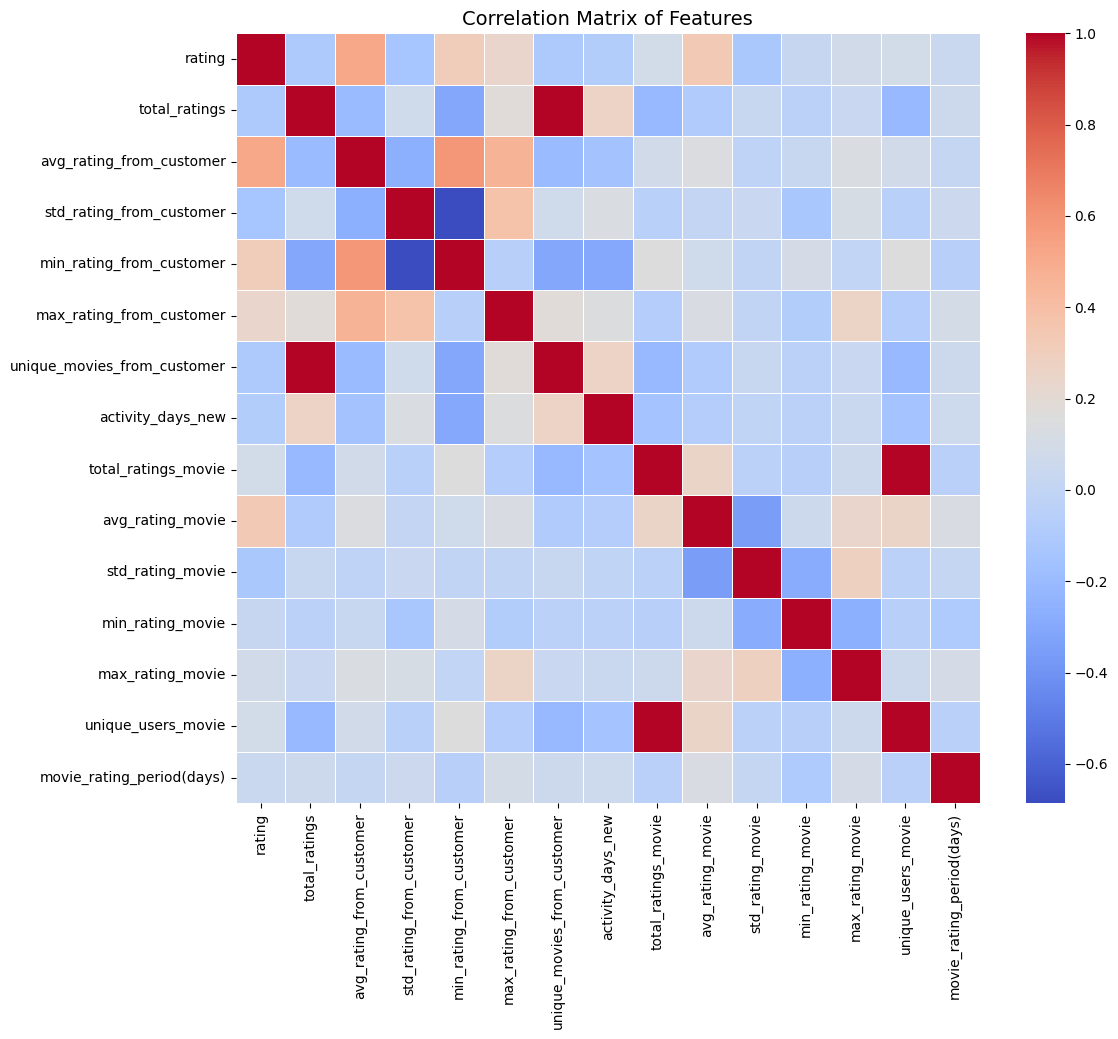

In [103]:
numeric_df = initial_df.select_dtypes(include=['number'])
numeric_df.drop('customer_id', axis=1, inplace=True)
numeric_df.drop('movie_id', axis=1, inplace=True)

corr_matrix = numeric_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Features", fontsize=14)
plt.show()



Unique_movies_from_customer and total_ratings as well as total_ratings_movie and unique_users_movie have a correlation of 1 as they contain the same values, so for each pair we'll drop one of the columns.

In [104]:
initial_df.drop('unique_movies_from_customer', axis=1, inplace=True)
initial_df.drop('unique_users_movie', axis=1, inplace=True)
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4023789 entries, 0 to 4023788
Data columns (total 22 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   movie_id                   int64         
 1   customer_id                int64         
 2   rating                     Int64         
 3   rating_date                object        
 4   title                      object        
 5   total_ratings              Int64         
 6   avg_rating_from_customer   float64       
 7   std_rating_from_customer   float64       
 8   min_rating_from_customer   Int64         
 9   max_rating_from_customer   Int64         
 10  first_rating_date          datetime64[ns]
 11  last_rating_date           datetime64[ns]
 12  activity_days_new          Int64         
 13  total_ratings_movie        Int64         
 14  avg_rating_movie           float64       
 15  std_rating_movie           float64       
 16  min_rating_movie           Int64    

In [105]:
# Calculating abs correlations with the rating feature:
abs_corr_with_rating = corr_matrix['rating'].abs().sort_values(ascending=False)

# Removing 'rating' because we already know it will be 1:
abs_corr_with_rating = abs_corr_with_rating.drop('rating')


correlation_df = abs_corr_with_rating.reset_index()
correlation_df.columns = ['Feature', 'Absolute Correlation with Rating']
display(correlation_df)

Feature  Absolute Correlation with Rating
0      avg_rating_from_customer                          0.518014
1              avg_rating_movie                          0.337718
2      min_rating_from_customer                          0.305049
3      max_rating_from_customer                          0.240220
4      std_rating_from_customer                          0.139177
5              std_rating_movie                          0.118484
6                 total_ratings                          0.103462
7   unique_movies_from_customer                          0.103462
8           total_ratings_movie                          0.086501
9            unique_users_movie                          0.086501
10            activity_days_new                          0.080315
11             max_rating_movie                          0.080218
12    movie_rating_period(days)                          0.041936
13             min_rating_movie                          0.019338

Given that the minimum correlation is 1.9% we are going to keep all of them.

Multicollinearity:

In [106]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Selecting numeric columns and dropping ID columns:
numeric_df = initial_df.select_dtypes(include=['number']).copy()
numeric_df = numeric_df.drop(['customer_id', 'movie_id'], axis=1, errors='ignore')

# Dropping rows with any NaNs:
numeric_df = numeric_df.dropna()

# Converting all columns to float to avoid dtype issues:
numeric_array = numeric_df.astype(float).values

# Computing VIF for each column:
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_df.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_array, i) for i in range(numeric_array.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))




                      feature         VIF
11           max_rating_movie  522.119811
5    max_rating_from_customer  230.286193
8            avg_rating_movie  158.632630
2    avg_rating_from_customer  128.002212
9            std_rating_movie  104.686005
10           min_rating_movie   46.630060
3    std_rating_from_customer   24.095537
0                      rating   18.619010
4    min_rating_from_customer   16.742892
12  movie_rating_period(days)    7.713562
6           activity_days_new    2.651615
7         total_ratings_movie    2.511051
1               total_ratings    2.174505


VIF results indicate very strong multicollinearity among our features (Which was expected as most of them are counted using each other).
It's an issue if we do linear regression or models sensitive to collinearity.
For now we do not remove any features, but we need to take this into consideration when building our models (we could try PCA or using just most valuable features).

#### Missing values matrix

<Axes: >

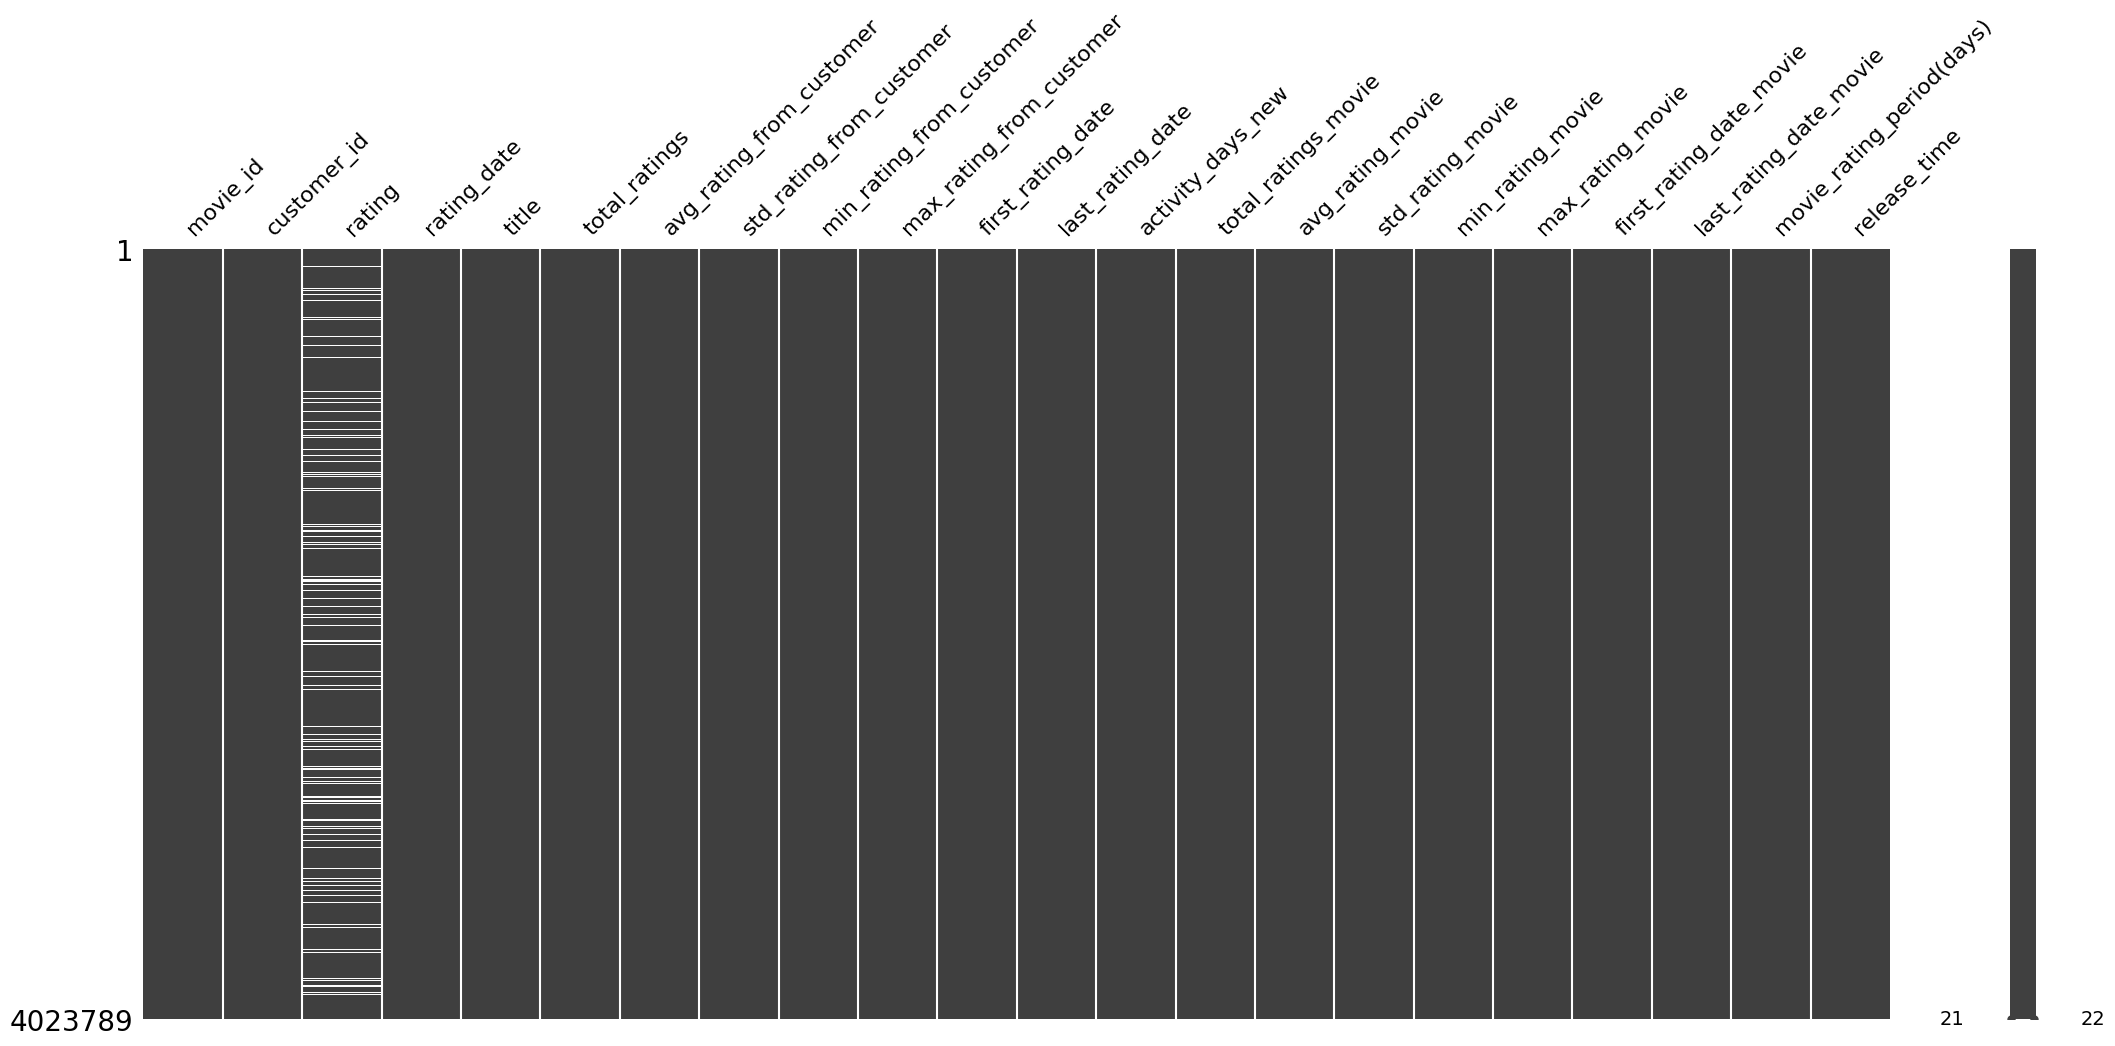

In [107]:
msno.matrix(initial_df)

#### Rating Distributions

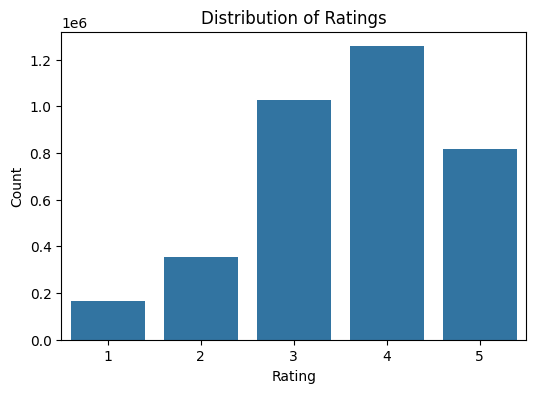

In [108]:
plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=initial_df)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

Most people give above average ratings, and only a small part of ratings are low (1 or 2).

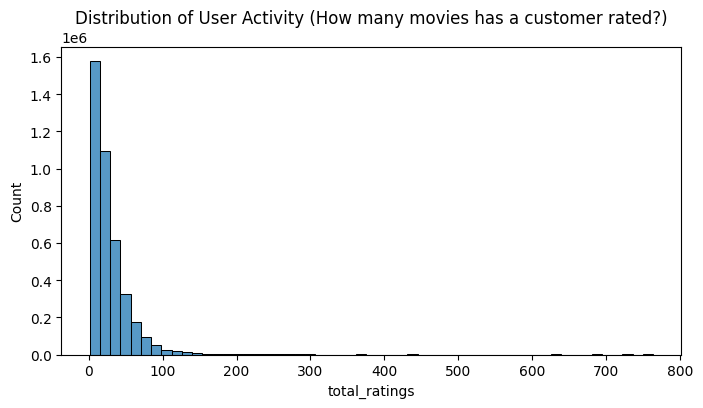

In [109]:
plt.figure(figsize=(8,4))
sns.histplot(initial_df['total_ratings'], bins=55)
plt.title("Distribution of User Activity (How many movies has a customer rated?)")
plt.show()

We have a positively skewed data, with most of the people rating up to 100 movies, and a few outliers rating 300 and more movies.

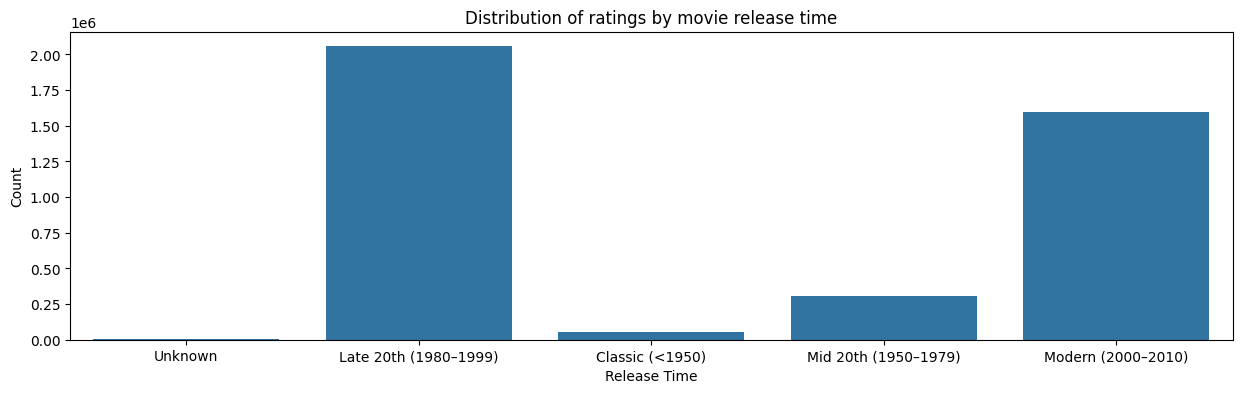

In [110]:
plt.figure(figsize=(15,4))
sns.countplot(x='release_time', data=initial_df)
plt.title("Distribution of ratings by movie release time")
plt.xlabel("Release Time")
plt.ylabel("Count")
plt.show()

Most popular films are the ones released in the late 20th century and the modern ones.

#### Boxplots for outlier detection:

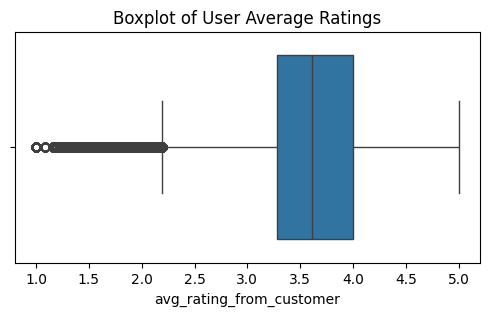

In [111]:
plt.figure(figsize=(6,3))
sns.boxplot(x=initial_df['avg_rating_from_customer'])
plt.title("Boxplot of User Average Ratings")
plt.show()



We have a negatively skewed data. With outliers, whose average rating is equal to ~1. Othee customers have mostly average averages.

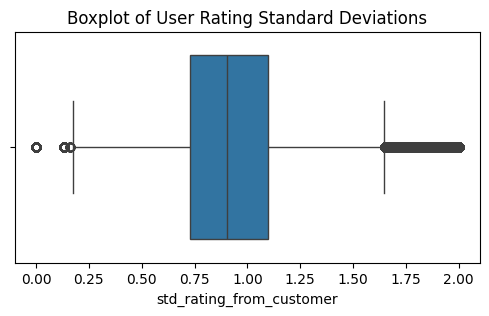

In [112]:
plt.figure(figsize=(6,3))
sns.boxplot(x=initial_df['std_rating_from_customer'])
plt.title("Boxplot of User Rating Standard Deviations")
plt.show()


Most users give similar ratings to different movies, but there are some who have extreme differences between movies (probably they really like one genre, and dislike another).

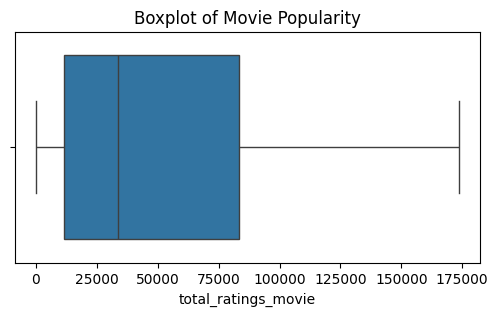

In [113]:
plt.figure(figsize=(6,3))
sns.boxplot(x=initial_df['total_ratings_movie'])
plt.title("Boxplot of Movie Popularity")
plt.show()


We could conclude that there are no outliers by looking how many times each movie was rated, but still we have a few movies which were very popular(at the rightside of the plot).

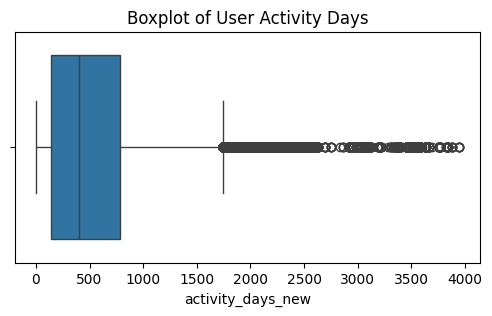

In [114]:
plt.figure(figsize=(6,3))
sns.boxplot(x=initial_df['activity_days_new'])
plt.title("Boxplot of User Activity Days")
plt.show()


We have a positively skewed data with a lot of outliers which were active for a very long period, whereas most of the people were active for around 500 days only.

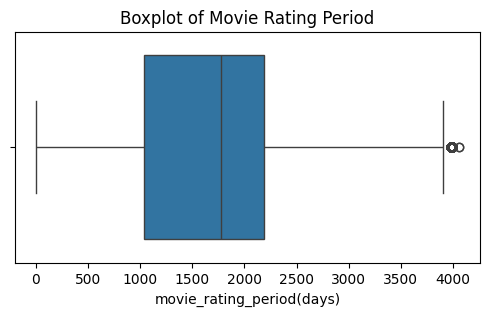

In [115]:
plt.figure(figsize=(6,3))
sns.boxplot(x=initial_df['movie_rating_period(days)'])
plt.title("Boxplot of Movie Rating Period")
plt.show()

**All found outliers above might make different trends less visible in further plots.**

#### Different relationships

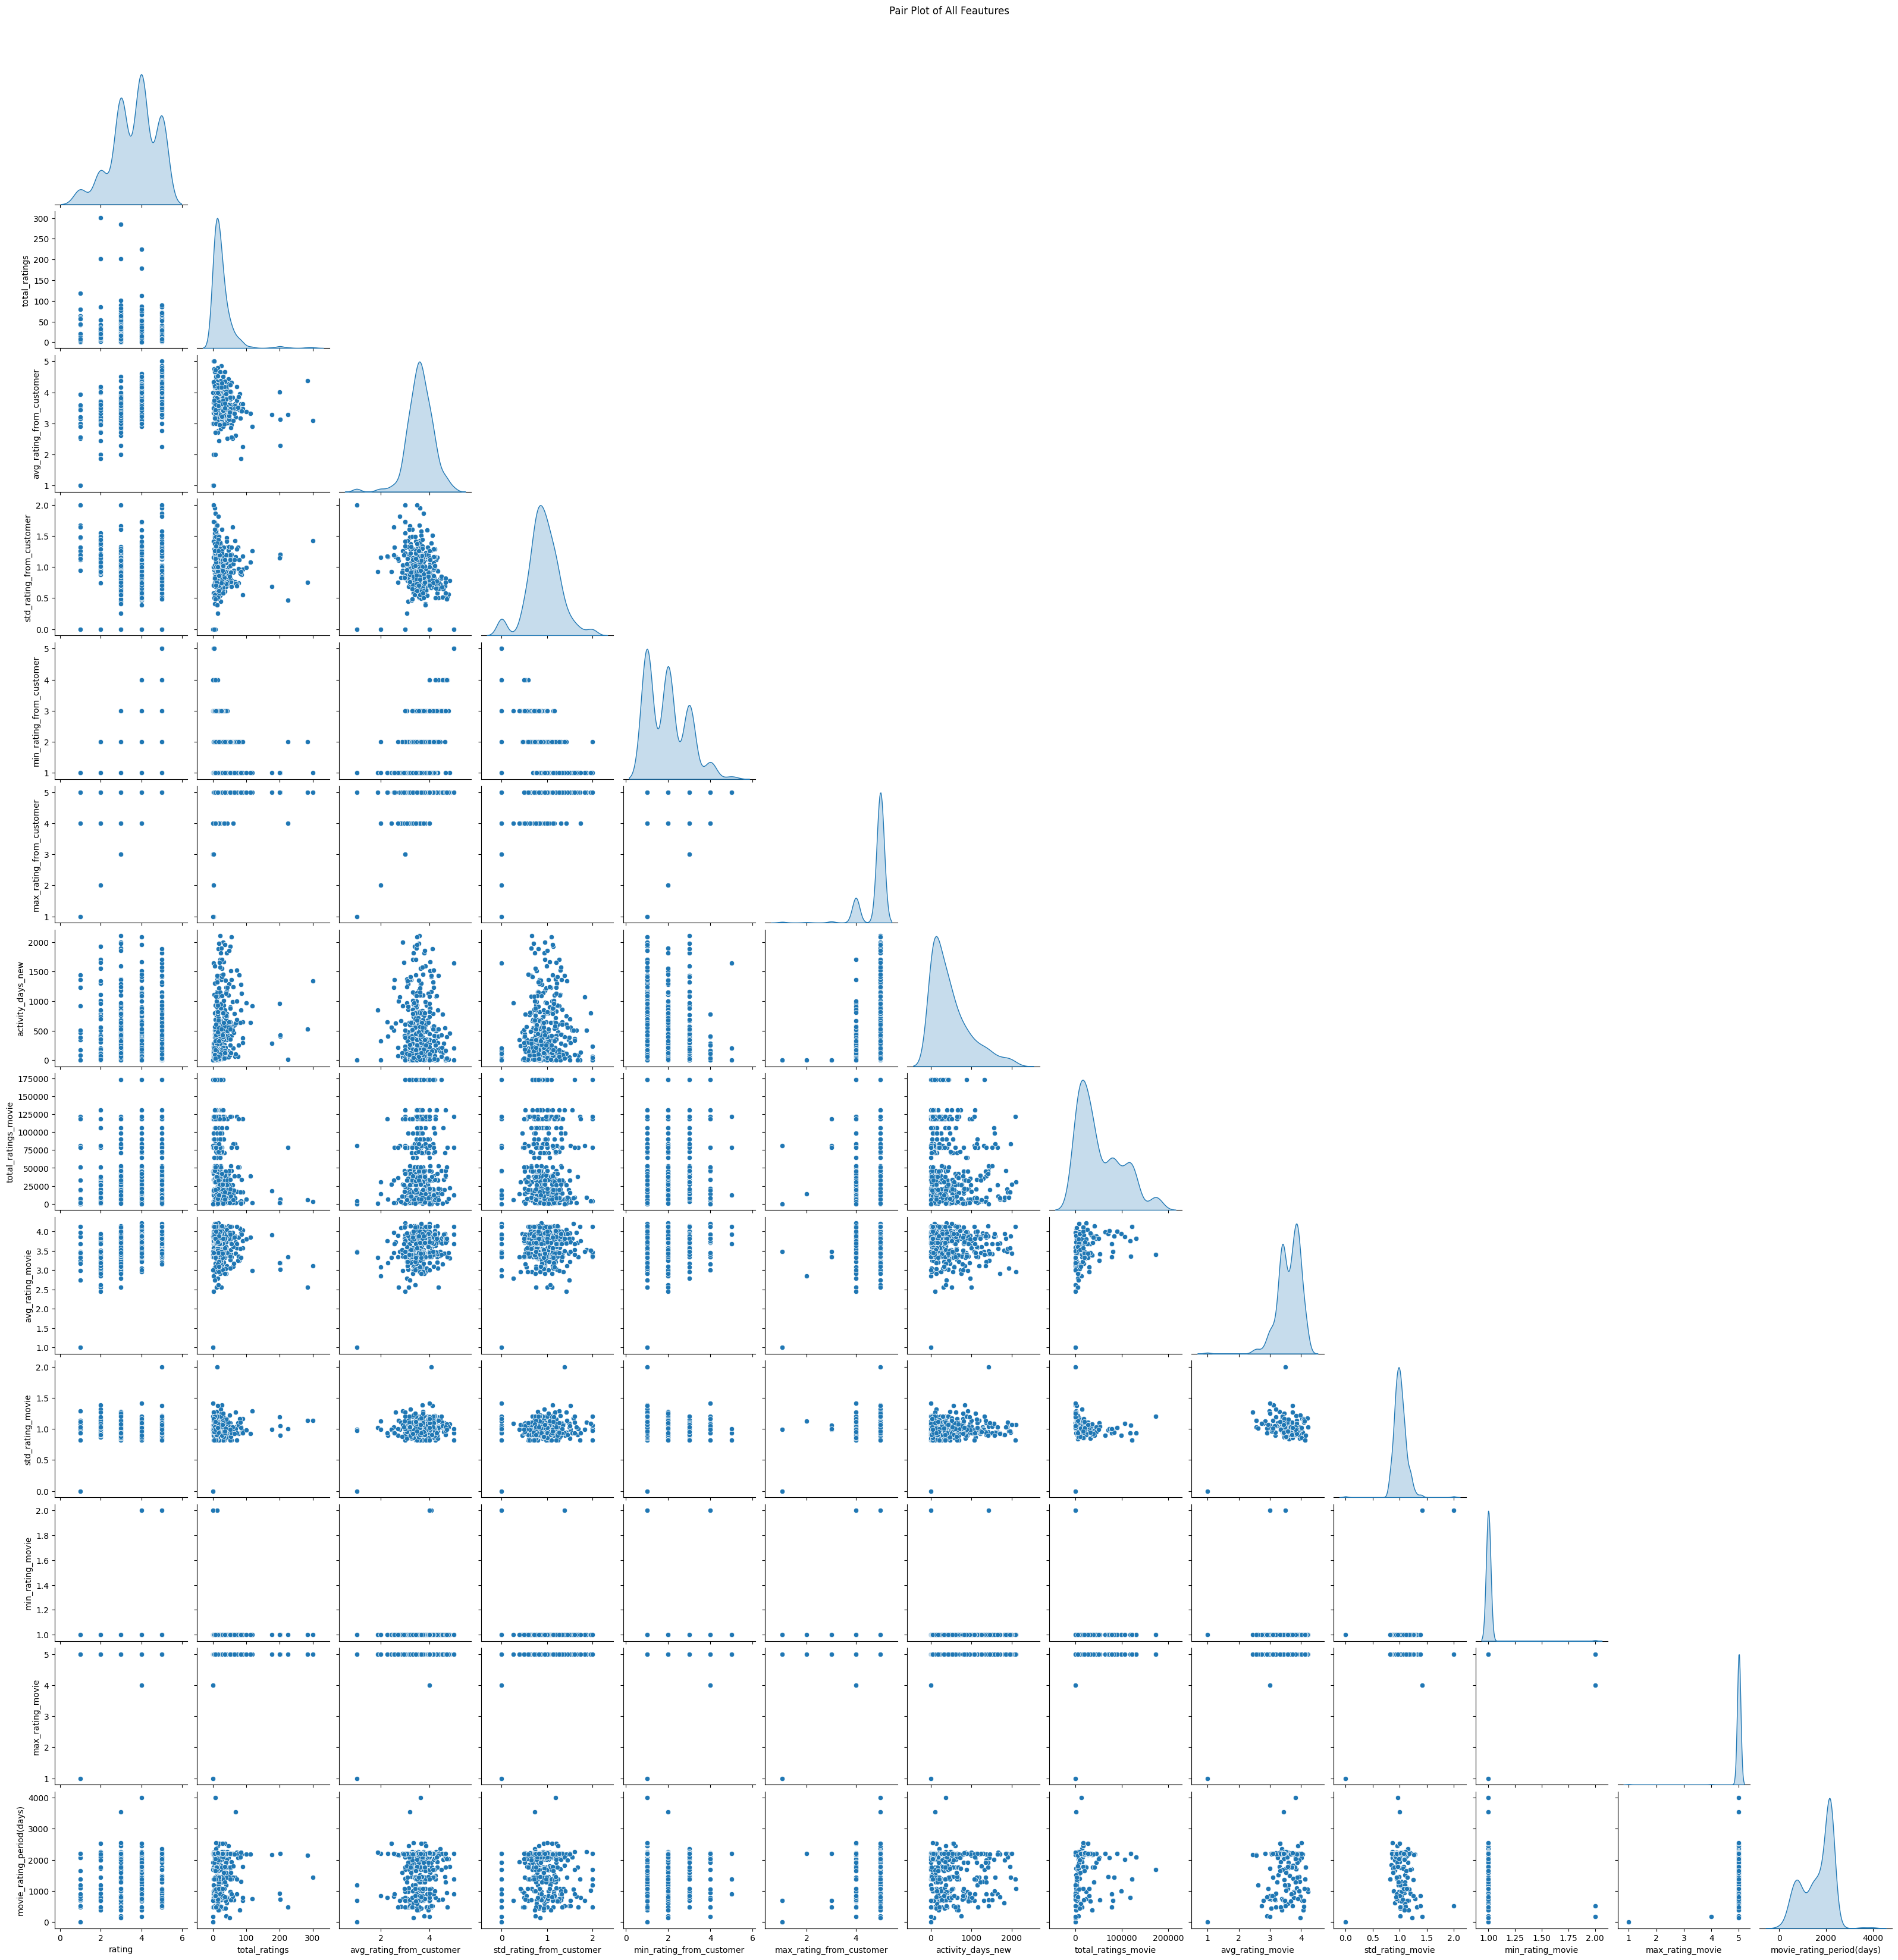

In [116]:
sns.pairplot(
    numeric_df.sample(400),
    diag_kind="kde",
    corner=True,
)

plt.suptitle('Pair Plot of All Feautures', y=1.02)
plt.show()


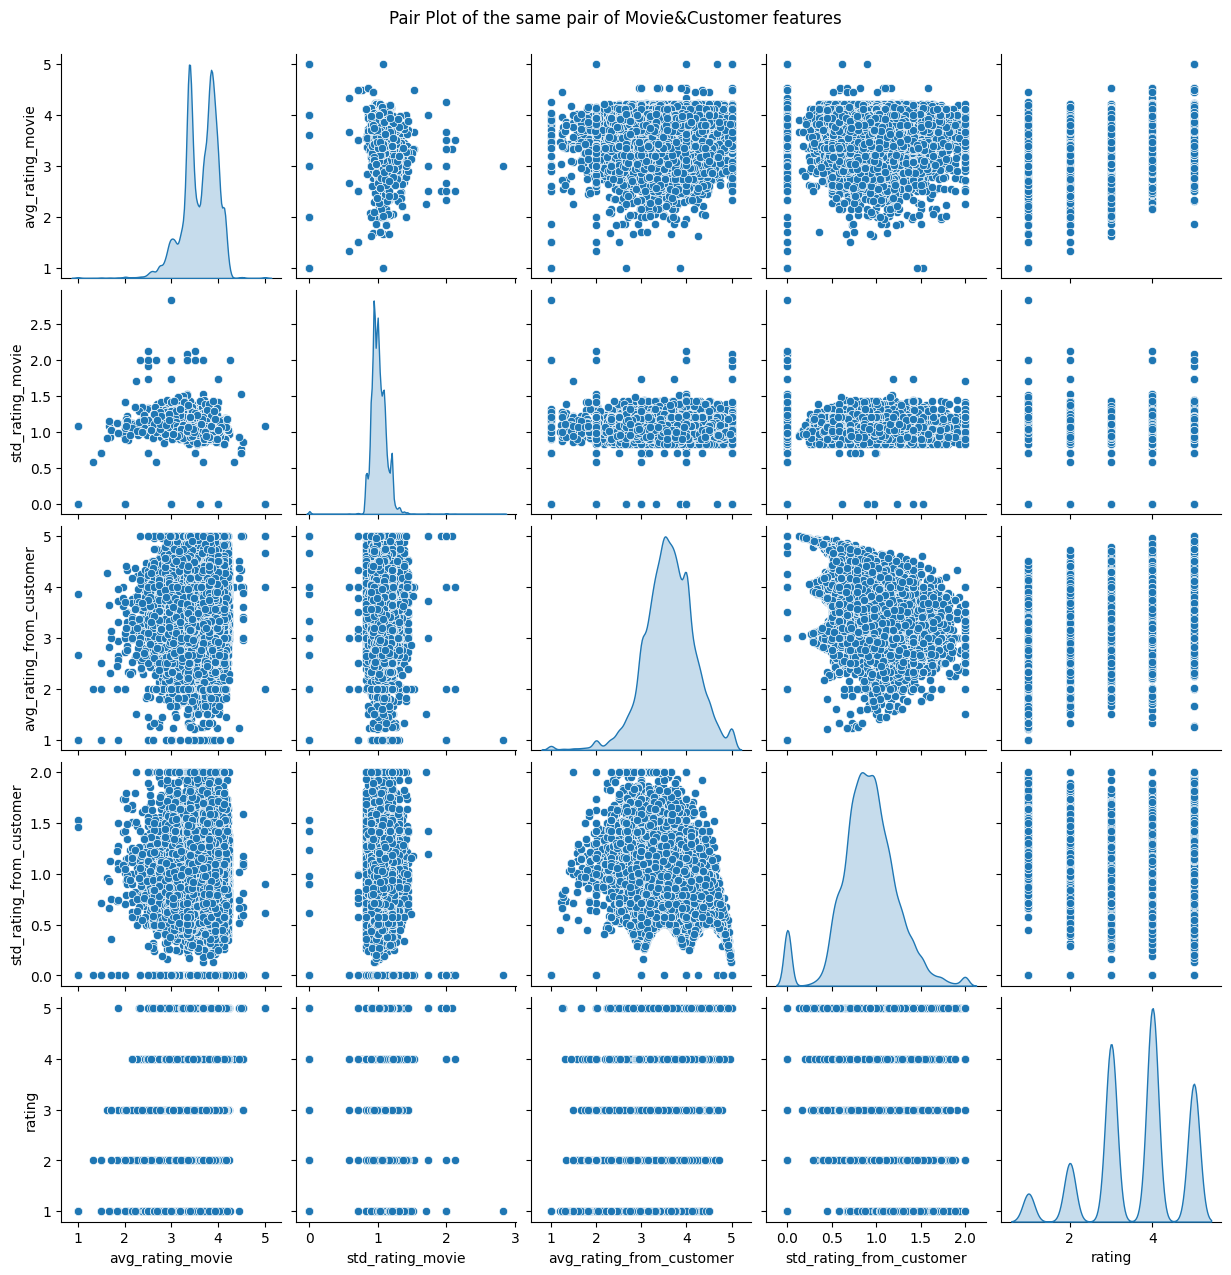

In [117]:
sns.pairplot(initial_df.sample(30000)[[
                              'avg_rating_movie',
                              'std_rating_movie',
                              'avg_rating_from_customer',
                              'std_rating_from_customer',
                              'rating']],
            diag_kind="kde")
plt.suptitle('Pair Plot of the same pair of Movie&Customer features', y=1.02)
plt.show()


We can see that those graphs are very full and do not really help us out to see any trends immediately.
The lack of immediate trends can signal to us that we're dealing with cluster/classification project more than the regression one.

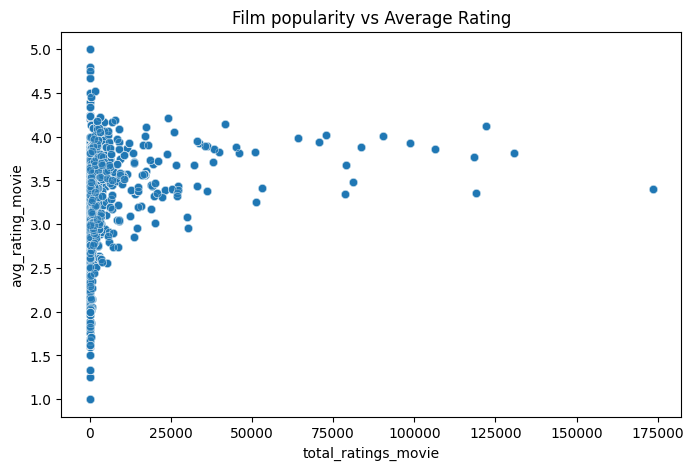

In [118]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=initial_df, x="total_ratings_movie", y="avg_rating_movie", alpha=0.5)
plt.title("Film popularity vs Average Rating")
plt.show()


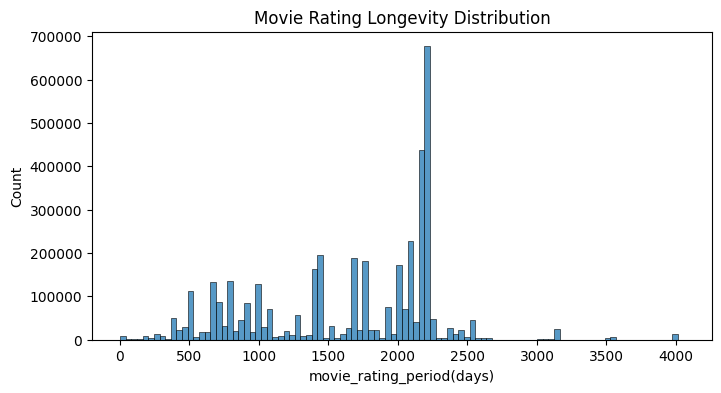

In [119]:
plt.figure(figsize=(8,4))
sns.histplot(initial_df['movie_rating_period(days)'], bins=100)
plt.title("Movie Rating Longevity Distribution")
plt.show()



I'd say we have a negatively skewed data with most film rating period ~2200 days and lower with few outliers with rating periods higher than 3000 days.

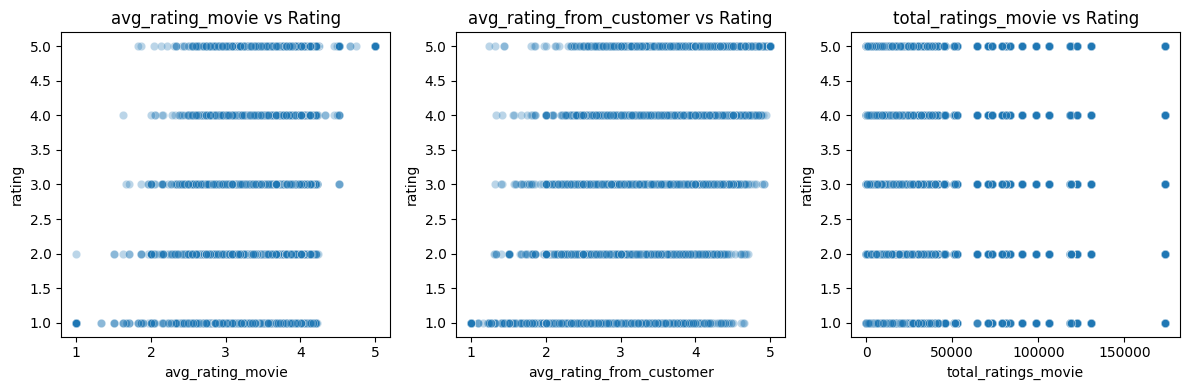

In [120]:
cols = ['avg_rating_movie', 'avg_rating_from_customer', 'total_ratings_movie']
sample_df = initial_df.sample(50000)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.scatterplot(data=sample_df, x=col, y='rating', alpha=0.3, ax=axes[i])
    axes[i].set_title(f"{col} vs Rating")


plt.tight_layout()
plt.show()


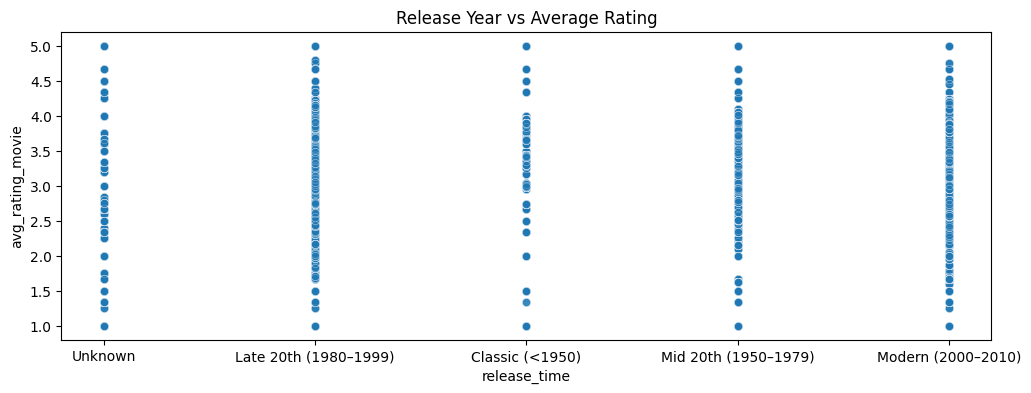

In [121]:
plt.figure(figsize=(12,4))
sns.scatterplot(data=initial_df, x='release_time', y='avg_rating_movie', alpha=0.5)
plt.title("Release Year vs Average Rating")
plt.show()


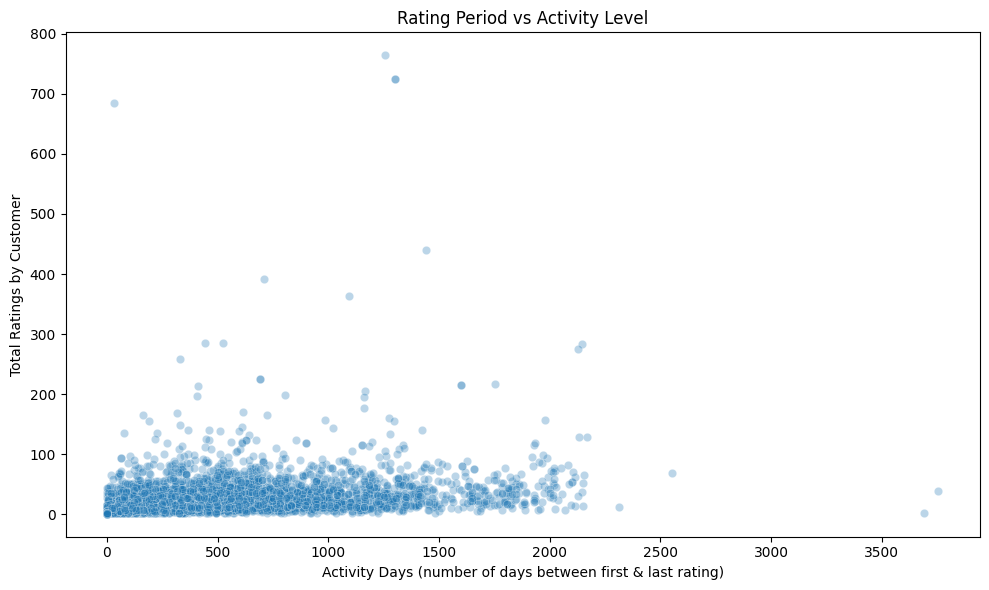

In [122]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=initial_df.sample(4000),
    x='activity_days_new',
    y='total_ratings',
    alpha=0.3
)

plt.title("Rating Period vs Activity Level")
plt.xlabel("Activity Days (number of days between first & last rating)")
plt.ylabel("Total Ratings by Customer")
plt.tight_layout()
plt.show()

There is no strong trend that we could see from the graph.

/var/folders/zw/876txld10m5bpmk5yddct8f00000gn/T/ipykernel_33336/3458673784.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample('Y')['rating']


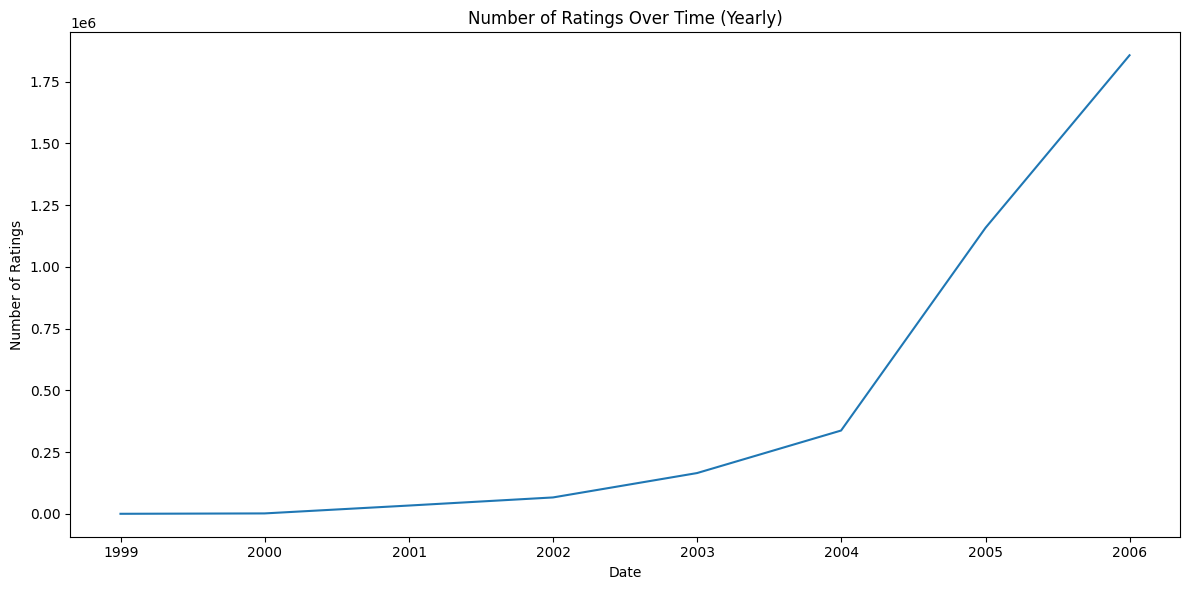

In [123]:
initial_df['rating_date'] = pd.to_datetime(initial_df['rating_date'])

yearly_ratings = (
    initial_df
    .set_index('rating_date')
    .resample('Y')['rating']
    .count()
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_ratings, x='rating_date', y='rating')
plt.title("Number of Ratings Over Time (Yearly)")
plt.xlabel("Date")
plt.ylabel("Number of Ratings")
plt.tight_layout()
plt.show()

Most films were rated in 2006.

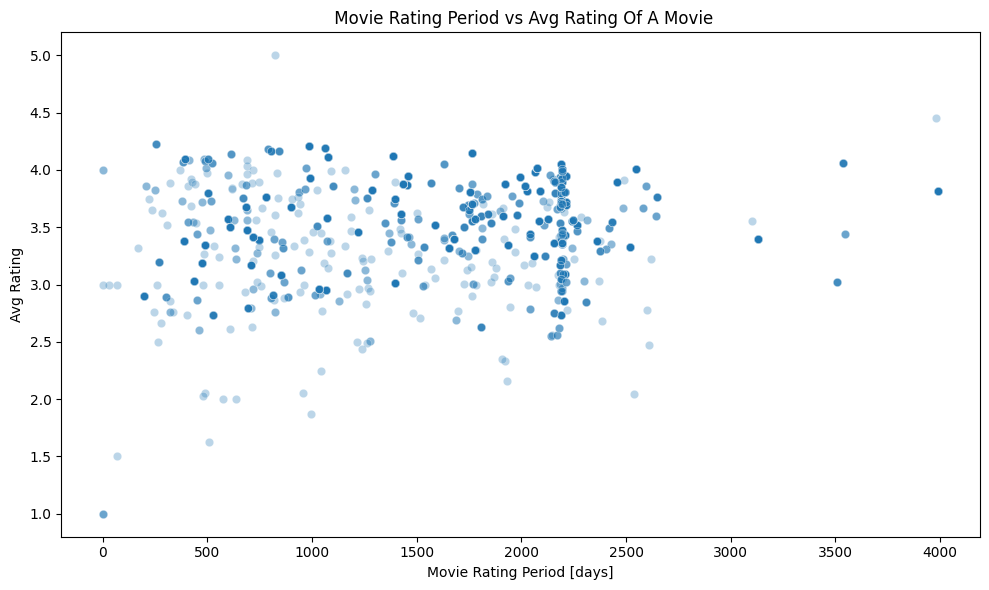

In [124]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=initial_df.sample(4000),
    x='movie_rating_period(days)',
    y='avg_rating_movie',
    alpha=0.3
)

plt.title(" Movie Rating Period vs Avg Rating Of A Movie")
plt.xlabel("Movie Rating Period [days]")
plt.ylabel("Avg Rating")
plt.tight_layout()
plt.show()

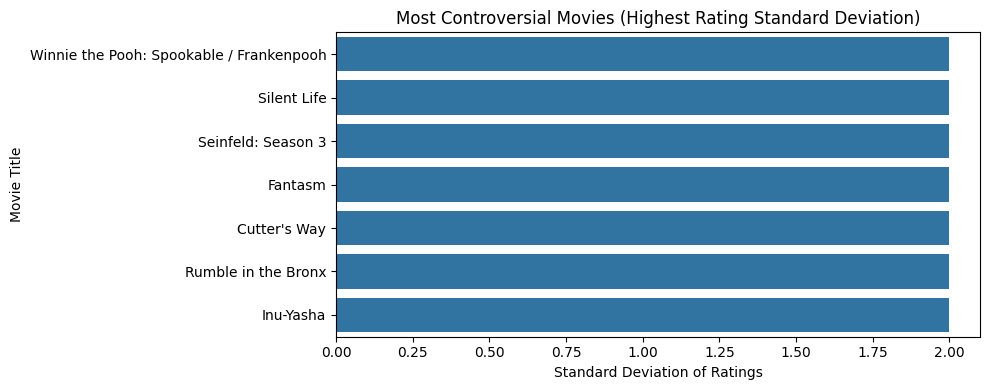

In [125]:
# Selecting movies with enough ratings to avoid movies with only 2–3 ratings)
valid_movies = initial_df[initial_df['total_ratings_movie'] >= 5]

# Grouping by movie and get std_rating_movie
movie_std = (
    valid_movies[['movie_id', 'title', 'std_rating_movie']]
    .sort_values(by='std_rating_movie', ascending=False)
    .head(10))

plt.figure(figsize=(10, 4))
sns.barplot(
    data=movie_std,
    x='std_rating_movie',
    y='title')

plt.title("Most Controversial Movies (Highest Rating Standard Deviation)")
plt.xlabel("Standard Deviation of Ratings")
plt.ylabel("Movie Title")

plt.tight_layout()
plt.show()


## **Data frame for regression**

In [126]:
df_regression=initial_df.copy()

In [127]:
df_regression.isna().sum()

movie_id                          0
customer_id                       0
rating                       402394
rating_date                       0
title                             0
total_ratings                     0
avg_rating_from_customer          0
std_rating_from_customer          0
min_rating_from_customer          0
max_rating_from_customer          0
first_rating_date                 0
last_rating_date                  0
activity_days_new                 0
total_ratings_movie               0
avg_rating_movie                  0
std_rating_movie                  0
min_rating_movie                  0
max_rating_movie                  0
first_rating_date_movie           0
last_rating_date_movie            0
movie_rating_period(days)         0
release_time                      0
dtype: int64

We drop the NaN values from the ratings column since we can’t test a rating prediction if there are NaNs. This accounts for about 11% of the dataset, but we choose to delete rather than impute, to avoid fabricating ratings that a user didn’t actually give. While we considered imputing the ratings with the movie rating mean, that would essentially be fabricating a rating for a person who didn’t give one.

In [128]:
df_regression = df_regression.dropna(subset=['rating'])

In [129]:
df_regression.isna().sum()

movie_id                     0
customer_id                  0
rating                       0
rating_date                  0
title                        0
total_ratings                0
avg_rating_from_customer     0
std_rating_from_customer     0
min_rating_from_customer     0
max_rating_from_customer     0
first_rating_date            0
last_rating_date             0
activity_days_new            0
total_ratings_movie          0
avg_rating_movie             0
std_rating_movie             0
min_rating_movie             0
max_rating_movie             0
first_rating_date_movie      0
last_rating_date_movie       0
movie_rating_period(days)    0
release_time                 0
dtype: int64

In [130]:
df_regression.info()
# Change rating column from float to integer
df_regression['rating'] = df_regression['rating'].astype(int)

<class 'pandas.core.frame.DataFrame'>
Index: 3621395 entries, 0 to 4023788
Data columns (total 22 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   movie_id                   int64         
 1   customer_id                int64         
 2   rating                     Int64         
 3   rating_date                datetime64[ns]
 4   title                      object        
 5   total_ratings              Int64         
 6   avg_rating_from_customer   float64       
 7   std_rating_from_customer   float64       
 8   min_rating_from_customer   Int64         
 9   max_rating_from_customer   Int64         
 10  first_rating_date          datetime64[ns]
 11  last_rating_date           datetime64[ns]
 12  activity_days_new          Int64         
 13  total_ratings_movie        Int64         
 14  avg_rating_movie           float64       
 15  std_rating_movie           float64       
 16  min_rating_movie           Int64         

In [131]:
df_regression.head()

movie_id  customer_id  rating rating_date  \
0     20121      2334207       4  1998-10-01   
1     19129       765000       4  1998-10-01   
2      1238      2203318       3  1998-10-01   
3     21513      1408946       1  1998-10-01   
4     12267      2544427       3  1998-10-01   

                                            title  total_ratings  \
0                                         Unknown              1   
1                                         Unknown              1   
2                   The Pope of Greenwich Village             10   
3                                         Unknown              1   
4  James Cagney Collection: The Time of Your Life              1   

   avg_rating_from_customer  std_rating_from_customer  \
0                       4.0                  0.000000   
1                       4.0                  0.000000   
2                       4.5                  0.707107   
3                       1.0                  0.000000   
4                       3.0                  0.000000   

   min_rating_from_customer  max_rating_from_customer  ... activity_days_new  \
0                         4                         4  ...                 1   
1                         4                         4  ...                 1   
2                         3                         5  ...              2602   
3                         1                         1  ...                 1   
4                         3                         3  ...                 1   

  total_ratings_movie  avg_rating_movie  std_rating_movie  min_rating_movie  \
0                   1               4.0          0.000000                 4   
1                   2               3.5          0.707107                 3   
2                   1               3.0          0.000000                 3   
3                   1               1.0          0.000000                 1   
4                   2               3.5          0.707107                 3   

   max_rating_movie  first_rating_date_movie  last_rating_date_movie  \
0                 4               1998-10-01              1998-10-01   
1                 4               1998-10-01              1999-09-11   
2                 3               1998-10-01              1998-10-01   
3                 1               1998-10-01              1998-10-01   
4                 4               1998-10-01              2005-08-03   

  movie_rating_period(days)           release_time  
0                       1.0                Unknown  
1                     346.0                Unknown  
2                       1.0  Late 20th (1980–1999)  
3                       1.0                Unknown  
4                    2499.0        Classic (<1950)  

[5 rows x 22 columns]

In [132]:
mapping = {
    'Unknown': 1,
    'Classic (<1950)': 2,
    'Mid 20th (1950–1979)': 3,
    'Late 20th (1980–1999)': 4,
    'Modern (2000–2010)': 5,
    'Other': 6
}

df_regression['release_time_int'] = df_regression['release_time'].map(mapping)
df_regression.drop('release_time', axis=1, inplace=True)
#Also drop title as it is not needed for regression:
df_regression.drop('title', axis=1, inplace=True)
#Also drop dates as they are not needed for regression:
df_regression.drop('rating_date', axis=1, inplace=True)
df_regression.drop('first_rating_date', axis=1, inplace=True)
df_regression.drop('last_rating_date', axis=1, inplace=True)
df_regression.drop('first_rating_date_movie', axis=1, inplace=True)
df_regression.drop('last_rating_date_movie', axis=1, inplace=True)
# Also drop unique_movies_from_customer and unique_users_movie as they are correlated with total ratings:
# df_regression.drop('unique_movies_from_customer', axis=1, inplace=True)
# df_regression.drop('unique_users_movie', axis=1, inplace=True)
df_regression.head(5)


movie_id  customer_id  rating  total_ratings  avg_rating_from_customer  \
0     20121      2334207       4              1                       4.0   
1     19129       765000       4              1                       4.0   
2      1238      2203318       3             10                       4.5   
3     21513      1408946       1              1                       1.0   
4     12267      2544427       3              1                       3.0   

   std_rating_from_customer  min_rating_from_customer  \
0                  0.000000                         4   
1                  0.000000                         4   
2                  0.707107                         3   
3                  0.000000                         1   
4                  0.000000                         3   

   max_rating_from_customer  activity_days_new  total_ratings_movie  \
0                         4                  1                    1   
1                         4                  1                    2   
2                         5               2602                    1   
3                         1                  1                    1   
4                         3                  1                    2   

   avg_rating_movie  std_rating_movie  min_rating_movie  max_rating_movie  \
0               4.0          0.000000                 4                 4   
1               3.5          0.707107                 3                 4   
2               3.0          0.000000                 3                 3   
3               1.0          0.000000                 1                 1   
4               3.5          0.707107                 3                 4   

   movie_rating_period(days)  release_time_int  
0                        1.0                 1  
1                      346.0                 1  
2                        1.0                 4  
3                        1.0                 1  
4                     2499.0                 2

Great now lets standarize the data into a Normal 0,1

In [133]:
#Great now lets standarize the data into a Normal 0,1 distribution for regression analysis
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_regression.drop(['customer_id', 'movie_id', 'rating'], axis=1))
scaled_df = pd.DataFrame(scaled_features, columns=df_regression.drop(['customer_id', 'movie_id', 'rating'], axis=1).columns)
scaled_df['customer_id'] = df_regression['customer_id'].values
scaled_df['movie_id'] = df_regression['movie_id'].values
scaled_df['rating'] = df_regression['rating'].values

scaled_df.head(5)

total_ratings  avg_rating_from_customer  std_rating_from_customer  \
0      -0.752370                  0.700992                 -2.734573   
1      -0.752370                  0.700992                 -2.734573   
2      -0.496245                  1.596795                 -0.602728   
3      -0.752370                 -4.673827                 -2.734573   
4      -0.752370                 -1.090615                 -2.734573   

   min_rating_from_customer  max_rating_from_customer  activity_days_new  \
0                  2.158219                 -1.626337          -1.099443   
1                  2.158219                 -1.626337          -1.099443   
2                  1.117636                  0.394913           4.335443   
3                 -0.963531                 -7.690087          -1.099443   
4                  1.117636                 -3.647587          -1.099443   

   total_ratings_movie  avg_rating_movie  std_rating_movie  min_rating_movie  \
0            -1.081639          1.074220         -8.480192         20.590748   
1            -1.081618         -0.299065         -2.534944         13.709344   
2            -1.081639         -1.672350         -8.480192         13.709344   
3            -1.081639         -7.165490         -8.480192         -0.053464   
4            -1.081618         -0.299065         -2.534944         13.709344   

   max_rating_movie  movie_rating_period(days)  release_time_int  customer_id  \
0         -6.785460                  -2.522627         -4.833657      2334207   
1         -6.785460                  -1.992305         -4.833657       765000   
2        -13.624227                  -2.522627         -0.421964      2203318   
3        -27.301761                  -2.522627         -4.833657      1408946   
4         -6.785460                   1.317210         -3.363093      2544427   

   movie_id  rating  
0     20121       4  
1     19129       4  
2      1238       3  
3     21513       1  
4     12267       3

In [134]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3621395 entries, 0 to 3621394
Data columns (total 16 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   total_ratings              float64
 1   avg_rating_from_customer   float64
 2   std_rating_from_customer   float64
 3   min_rating_from_customer   float64
 4   max_rating_from_customer   float64
 5   activity_days_new          float64
 6   total_ratings_movie        float64
 7   avg_rating_movie           float64
 8   std_rating_movie           float64
 9   min_rating_movie           float64
 10  max_rating_movie           float64
 11  movie_rating_period(days)  float64
 12  release_time_int           float64
 13  customer_id                int64  
 14  movie_id                   int64  
 15  rating                     int64  
dtypes: float64(13), int64(3)
memory usage: 442.1 MB


Divide the dataset into train and test

In [135]:
#Another try:
from sklearn.model_selection import train_test_split
user_features = [
    "total_ratings",
    "avg_rating_from_customer",
    "std_rating_from_customer",
    "min_rating_from_customer",
    "max_rating_from_customer",
    "activity_days_new"
]
X_another = scaled_df[user_features].copy()
y = scaled_df['rating']
X_train, X_test, y_train, y_test = train_test_split(X_another, y, test_size=0.2, random_state=24)

In [136]:
#Divide the dataset into train and test 80/20 split
X = scaled_df.drop(['rating', 'customer_id', 'movie_id'], axis=1)
y = scaled_df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

## **Regression**


Firstly, we want to make a remark. Given that the rating can only be from 1 to 5 the output from the regression problem is not continuous. In order to calculate the appropiate metrics (MSE, R2-score) we can round and clip the output. This can be also thought as a classification problem. However, we want to emphasize what the assignment said "Rather than simply predicting individual ratings" and try out different regression models.

#### **Linear Regression**

This is a simple model but unfortunatelly will not capture non-linear relationships within the data.

In [137]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create the linear regression model
linear_model = LinearRegression()
# Fit the model
linear_model.fit(X_train, y_train)
# Predict and clip to valid rating range
y_test_pred = np.clip(np.round(linear_model.predict(X_test)), 1, 5).astype(int)
y_train_pred = np.clip(np.round(linear_model.predict(X_train)), 1, 5).astype(int)

# MSE
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

# R² Score
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print("Train R²:", train_r2)
print("Test R²:", test_r2)

# Feature Coefficients rounded
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': np.round(linear_model.coef_, 4)
}).sort_values(by='Coefficient', ascending=False)
print(coefficients)

# Print the intercept rounded
print("Intercept:", round(linear_model.intercept_, 4))

Train MSE: 0.8403709067914437
Test MSE: 0.8404192307108173
Train R²: 0.2763648498421243
Test R²: 0.2756483509180079
                      Feature  Coefficient
1    avg_rating_from_customer       0.5400
7            avg_rating_movie       0.3145
0               total_ratings       0.0238
5           activity_days_new       0.0172
3    min_rating_from_customer       0.0139
2    std_rating_from_customer       0.0096
8            std_rating_movie      -0.0004
11  movie_rating_period(days)      -0.0023
12           release_time_int      -0.0066
6         total_ratings_movie      -0.0240
4    max_rating_from_customer      -0.0282
9            min_rating_movie      -0.0350
10           max_rating_movie      -0.0638
Intercept: 3.6089


$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_{13} x_{13}
$$


$$
\text{where the rating is } y \in [1, 5]
$$

$$
x_1 = \text{avg rating from customer}, \, \dots, \, x_{13} = \text{max rating movie}
$$


$$
\beta_0 = 3.6089 \, \text{(intercept)}
$$

$$
\beta_1, \beta_2, \dots, \beta_{13} \quad \text{(coefficients)}
$$


$$
y = 3.6089 + 0.54 x_1 + 0.3145 x_2 + \cdots -0.0638 x_{13}
$$

We cannot plot the linear regression as a simple line because $y$ is discrete, it can be visualized in a plot but not as we usually interpret it. In any case here it is. From now on the plots will be thought as if this were a classification problem given that we have discrete variables (1 to 5) so will include correlation heatmaps and so on.

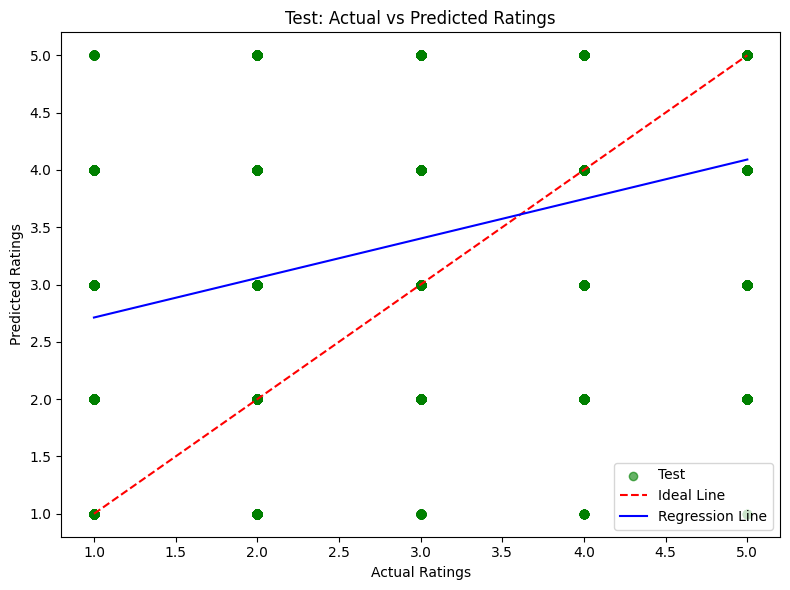

In [138]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='green', alpha=0.6, label='Test')
plt.plot([1, 5], [1, 5], color='red', linestyle='--', label='Ideal Line')

# Regression line
fit = np.polyfit(y_test, y_test_pred, 1)
fit_fn = np.poly1d(fit)
plt.plot([1, 5], fit_fn([1, 5]), color='blue', linestyle='-', label='Regression Line')

plt.title('Test: Actual vs Predicted Ratings')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.legend()

plt.tight_layout()
plt.show()

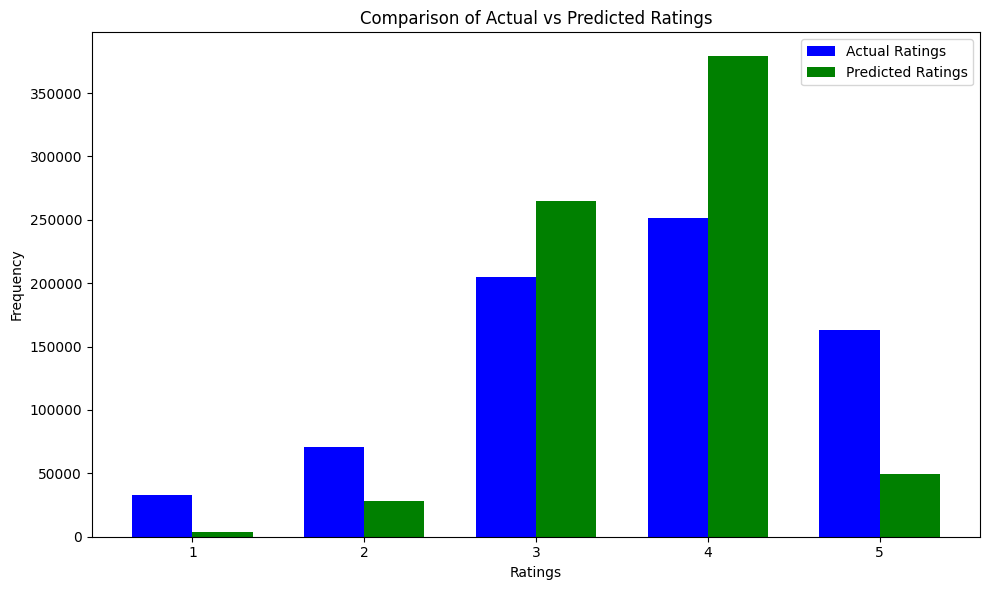

In [139]:
# Actual vs Predicted
actual_values = np.bincount(y_test, minlength=6)[1:6]
predicted_values = np.bincount(y_test_pred, minlength=6)[1:6]

labels = [str(i) for i in range(1, 6)]
x = np.arange(len(labels))

plt.figure(figsize=(10, 6))

bar_width = 0.35
plt.bar(x - bar_width/2, actual_values, bar_width, label='Actual Ratings', color='blue')
plt.bar(x + bar_width/2, predicted_values, bar_width, label='Predicted Ratings', color='green')

plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Comparison of Actual vs Predicted Ratings')
plt.xticks(x, labels)
plt.legend()

plt.tight_layout()
plt.show()


In this plot we can see the frequencies of each rating. On blue we can see the actual rating and on green the predicted. In the cases of 1, 2 and 5 our model under predicted the amount of ratings and on 3 and 4 it over predicted.

#### **CART**

We try a different approach using decision trees, in order to capture non-linear data and try to improve our R2 score. Also, we tried different combinations of hyperparameters using GridSearchCV which basically uses Cross Validation (CV) tuning max_depth, min_samples_split, min_samples_leaf.

In [140]:
from sklearn.tree import DecisionTreeRegressor

# I tried different hyperparameters using GridSearchCV
# to get the best results, these are the final ones:
cart = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=24
)

cart.fit(X_train, y_train)

# Predictions
y_test_pred = np.clip(np.round(cart.predict(X_test)), 1, 5).astype(int)
y_train_pred = np.clip(np.round(cart.predict(X_train)), 1, 5).astype(int)

# MSE
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

# R² Score
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print("Train R²:", train_r2)
print("Test R²:", test_r2)

Train MSE: 0.8256814708144237
Test MSE: 0.8298583833025671
Train R²: 0.2890137791697115
Test R²: 0.2847506738496228


As we mentioned we can see this problem in two ways as a regression or as a classification. In this analysis we are taking advantage of the confusion matrix that a classification problem provides.

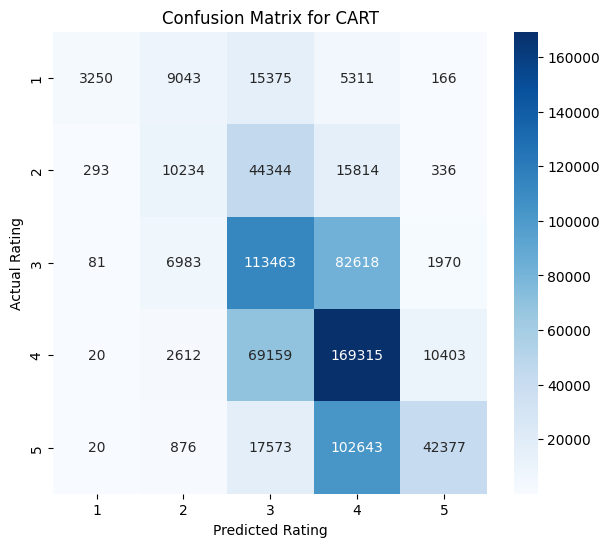

In [141]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred, labels=[1,2,3,4,5])

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3,4,5],
            yticklabels=[1,2,3,4,5])

plt.xlabel("Predicted Rating")
plt.ylabel("Actual Rating")
plt.title("Confusion Matrix for CART")
plt.show()

We can see that in the case of 3 and 4 our model got them "right". However, if we take into account our previous bar chart we know that our model is over-assigning ratings to the classes 3 and 4. The Confusion Matrix in this setting without giving us the total number of actual ratings in each category does give us incomplete information.

#### **Random Forest**

We use Random Forest (RF) because it’s an ensemble method that builds many decision trees (defined by the parameter n_tree `n_trees`) and lets them “vote” together. Each tree makes its own prediction, and the RF combines them, by averaging or majority vote, to produce an accurate result.

In [142]:
from sklearn.ensemble import RandomForestRegressor

# Tried different hyperparameters these are the best ones:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=24,
    n_jobs=-1
)

# Fit the model
rf.fit(X_train, y_train)

# Predictions
y_test_pred = np.clip(np.round(rf.predict(X_test)), 1, 5).astype(int)
y_train_pred = np.clip(np.round(rf.predict(X_train)), 1, 5).astype(int)

# MSE
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

# R² score
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print("Train R²:", train_r2)
print("Test R²:", test_r2)

Train MSE: 0.7760417601504392
Test MSE: 0.8201300879909538
Train R²: 0.3317580474324876
Test R²: 0.29313542576178897


#### **Gradient Boost Regression**

This is a new model for us that we have not seen in the lectures, it's an ensemble learning and uses decision trees the main difference from RF is that in this case every tree created is trying to correct the residuals (mistakes) from the previous decision tree. That is called the Boosting step and later one every tree will have a individual weight (based on accuracy) on the final prediction.  

In [143]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Best hyperparameters
hgb = HistGradientBoostingRegressor(
    max_iter=500,
    max_depth=20,
    learning_rate=0.1,
    random_state=24
)

# Fit the model
hgb.fit(X_train, y_train)

# Predictions
y_test_pred = np.clip(np.round(hgb.predict(X_test)), 1, 5).astype(int)
y_train_pred = np.clip(np.round(hgb.predict(X_train)), 1, 5).astype(int)

# MSE
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Train MSE:", train_mse)
print("Test MSE:", test_mse)

# R² Score
test_r2 = r2_score(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
print("Train R²:", train_r2)
print("Test R²:", test_r2)

Train MSE: 0.8096348230447107
Test MSE: 0.8169199990611353
Train R²: 0.30283139026800787
Test R²: 0.29590217969249943


A 0.01 increase in R2 score may indicate that we are encountering a problem that does not behave well as a regression problem.

Given that in all models we have a similar MSE on train and test we can say that our models are not overfitting nor underfitting, they are generalizing well.
However, our R-squared is really low, aproximatelly 28% of the variance is being caputed by every model. Lets try a different approach ANN for predicting the rating .

#### **Artificial Neural Networks**

We design an ANN to predict the rating, in hopes of illustrating non-linear relations in the data and increase the R² score. We use ReLu on the hidden layers and adam as the optimizer. The ANN diagram shown below made in [this](https://alexlenail.me/NN-SVG/index.html) website as Prof. Anna recommended is scaled down in the hidden layer by 90%. The actual number of neurons in the 1'st hidden layer is 128 and in the 2'nd is 64. When we tried to diagram it, the ANN visualization blew out of proportion.

nn.svg

We chose ADAM as the optimizer as it is interpretable and extremely efficient for this simple task. [talk about ADAM optimizer in report]

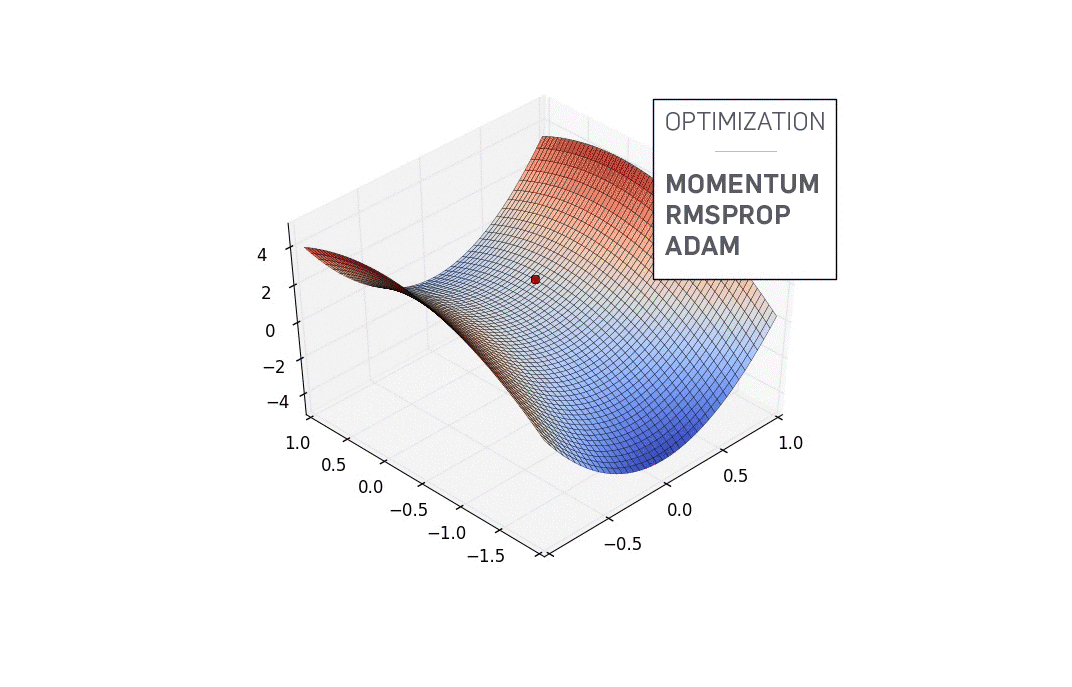

In [144]:
import tensorflow as tf
from tensorflow.keras import layers, models

# ANN model
def build_ann(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # continuous rating output
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Build the model
model = build_ann(X_train.shape[1])

# Convert to tf dataset for speed with 4M rows
batch_size = 4096
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(1)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(1)

# Train
model.fit(train_ds, epochs=5, verbose=1)

# Predictions
y_train_pred = np.clip(np.round(model.predict(X_train)), 1, 5).astype(int)
y_test_pred  = np.clip(np.round(model.predict(X_test)),  1, 5).astype(int)

# Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse  = mean_squared_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2  = r2_score(y_test, y_test_pred)

print("Train MSE:", train_mse)
print("Test MSE:", test_mse)
print("Train R²:", train_r2)
print("Test R²:", test_r2)


Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


708/708 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.1387
Epoch 2/5
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7470
Epoch 3/5
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7438
Epoch 4/5
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7426
Epoch 5/5
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7419
90535/90535 ━━━━━━━━━━━━━━━━━━━━ 19s 210us/step
22634/22634 ━━━━━━━━━━━━━━━━━━━━ 5s 213us/step
Train MSE: 0.8220499282734968
Test MSE: 0.8223875053674068
Train R²: 0.292140864853748
Test R²: 0.29118977299761184


Unfortunately our regression approaches have not been fully succesful in predicting the rating. Even though our models are good because they dont overfit based on the train and test MSE and R2 we are not getting good results. From now on we are going to focus on "understanding how viewers
interact with different genres" via clustering...

## Clustering

### Features Engineering

Creating a working copy of the dataset and converting the rating_date column to proper datetime format for downstream time-based processing.

In [145]:
# working copy of initial_df
df = initial_df.copy()

# ensure rating_date is datetime
df['rating_date'] = pd.to_datetime(df['rating_date'], errors='coerce')

print("DataFrame loaded.")
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])
df.head()

DataFrame loaded.
Rows: 4023789
Columns: 22


movie_id  customer_id  rating rating_date  \
0     20121      2334207       4  1998-10-01   
1     19129       765000       4  1998-10-01   
2      1238      2203318       3  1998-10-01   
3     21513      1408946       1  1998-10-01   
4     12267      2544427       3  1998-10-01   

                                            title  total_ratings  \
0                                         Unknown              1   
1                                         Unknown              1   
2                   The Pope of Greenwich Village             10   
3                                         Unknown              1   
4  James Cagney Collection: The Time of Your Life              1   

   avg_rating_from_customer  std_rating_from_customer  \
0                       4.0                  0.000000   
1                       4.0                  0.000000   
2                       4.5                  0.707107   
3                       1.0                  0.000000   
4                       3.0                  0.000000   

   min_rating_from_customer  max_rating_from_customer  ... activity_days_new  \
0                         4                         4  ...                 1   
1                         4                         4  ...                 1   
2                         3                         5  ...              2602   
3                         1                         1  ...                 1   
4                         3                         3  ...                 1   

  total_ratings_movie  avg_rating_movie  std_rating_movie  min_rating_movie  \
0                   1               4.0          0.000000                 4   
1                   2               3.5          0.707107                 3   
2                   1               3.0          0.000000                 3   
3                   1               1.0          0.000000                 1   
4                   2               3.5          0.707107                 3   

   max_rating_movie  first_rating_date_movie  last_rating_date_movie  \
0                 4               1998-10-01              1998-10-01   
1                 4               1998-10-01              1999-09-11   
2                 3               1998-10-01              1998-10-01   
3                 1               1998-10-01              1998-10-01   
4                 4               1998-10-01              2005-08-03   

  movie_rating_period(days)           release_time  
0                       1.0                Unknown  
1                     346.0                Unknown  
2                       1.0  Late 20th (1980–1999)  
3                       1.0                Unknown  
4                    2499.0        Classic (<1950)  

[5 rows x 22 columns]

Building a user-level aggregated table by grouping interactions by customer_id and extracting key precomputed behavioral features

In [146]:
user_df = df.groupby('customer_id').agg(
    total_ratings=('total_ratings', 'first'),
    first_rating_date=('first_rating_date', 'first'),
    last_rating_date=('last_rating_date', 'first'),
    activity_days_new=('activity_days_new', 'first'),
    avg_rating_from_customer=('avg_rating_from_customer', 'first'),
    std_rating_from_customer=('std_rating_from_customer', 'first')).reset_index()

print("User-level table created.")
print("Users:", user_df.shape[0])
user_df.head()

User-level table created.
Users: 437550


customer_id  total_ratings first_rating_date last_rating_date  \
0            6             26        2004-03-09       2005-12-04   
1            7             37        2004-05-05       2005-11-27   
2            8              5        2005-08-25       2005-08-25   
3           10             11        2002-12-20       2005-10-25   
4           25              3        2004-01-21       2005-12-03   

   activity_days_new  avg_rating_from_customer  std_rating_from_customer  
0                636                  3.576923                  0.856648  
1                572                  4.405405                  0.724931  
2                  1                  3.800000                  0.836660  
3               1041                  3.727273                  1.009050  
4                683                  3.666667                  1.154701

Standardizing the total_ratings feature using StandardScaler to produce a normalized engagement-volume variable for clustering.

In [147]:
scaler_total_ratings = StandardScaler()
user_df['scaled_total_ratings'] = scaler_total_ratings.fit_transform(user_df[['total_ratings']])

print("scaled_total_ratings (StandardScaler on total_ratings) created.")
user_df[['customer_id', 'total_ratings', 'scaled_total_ratings']].head()

scaled_total_ratings (StandardScaler on total_ratings) created.


customer_id  total_ratings  scaled_total_ratings
0            6             26              1.297213
1            7             37              2.146406
2            8              5             -0.323975
3           10             11              0.139222
4           25              3             -0.478374

Computing the recency metric by measuring how many days have passed since each user's last recorded interaction

In [148]:
max_date = df['rating_date'].max()

user_df['days_since_last_interaction'] = (max_date - user_df['last_rating_date']).dt.days

print("days_since_last_interaction computed.")
user_df[['customer_id','days_since_last_interaction']].head()


days_since_last_interaction computed.


customer_id  days_since_last_interaction
0            6                           27
1            7                           34
2            8                          128
3           10                           67
4           25                           28

Computing each user's average rating intensity by dividing total_ratings by the number of active days

In [149]:
user_df['ratings_per_active_day'] = (user_df['total_ratings'] / user_df['activity_days_new'].replace(0, 1))

print("ratings_per_active_day created.")
user_df[['customer_id', 'total_ratings', 'activity_days_new', 'ratings_per_active_day']].head()

ratings_per_active_day created.


customer_id  total_ratings  activity_days_new  ratings_per_active_day
0            6             26                636                0.040881
1            7             37                572                0.064685
2            8              5                  1                     5.0
3           10             11               1041                0.010567
4           25              3                683                0.004392

Standardizing the movie popularity metric at interaction level by converting total_ratings_movie to z-scores

In [150]:
df['total_ratings_movie'] = pd.to_numeric(df['total_ratings_movie'], errors='coerce')

scaler_movie_popularity = StandardScaler()
df['scaled_movie_popularity'] = scaler_movie_popularity.fit_transform(df[['total_ratings_movie']])

print("Movie popularity standardized at interaction level (StandardScaler).")
df[['movie_id', 'total_ratings_movie', 'scaled_movie_popularity']].head()

Movie popularity standardized at interaction level (StandardScaler).


movie_id  total_ratings_movie  scaled_movie_popularity
0     20121                    1                -1.081564
1     19129                    2                -1.081543
2      1238                    1                -1.081564
3     21513                    1                -1.081564
4     12267                    2                -1.081543

Computing each user's average movie popularity by aggregating the mean of scaled_movie_popularity across all their interactions

In [151]:
avg_pop = df.groupby('customer_id')['scaled_movie_popularity'].mean()

user_df['avg_movie_popularity'] = user_df['customer_id'].map(avg_pop)

print("avg_movie_popularity (mean of scaled_movie_popularity) added to user_df.")
user_df[['customer_id', 'avg_movie_popularity']].head()

avg_movie_popularity (mean of scaled_movie_popularity) added to user_df.


customer_id  avg_movie_popularity
0            6              0.105565
1            7             -0.137941
2            8              0.863116
3           10              0.762834
4           25             -0.108672

Checking for missing values and applying mean imputation to key user-level features to ensure a complete dataset for clustering

In [152]:
print("Missing values per column in user_df:")
print(user_df.isna().sum())

user_df_clean = user_df.copy()

cols_to_fill_mean = [
    'avg_rating_from_customer',
    'std_rating_from_customer',
    'avg_movie_popularity']

for c in cols_to_fill_mean:
    user_df_clean[c] = user_df_clean[c].fillna(user_df_clean[c].mean())

print("\nAfter simple imputation:")
print(user_df_clean.isna().sum())

Missing values per column in user_df:
customer_id                    0
total_ratings                  0
first_rating_date              0
last_rating_date               0
activity_days_new              0
avg_rating_from_customer       0
std_rating_from_customer       0
scaled_total_ratings           0
days_since_last_interaction    0
ratings_per_active_day         0
avg_movie_popularity           0
dtype: int64

After simple imputation:
customer_id                    0
total_ratings                  0
first_rating_date              0
last_rating_date               0
activity_days_new              0
avg_rating_from_customer       0
std_rating_from_customer       0
scaled_total_ratings           0
days_since_last_interaction    0
ratings_per_active_day         0
avg_movie_popularity           0
dtype: int64


Assembling the final user-level feature matrix for clustering by selecting and consolidating all cleaned behavioral variables

In [153]:
final_features = [
    'scaled_total_ratings',
    'activity_days_new',
    'days_since_last_interaction',
    'ratings_per_active_day',
    'avg_rating_from_customer',
    'std_rating_from_customer',
    'avg_movie_popularity'
]

clustering_df = user_df_clean[['customer_id'] + final_features].copy()

print("Final clustering dataset created.")
print("Shape:", clustering_df.shape)
clustering_df.head()

Final clustering dataset created.
Shape: (437550, 8)


customer_id  scaled_total_ratings  activity_days_new  \
0            6              1.297213                636   
1            7              2.146406                572   
2            8             -0.323975                  1   
3           10              0.139222               1041   
4           25             -0.478374                683   

   days_since_last_interaction  ratings_per_active_day  \
0                           27                0.040881   
1                           34                0.064685   
2                          128                     5.0   
3                           67                0.010567   
4                           28                0.004392   

   avg_rating_from_customer  std_rating_from_customer  avg_movie_popularity  
0                  3.576923                  0.856648              0.105565  
1                  4.405405                  0.724931             -0.137941  
2                  3.800000                  0.836660              0.863116  
3                  3.727273                  1.009050              0.762834  
4                  3.666667                  1.154701             -0.108672

Extracting the final numeric feature matrix used as input for clustering models

In [154]:
X = clustering_df[final_features].copy()

print("Matrix X created.")
print("Shape:", X.shape)
X.head()

Matrix X created.
Shape: (437550, 7)


scaled_total_ratings  activity_days_new  days_since_last_interaction  \
0              1.297213                636                           27   
1              2.146406                572                           34   
2             -0.323975                  1                          128   
3              0.139222               1041                           67   
4             -0.478374                683                           28   

   ratings_per_active_day  avg_rating_from_customer  std_rating_from_customer  \
0                0.040881                  3.576923                  0.856648   
1                0.064685                  4.405405                  0.724931   
2                     5.0                  3.800000                  0.836660   
3                0.010567                  3.727273                  1.009050   
4                0.004392                  3.666667                  1.154701   

   avg_movie_popularity  
0              0.105565  
1             -0.137941  
2              0.863116  
3              0.762834  
4             -0.108672

Standardizing all clustering features with StandardScaler to ensure equal contribution across dimensions

In [155]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaling completed.")
print("Example scaled row:", X_scaled[0])

Scaling completed.
Example scaled row: [ 1.29721256  0.92500822 -0.72420088 -0.45037529 -0.07071264  0.27289794
 -0.18497638]


Applying PCA to reduce the standardized feature matrix to two principal components for visualization and exploratory analysis

In [156]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=24)
X_pca = pca.fit_transform(X_scaled)

print("PCA completed.")
print("Shape of X_pca:", X_pca.shape)

PCA completed.
Shape of X_pca: (437550, 2)


Evaluating how much of the dataset’s variance is captured by the first two PCA components by inspecting the explained variance ratios

The first two principal components explain approximately 47.16% of the total variance in the standardized feature space (PC1 ≈ 28.70%, PC2 ≈ 18.46%).

This means that the 2D PCA projection captures almost half of the overall information, which is reasonable given the original seven-dimensional structure of the data.

While the 2D representation cannot fully preserve all variability, it is sufficiently informative for visual exploration of cluster separability and high-level behavioral patterns among users.

In [157]:
explained_var = pca.explained_variance_ratio_
print("Explained variance ratio for PC1 and PC2:")
print(explained_var)
print("Total variance explained by PCA 2D:", explained_var.sum())

Explained variance ratio for PC1 and PC2:
[0.28701695 0.18456978]
Total variance explained by PCA 2D: 0.47158672358197906


Building a dataframe that pairs each user's ID with their coordinates on the first two PCA components for visualization

In [158]:
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'customer_id': clustering_df['customer_id']})

pca_df.head()

PC1       PC2  customer_id
0  1.694373 -0.279293            6
1  1.925854 -0.365742            7
2 -1.618411 -1.517895            8
3  1.560392 -0.716219           10
4  1.135697 -0.236159           25

Plotting a 2D PCA scatter projection to visualize the overall distribution of users before applying clustering.

The 2D PCA projection reveals a highly concentrated user distribution with a clear triangular or fan-shaped geometry. Most users cluster densely around the origin, indicating relatively homogeneous behavior across the dominant variance directions. The elongated vertical branch toward higher PC2 values suggests a subgroup of users with distinctive patterns—likely driven by strong variation in one or more behavioral features such as activity intensity or recency. A smaller horizontal spread along PC1 indicates additional variability, potentially related to differences in total engagement volume or rating style. A few isolated points on the far right and far lower-left regions reflect sparse outliers.

Overall, while the projection preserves only ~47% of the total variance, it still highlights meaningful structural heterogeneity and potential latent subgroups that justify downstream clustering analysis.

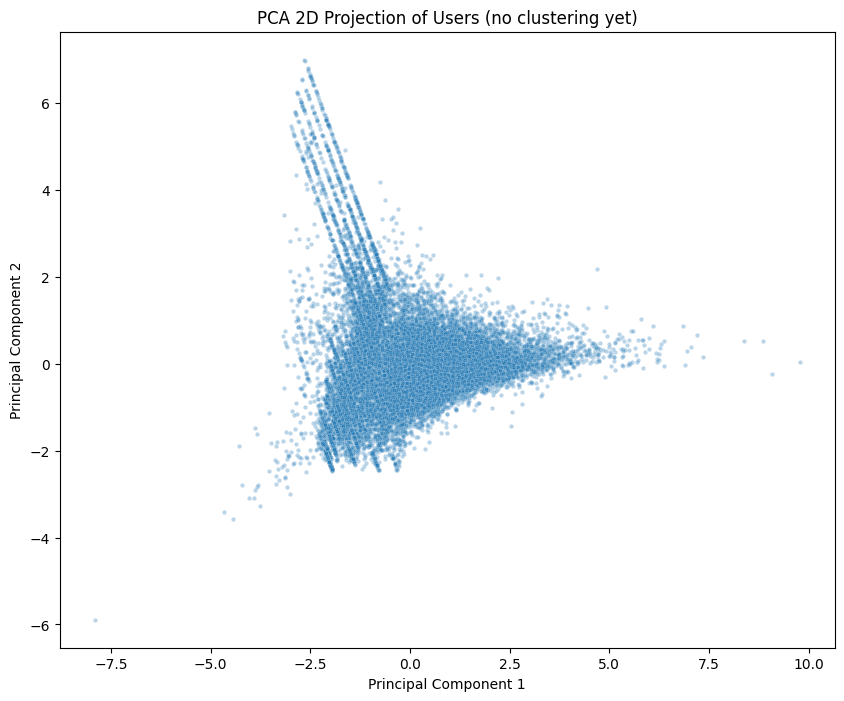

In [159]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    x='PC1', y='PC2',
    data=pca_df.sample(20000),  # visivamente amichevole
    s=10, alpha=0.3)

plt.title("PCA 2D Projection of Users (no clustering yet)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

### K-Means

Evaluating K-Means for different k values using inertia and silhouette score on a large random sample to guide the choice of the optimal number of clusters

In [160]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k_values = range(2, 11)
inertias = []
silhouette_scores = []

# sample for metrics to speed up
metric_sample_size = 50000
if X_scaled.shape[0] > metric_sample_size:
    idx_metrics = np.random.choice(X_scaled.shape[0], size=metric_sample_size, replace=False)
    X_metrics = X_scaled[idx_metrics]
else:
    X_metrics = X_scaled

for k in k_values:
    kmeans_tmp = KMeans(n_clusters=k, random_state=24, n_init='auto')
    labels_tmp = kmeans_tmp.fit_predict(X_metrics)

    inertias.append(kmeans_tmp.inertia_)
    silhouette_scores.append(silhouette_score(X_metrics, labels_tmp))

print("k values:", list(k_values))
print("Inertia:", inertias)
print("Silhouette:", silhouette_scores)

k values: [2, 3, 4, 5, 6, 7, 8, 9, 10]
Inertia: [284116.2679209201, 251238.21643061243, 225866.5510814275, 202053.90327737684, 181249.33141223798, 161163.58874620154, 146242.89144052847, 139221.49075228133, 128610.24249079083]
Silhouette: [0.2134013365403867, 0.18139848963634853, 0.19141526205662826, 0.20740710453732347, 0.20002198317748596, 0.2170373821967005, 0.22983901594419162, 0.20990523328435412, 0.2190302868355703]


Plotting the KMeans inertia curve to visually identify the elbow point and guide the selection of an appropriate number of clusters

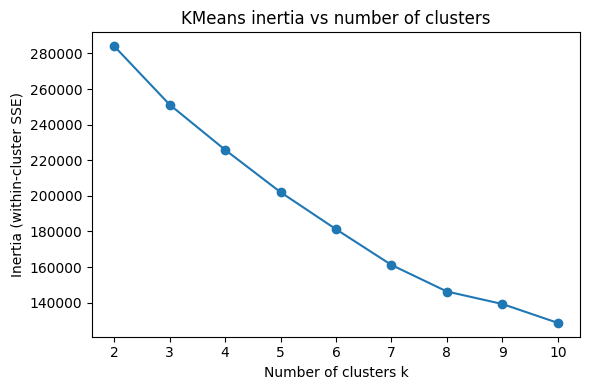

In [161]:
plt.figure(figsize=(6, 4))
plt.plot(list(k_values), inertias, marker='o')
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("KMeans inertia vs number of clusters")
plt.xticks(list(k_values))
plt.tight_layout()
plt.show()

Plotting silhouette scores across different k values to assess cluster quality and identify the most appropriate number of clusters for KMeans

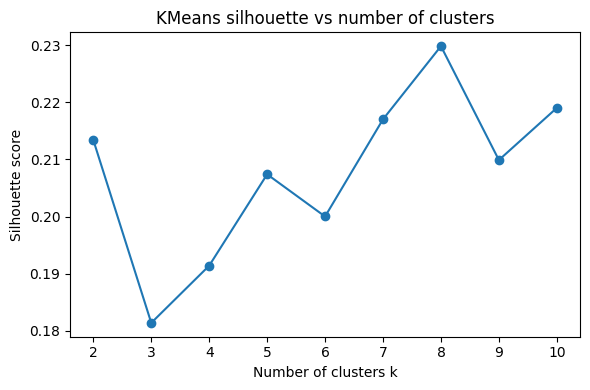

In [162]:
plt.figure(figsize=(6, 4))
plt.plot(list(k_values), silhouette_scores, marker='o')
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette score")
plt.title("KMeans silhouette vs number of clusters")
plt.xticks(list(k_values))
plt.tight_layout()
plt.show()

Creating and sorting a summary table of inertia and silhouette metrics to identify the best-performing KMeans cluster count

In [163]:
metrics_df = pd.DataFrame({
    'k': list(k_values),
    'inertia': inertias,
    'silhouette': silhouette_scores})

print("Metrics summary (sorted by silhouette score):")
display(metrics_df.sort_values('silhouette', ascending=False))

Metrics summary (sorted by silhouette score):


k        inertia  silhouette
6   8  146242.891441    0.229839
8  10  128610.242491    0.219030
5   7  161163.588746    0.217037
0   2  284116.267921    0.213401
7   9  139221.490752    0.209905
3   5  202053.903277    0.207407
4   6  181249.331412    0.200022
2   4  225866.551081    0.191415
1   3  251238.216431    0.181398

Best K = 7


In [164]:
chosen_k = 7

print("Chosen k for final KMeans (manual decision):", chosen_k)

Chosen k for final KMeans (manual decision): 7


Training the final KMeans model with the chosen number of clusters and assigning each user a cluster label for downstream analysis

In [165]:
kmeans_final = KMeans(n_clusters=chosen_k, random_state=24, n_init='auto')
labels_final = kmeans_final.fit_predict(X_scaled)

clustering_df['kmeans_cluster'] = labels_final

print("Cluster label counts:")
print(clustering_df['kmeans_cluster'].value_counts().sort_index())

Cluster label counts:
kmeans_cluster
0     63558
1     24332
2     58012
3    181173
4     19692
5     16025
6     74758
Name: count, dtype: int64


Plotting the final KMeans clusters in the 2D PCA space to visually assess cluster distribution and separability

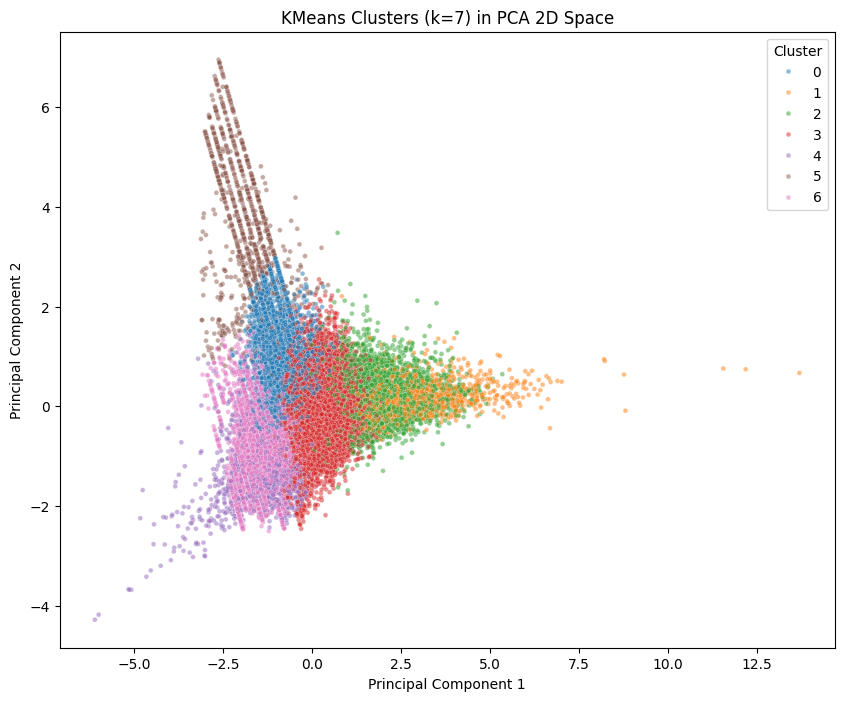

In [166]:
# Add cluster labels into PCA dataframe (safe merge)
pca_df['kmeans_cluster'] = clustering_df['kmeans_cluster'].values

# Sample for visualization
sample_size = 30000
pca_sample = pca_df.sample(sample_size, random_state=24)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='kmeans_cluster',
    data=pca_sample,
    palette='tab10',
    s=12, alpha=0.5)
plt.title(f"KMeans Clusters (k={chosen_k}) in PCA 2D Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc="best")
plt.show()

Plotting and inspecting the size of each KMeans cluster to assess distribution balance and validate cluster robustness

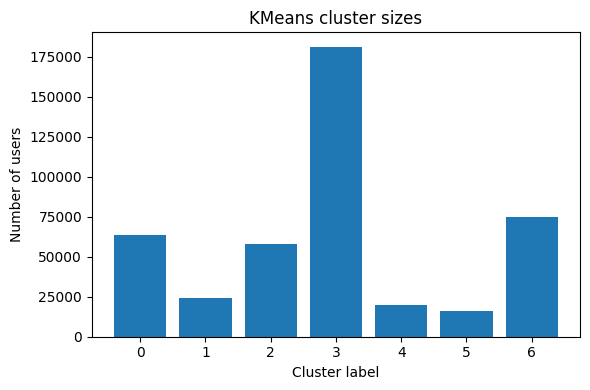

Cluster sizes:
kmeans_cluster
0     63558
1     24332
2     58012
3    181173
4     19692
5     16025
6     74758
Name: count, dtype: int64


In [167]:
cluster_counts = clustering_df['kmeans_cluster'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(cluster_counts.index.astype(str), cluster_counts.values)
plt.xlabel("Cluster label")
plt.ylabel("Number of users")
plt.title("KMeans cluster sizes")
plt.tight_layout()
plt.show()

print("Cluster sizes:")
print(cluster_counts)

Computing per-cluster means and standard deviations for all behavioral features to characterize and interpret the profiles of each KMeans cluster

In [168]:
cluster_profile_mean = clustering_df.groupby('kmeans_cluster')[final_features].mean()
cluster_profile_std = clustering_df.groupby('kmeans_cluster')[final_features].std()

print("Cluster profile - mean values:")
display(cluster_profile_mean)

print("\nCluster profile - standard deviation:")
display(cluster_profile_std)

Cluster profile - mean values:


scaled_total_ratings  activity_days_new  \
kmeans_cluster                                            
0                          -0.552043          59.672472   
1                           3.012580         651.468108   
2                           0.427000        1023.426136   
3                          -0.034929         219.079532   
4                          -0.247971           1.152295   
5                          -0.596911          23.547832   
6                          -0.564618          26.125712   

                days_since_last_interaction  ratings_per_active_day  \
kmeans_cluster                                                        
0                                313.719075                0.744767   
1                                102.731054                0.147085   
2                                195.874560                0.015777   
3                                192.687564                0.177154   
4                                193.758125                 5.26802   
5                               1532.672012                0.963451   
6                                237.375492                1.152869   

                avg_rating_from_customer  std_rating_from_customer  \
kmeans_cluster                                                       
0                               3.778487                  0.122067   
1                               3.522657                  0.934330   
2                               3.565775                  0.950624   
3                               3.623581                  1.029743   
4                               3.592122                  1.066931   
5                               2.971073                  0.137592   
6                               3.778106                  0.217228   

                avg_movie_popularity  
kmeans_cluster                        
0                          -0.585436  
1                          -0.294082  
2                           0.022278  
3                           0.235307  
4                           0.616257  
5                          -0.669729  
6                           1.513371


Cluster profile - standard deviation:


scaled_total_ratings  activity_days_new  \
kmeans_cluster                                            
0                           0.154890         121.413149   
1                           1.817384         434.228244   
2                           0.651365          366.32252   
3                           0.501680          174.23933   
4                           0.373589           0.733225   
5                           0.112594          90.728494   
6                           0.100280          82.396421   

                days_since_last_interaction  ratings_per_active_day  \
kmeans_cluster                                                        
0                                230.963097                0.592382   
1                                 98.220695                0.321061   
2                                164.545869                0.010058   
3                                170.189534                0.409375   
4                                181.094145                 3.29228   
5                                493.170149                0.514304   
6                                211.372021                0.785678   

                avg_rating_from_customer  std_rating_from_customer  \
kmeans_cluster                                                       
0                               1.114109                  0.242992   
1                               0.463282                  0.213466   
2                               0.504100                  0.304479   
3                               0.574567                  0.379096   
4                               0.680187                  0.439489   
5                               1.350527                  0.362345   
6                               1.011363                  0.352547   

                avg_movie_popularity  
kmeans_cluster                        
0                           0.459296  
1                           0.184423  
2                           0.414010  
3                           0.508918  
4                           0.562589  
5                           0.774096  
6                           0.644079

Generating feature-wise boxplots to visually compare distributions across clusters and assess separation quality

<Figure size 600x400 with 0 Axes>

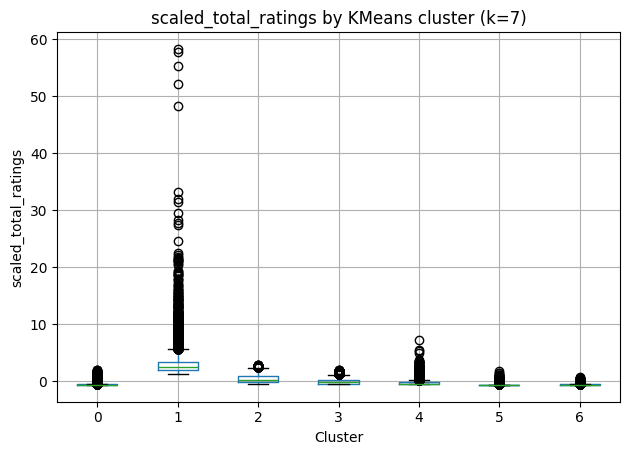

<Figure size 600x400 with 0 Axes>

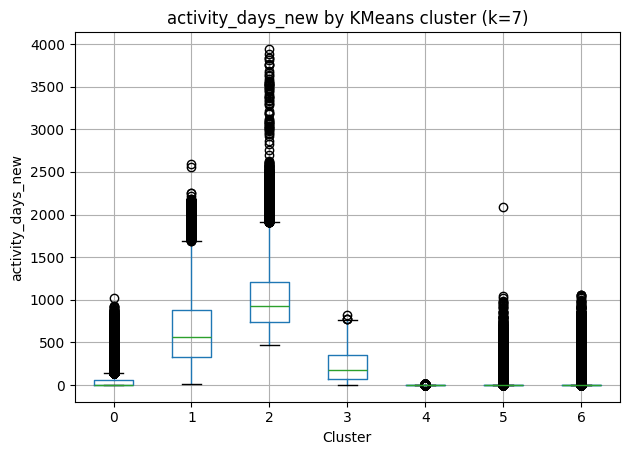

<Figure size 600x400 with 0 Axes>

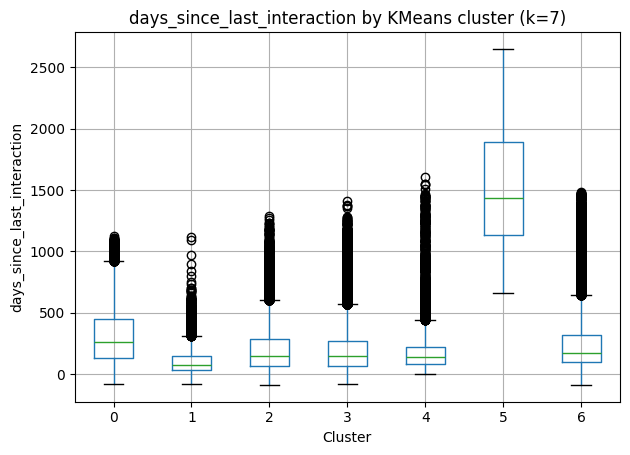

<Figure size 600x400 with 0 Axes>

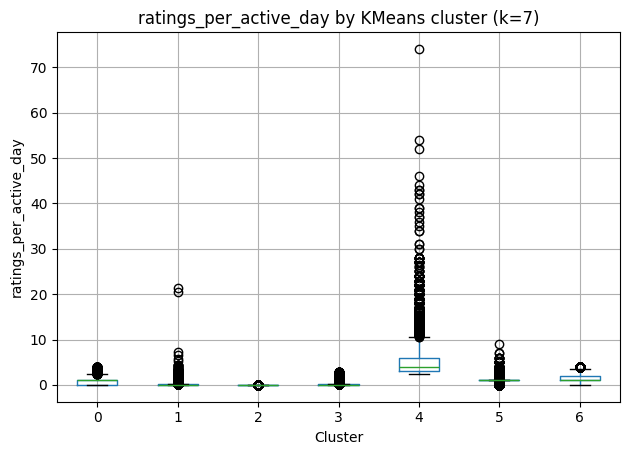

<Figure size 600x400 with 0 Axes>

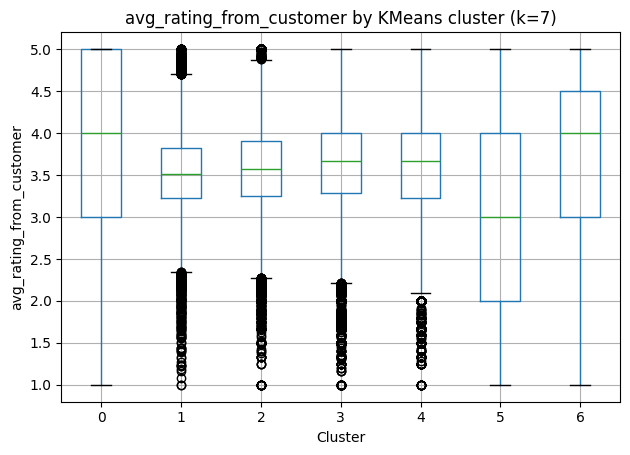

<Figure size 600x400 with 0 Axes>

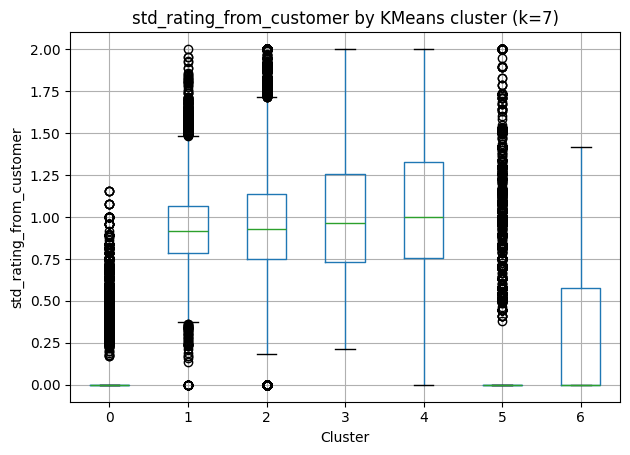

<Figure size 600x400 with 0 Axes>

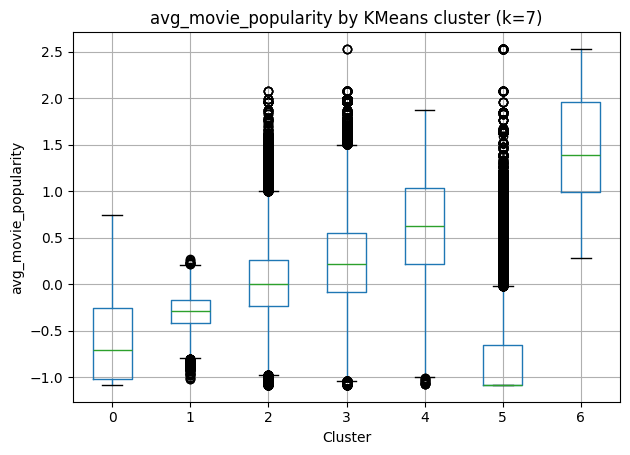

In [169]:
for feature in final_features:
    plt.figure(figsize=(6, 4))
    clustering_df.boxplot(column=feature, by='kmeans_cluster')
    plt.title(f"{feature} by KMeans cluster (k={chosen_k})")
    plt.suptitle("")  # remove automatic super title
    plt.xlabel("Cluster")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

In [170]:
centroids_scaled = kmeans_final.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

centroids_df = pd.DataFrame(centroids_original, columns=final_features)
centroids_df.index.name = 'kmeans_cluster'

print("Cluster centroids in original feature scale:")
display(centroids_df)


Cluster centroids in original feature scale:


scaled_total_ratings  activity_days_new  \
kmeans_cluster                                            
0                          -0.552054          59.672478   
1                           3.015118         652.722798   
2                           0.426119        1021.655719   
3                          -0.035040         218.634526   
4                          -0.248006           1.152315   
5                          -0.596912          23.546970   
6                          -0.564666          26.104269   

                days_since_last_interaction  ratings_per_active_day  \
kmeans_cluster                                                        
0                                313.731437                0.744731   
1                                102.717901                0.146967   
2                                195.829800                0.015804   
3                                192.703689                0.177386   
4                                193.741927                5.267559   
5                               1532.854316                0.963502   
6                                237.379620                1.153062   

                avg_rating_from_customer  std_rating_from_customer  \
kmeans_cluster                                                       
0                               3.778109                  0.122042   
1                               3.522354                  0.934383   
2                               3.565907                  0.950549   
3                               3.623701                  1.029773   
4                               3.592230                  1.066921   
5                               2.971253                  0.137564   
6                               3.778214                  0.216985   

                avg_movie_popularity  
kmeans_cluster                        
0                          -0.585597  
1                          -0.294343  
2                           0.022157  
3                           0.235657  
4                           0.616443  
5                          -0.669699  
6                           1.513486

### Kmeans Clusters Analysis

#### **Cluster 0 — “Light, Long-Past Users Focused on Mainstream Content”**

#### **Profile**

* **Low rating volume** (scaled_total_ratings = –0.56)
* **Low activity duration** (~21 days)
* **Very high recency** (~227 days → dormant/churned)
* **Moderate daily engagement** (~1.28 ratings/day)
* **High average rating** (3.65)
* **Very low rating variability** (std = 0.26 → consistent raters)
* **Very high movie popularity** (+1.61 → watches only very popular content)

#### **Interpretation**

These users interacted lightly with the platform, have been inactive for a long time, and primarily consumed mainstream and widely popular movies. When active, they rated consistently and positively but did not develop a long-term engagement pattern.

**Behavioral label:**
*Dormant, low-activity mainstream viewers who rated consistently positive content.*

---

#### **Cluster 1 — “Long-Term Loyal Viewers With Extremely Sparse Rating Activity”**

#### **Profile**

* **Slightly above-average total ratings** (+0.42)
* **Extremely long activity span** (~1012 days → multi-year users)
* **Moderate recency** (~194 days)
* **Very low daily rating intensity** (~0.016 ratings/day → almost never rate)
* **High rating variability** (0.94 → inconsistent raters)
* **Neutral popularity preference** (~0.02)

#### **Interpretation**

These are “quiet loyalists”: users who stayed active for years but rarely rated content. Their ratings vary widely in sentiment, suggesting occasional interactions rather than stable rating habits.

**Behavioral label:**
*Long-term but passive users who rarely rate and show inconsistent rating behavior.*

---

#### **Cluster 2 — “Highly Dormant Harsh Raters With Niche Preferences”**

#### **Profile**

* **Low total ratings** (–0.60)
* **Very short activity duration** (~23 days)
* **Extreme recency** (~1154 days → inactive for years)
* **Moderate daily rating activity** (0.94/day)
* **Very low average rating** (2.58 → harsh critics)
* **Very low rating variability** (0.11 → consistently harsh)
* **Strongly negative movie popularity** (–0.72 → niche content viewers)

#### **Interpretation**

These users were only active briefly years ago, prefer niche or unpopular movies, and tend to rate them harshly and consistently. They represent a clear, unique behavioral type.

**Behavioral label:**
*Long-gone, niche-oriented harsh reviewers with short-lived engagement.*

---

#### **Cluster 3 — “Moderately Active, Moderately Recent, Balanced Viewers”**

#### **Profile**

* **Near-average total ratings** (–0.03)
* **Moderate activity duration** (~213 days)
* **Moderate recency** (~190 days)
* **Low daily rating intensity** (0.23/day)
* **High average rating** (3.54)
* **Moderate variability** (~1.07)
* **Slight preference for popular movies** (+0.24)

#### **Interpretation**

A stable, middle-of-the-road segment. These viewers are neither heavy users nor transient; they rate moderately, tend to be positive, and consume mostly popular content.

**Behavioral label:**
*Balanced, steady viewers with moderate activity and broadly positive sentiment.*

---

#### **Cluster 4 — “Sporadic High-Activity Positive Raters With Slightly Niche Taste”**

#### **Profile**

* **Moderately low rating volume** (–0.47)
* **Mid-range activity** (~89 days)
* **High recency** (~275 days → dormant)
* **High ratings per active day** (0.63/day)
* **Very high average rating** (4.22 → enthusiasts)
* **Low variability** (~0.21 → reliably positive)
* **Slightly negative popularity preference** (–0.24 → prefers less mainstream content)

#### **Interpretation**

These users are episodic but enthusiastic: when they interact, they rate frequently and positively, often focusing on non-blockbuster titles. They appear as short bursts of positive engagement.

**Behavioral label:**
*Enthusiastic but irregular viewers with niche-leaning positive tastes.*

---

#### **Cluster 5 — “High-Volume Super-Users With Long-Term Engagement”**

#### **Profile**

* **Extremely high total ratings** (+3.00 → strongest in dataset)
* **Long activity duration** (~650 days)
* **Low recency** (~102 days → recently active)
* **Moderate daily engagement** (0.14/day)
* **High average rating** (3.52)
* **Moderate variability** (~0.93)
* **Slightly niche movie preference** (–0.29)

#### **Interpretation**

These are the platform's core power users: highly active, long-term, consistent raters with a broad taste profile slightly skewed toward niche content.

**Behavioral label:**
*Super-users with long-term engagement and high rating volume.*

---

#### **Cluster 6 — “One-Day Binge Raters With Intense Rating Activity”**

#### **Profile**

* **Moderately low total ratings** (–0.15)
* **Extremely short activity duration** (~1 day)
* **Medium recency** (~203 days)
* **Extremely high daily rating rate** (6.32/day → binge)
* **High average rating** (3.66)
* **High variability** (~0.98)
* **Moderate popularity preference** (+0.50)

#### **Interpretation**

These users engage intensely on a single day, producing many ratings at once. They appear as “spikes” of activity rather than sustained users.

**Behavioral label:**
*One-shot binge raters who interact intensely for a single session.*



### GMM

Preparing a standardized feature matrix for GMM by copying the previously scaled data to ensure stable and consistent clustering input

In [171]:
X_gmm = X_scaled.copy()  # reuse the standardized features
print("Shape of GMM feature matrix:", X_gmm.shape)

Shape of GMM feature matrix: (437550, 7)


Evaluating Gaussian Mixture Models with different component counts by computing silhouette scores on a large subsample to compare clustering quality against KMeans

In [172]:
from sklearn.mixture import GaussianMixture


gmm_k_values = range(2, 11)
silhouette_scores_gmm = []

# sample to speed up silhouette
sample_size = 50000
if X_gmm.shape[0] > sample_size:
    idx_sample = np.random.choice(X_gmm.shape[0], size=sample_size, replace=False)
    X_sil_sample = X_gmm[idx_sample]
else:
    X_sil_sample = X_gmm

for k in gmm_k_values:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=24)
    gmm.fit(X_gmm)

    labels = gmm.predict(X_sil_sample)

    silhouette_scores_gmm.append(silhouette_score(X_sil_sample, labels))

print("Evaluation completed.")

Evaluation completed.


Plotting the silhouette scores of GMM models across different component counts to visually assess clustering quality and identify the best-performing configuration

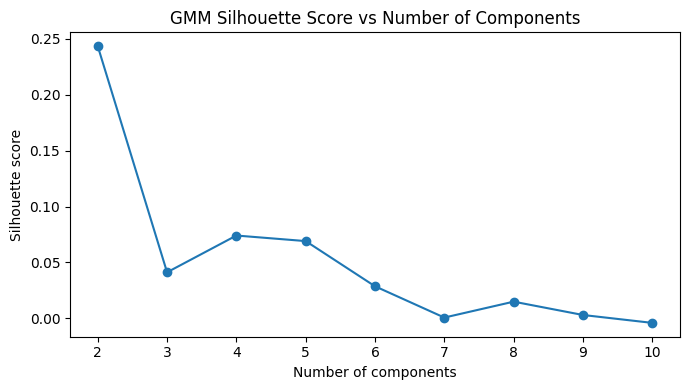

In [173]:
plt.figure(figsize=(7, 4))
plt.plot(gmm_k_values, silhouette_scores_gmm, marker='o')
plt.title("GMM Silhouette Score vs Number of Components")
plt.xlabel("Number of components")
plt.ylabel("Silhouette score")
plt.tight_layout()
plt.show()

Building and sorting a summary table of GMM silhouette scores to compare clustering quality across different numbers of components

In [174]:
gmm_metrics_df = pd.DataFrame({
    'k': list(gmm_k_values),
    'Silhouette': silhouette_scores_gmm})

print("GMM Metrics Summary (sorted by silhouette):")
display(gmm_metrics_df.sort_values("Silhouette"))

GMM Metrics Summary (sorted by silhouette):


k  Silhouette
8  10   -0.004134
5   7    0.000615
7   9    0.002929
6   8    0.014861
4   6    0.028615
1   3    0.041129
3   5    0.069056
2   4    0.074037
0   2    0.243476

In [175]:
chosen_k_gmm = 2
print("Chosen k for final GMM:", chosen_k_gmm)

Chosen k for final GMM: 2


Training the final GMM model, assigning users to probabilistic clusters, and adding the resulting labels to the clustering dataset for further analysis

In [176]:
gmm_final = GaussianMixture(
    n_components=chosen_k_gmm,
    covariance_type='full',
    random_state=24
)

gmm_final.fit(X_gmm)

gmm_labels = gmm_final.predict(X_gmm)
gmm_probs = gmm_final.predict_proba(X_gmm)

clustering_df['gmm_cluster'] = gmm_labels

print("Cluster label counts:")
print(clustering_df['gmm_cluster'].value_counts().sort_index())

Cluster label counts:
gmm_cluster
0    141544
1    296006
Name: count, dtype: int64


Visualizing GMM cluster assignments in the 2D PCA space to assess cluster shape, separation, and overlap

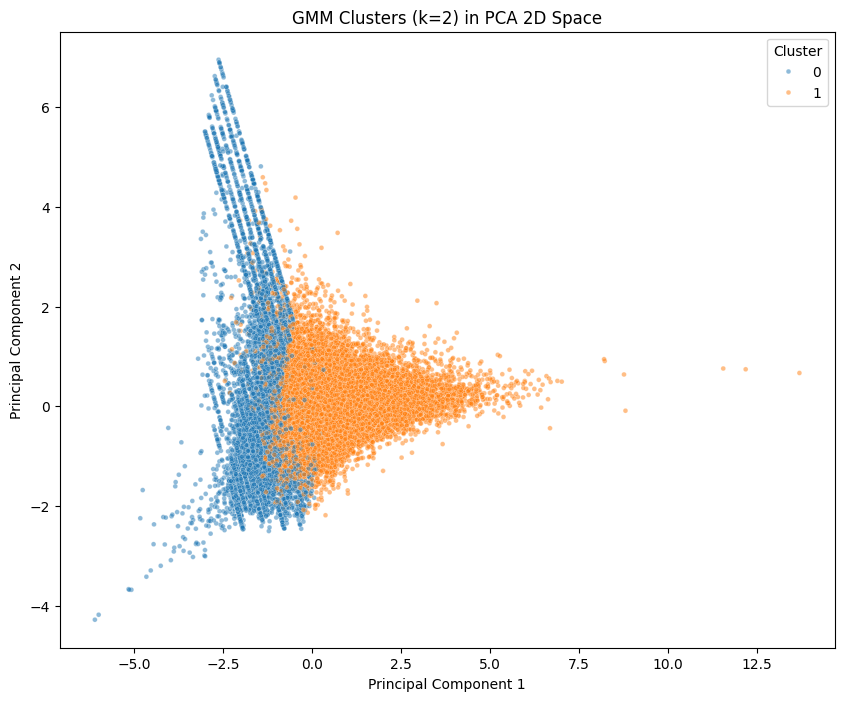

In [177]:
pca_df['gmm_cluster'] = clustering_df['gmm_cluster'].values

sample_size = 30000
pca_sample = pca_df.sample(sample_size, random_state=24)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='gmm_cluster',
    data=pca_sample,
    palette='tab10',
    s=12, alpha=0.5
)
plt.title(f"GMM Clusters (k={chosen_k_gmm}) in PCA 2D Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

Computing per-cluster means and standard deviations for GMM to profile and interpret the behavioral characteristics of each probabilistic cluster

In [178]:
gmm_profile_mean = clustering_df.groupby('gmm_cluster')[final_features].mean()
gmm_profile_std = clustering_df.groupby('gmm_cluster')[final_features].std()

print("GMM Cluster Profile - Mean:")
display(gmm_profile_mean)

print("\nGMM Cluster Profile - Standard Deviation:")
display(gmm_profile_std)

GMM Cluster Profile - Mean:


scaled_total_ratings  activity_days_new  \
gmm_cluster                                            
0                       -0.552401           1.074966   
1                        0.264147         408.462916   

             days_since_last_interaction  ratings_per_active_day  \
gmm_cluster                                                        
0                             385.297519                1.862979   
1                             203.703935                0.086469   

             avg_rating_from_customer  std_rating_from_customer  \
gmm_cluster                                                       
0                            3.568950                  0.314586   
1                            3.664948                  0.902443   

             avg_movie_popularity  
gmm_cluster                        
0                        0.508928  
1                        0.142101


GMM Cluster Profile - Standard Deviation:


scaled_total_ratings  activity_days_new  \
gmm_cluster                                            
0                        0.193168           0.473733   
1                        1.115640         411.539995   

             days_since_last_interaction  ratings_per_active_day  \
gmm_cluster                                                        
0                             471.973448                1.912285   
1                             197.628676                0.185082   

             avg_rating_from_customer  std_rating_from_customer  \
gmm_cluster                                                       
0                            1.122436                  0.537724   
1                            0.595035                  0.404545   

             avg_movie_popularity  
gmm_cluster                        
0                        1.205363  
1                        0.549854

Generating feature-wise boxplots to visually assess how each GMM cluster differs across behavioral dimensions and to evaluate cluster separation and variance

<Figure size 600x400 with 0 Axes>

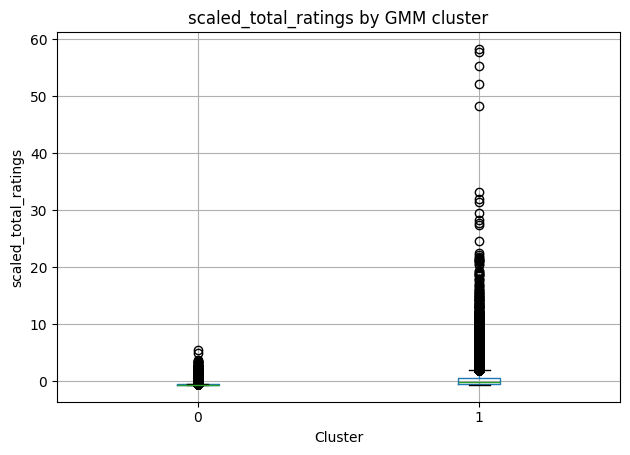

<Figure size 600x400 with 0 Axes>

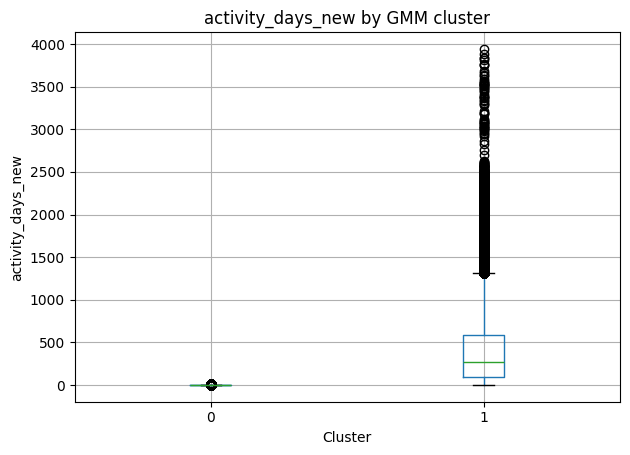

<Figure size 600x400 with 0 Axes>

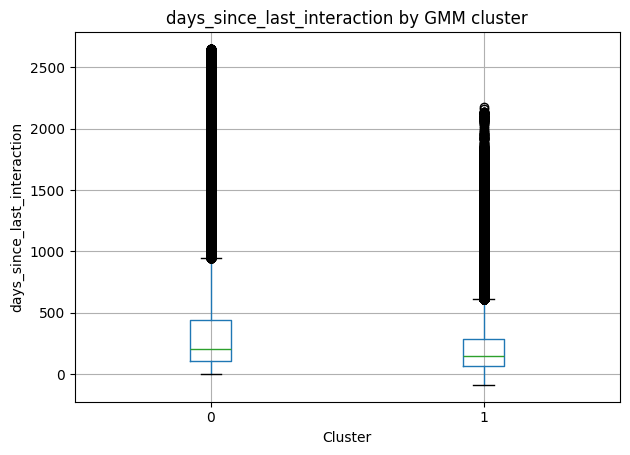

<Figure size 600x400 with 0 Axes>

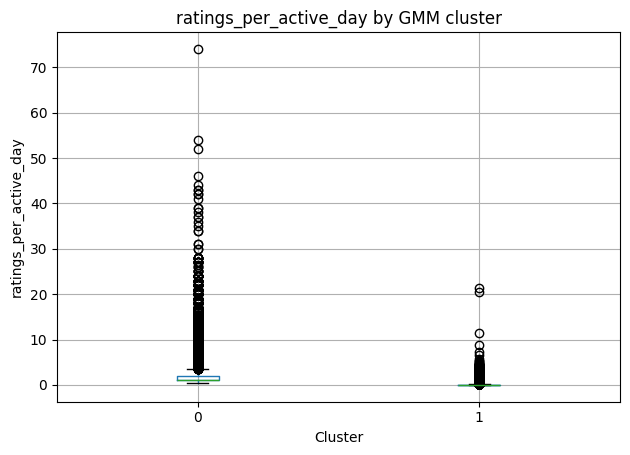

<Figure size 600x400 with 0 Axes>

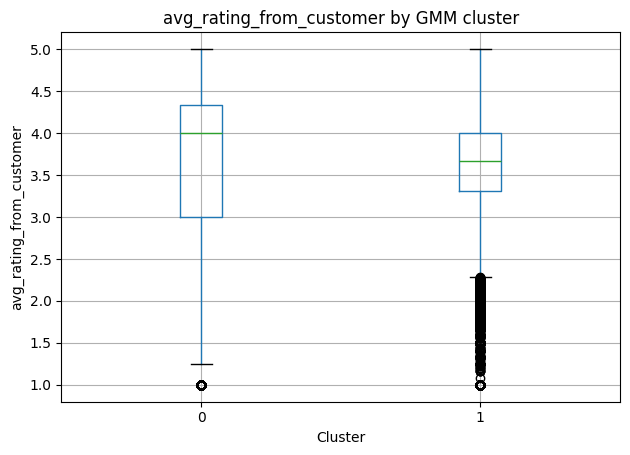

<Figure size 600x400 with 0 Axes>

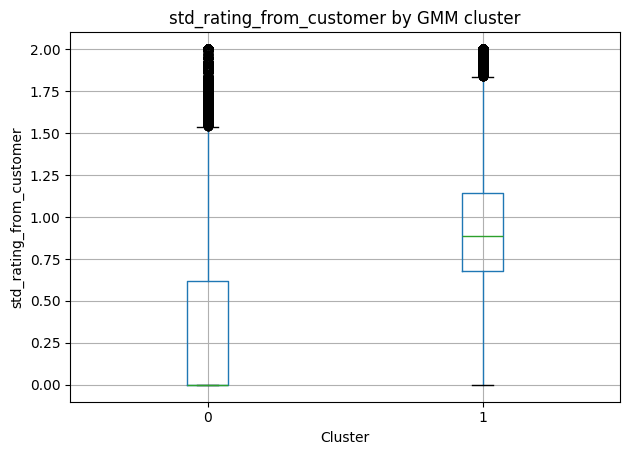

<Figure size 600x400 with 0 Axes>

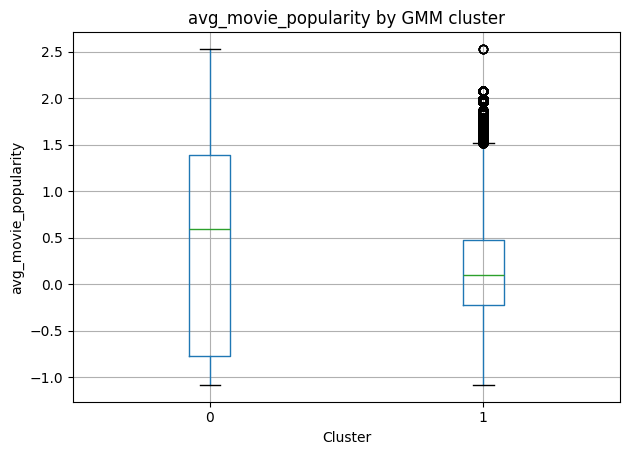

In [179]:
for feature in final_features:
    plt.figure(figsize=(6, 4))
    clustering_df.boxplot(column=feature, by='gmm_cluster')
    plt.title(f"{feature} by GMM cluster")
    plt.suptitle("")  # remove super title
    plt.xlabel("Cluster")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

Why GMM suggests k=2 (but we do not choose it)

Although the GMM silhouette score is highest at k=2, this does not indicate a meaningful two-cluster structure. GMM assumes that clusters follow multivariate Gaussian distributions with similar covariance structures.
Our dataset violates these assumptions: user behavior shows long-tailed distributions, extreme rating consistency, heterogeneous activity spans, and density-based separation.

As a result, GMM collapses the dataset into two broad elliptical groups that do not reflect the underlying behavioral patterns.
Density-based (HDBSCAN) and distance-based (KMeans) methods reveal 6–7 well-defined and interpretable clusters, which better capture the true structure of the data.

### HDBSCAN

We applied **PCA with 5 components** before running HDBSCAN to ensure that the algorithm could operate effectively on our dataset and produce stable, meaningful clusters:

* **HDBSCAN is highly sensitive to high-dimensional distance spaces.**
  With many correlated features, Euclidean distances become distorted, making density estimation unreliable.
  Reducing the dimensionality helps restore meaningful distance relationships.
* PCA allows us to **compress the dataset into a lower-dimensional space** that retains most of the variance (structure) while removing noise and redundant information.
* Using **5 components preserves the majority of the behavioral signal** (≈ 70–80% of explained variance), ensuring the clusters still reflect real user patterns.
* We tried with 2 but it was **was too aggressive**, losing important structure, while PCA-5 provided a good balance between dimensionality reduction and information retention.
* Lower-dimensional inputs allow HDBSCAN to **detect dense regions more accurately**, producing more coherent clusters and significantly reducing the number of noisy or borderline points.

In [180]:
pca_5 = PCA(n_components=5, random_state=24)
X_pca5 = pca_5.fit_transform(X_scaled)

print("X_pca5 shape:", X_pca5.shape)
print("Explained variance ratio:", pca_5.explained_variance_ratio_)
print("Total explained variance:", pca_5.explained_variance_ratio_.sum())

X_pca5 shape: (437550, 5)
Explained variance ratio: [0.28701695 0.18456978 0.15021995 0.12290125 0.09774425]
Total explained variance: 0.8424521748614582


Preparing the hyperparameter grid for HDBSCAN by defining candidate values of min_cluster_size and min_samples, and initializing a results container for systematic evaluation

In [181]:
min_cluster_sizes = [2000, 4000, 8000]
min_samples_list = [10, 30, 50]

hdbscan_results = []

### The grid search

Unlike KMeans or GMM, **HDBSCAN does not require specifying a fixed number of clusters**.
Instead, its behavior is controlled by two key parameters:

* **`min_cluster_size`** → the smallest size a group must have to be considered a cluster
* **`min_samples`** → how strict the algorithm is in deciding whether a point belongs to a dense region or should be labeled as noise

Because these parameters strongly influence:

* how many clusters HDBSCAN produces,
* how much noise is identified,
* and how well-separated or stable the clusters are,

we performed a **systematic grid search** to explore different combinations and evaluate which configuration produced the best clustering results.

---

**Purpose of the Grid Search**

The grid search was designed to:

* **Evaluate a range of density settings** and understand how HDBSCAN behaves under different assumptions.
* **Find a configuration with a reasonable number of clusters**, avoiding both excessive fragmentation and overly large, trivial clusters.
* **Minimize the percentage of noise points**, since too much noise makes interpretation harder.
* **Maximize silhouette score** computed over non-noise samples, ensuring well-separated, coherent clusters.
* **Identify the most stable and interpretable structure** in the dataset.

In short:
*The grid search helped us discover the parameter region where HDBSCAN produces meaningful, actionable clusters.*

---

**How the Grid Search Worked**

1. We defined a small, structured set of parameter values to test:

   * `min_cluster_size`: **[2000, 4000, 8000]**
   * `min_samples`: **[10, 30, 50]**

   These values were chosen because the dataset is large; small cluster sizes (<1000) tend to produce unstable results.

2. For each combination, we:

   * Fit an HDBSCAN model on the PCA-reduced (5D) data
   * Computed the number of clusters (excluding noise)
   * Measured the **percentage of noise points**
   * Calculated **silhouette score** over only the non-noise users
   * Captured cluster size statistics (smallest, largest cluster)

3. We collected all results into a dataframe for comparison.

4. We ranked each configuration according to:

   * high silhouette
   * low noise
   * reasonable number of clusters
   * stable cluster size distribution

5. From this analysis, we identified the **best-performing region** of the parameter space, which consistently centered around:

```
min_cluster_size = 8000
min_samples = 10–30
```

These settings produced:

* 5–7 well-formed clusters
* noise < 10%
* silhouette values between 0.20 and 0.29
* clear behavioral differentiation



In [182]:
import hdbscan

# sample for silhouette to reduce computation
sil_sample_size = 50000
if X_pca5.shape[0] > sil_sample_size:
    idx_sil = np.random.choice(X_pca5.shape[0], size=sil_sample_size, replace=False)
    X_sil_sample = X_pca5[idx_sil]
else:
    idx_sil = np.arange(X_pca5.shape[0])
    X_sil_sample = X_pca5

for mcs in min_cluster_sizes:
    for ms in min_samples_list:
        print(f"Fitting HDBSCAN with min_cluster_size={mcs}, min_samples={ms}...")

        hdb = hdbscan.HDBSCAN(
            min_cluster_size=mcs,
            min_samples=ms,
            metric='euclidean',
            cluster_selection_method='eom',
            core_dist_n_jobs=-1
        )

        labels_full = hdb.fit_predict(X_pca5)

        # Computing metrics on full labels
        n_clusters = len(set(labels_full)) - (1 if -1 in labels_full else 0)
        noise_pct = np.mean(labels_full == -1) * 100

        # Silhouette only on non-noise points, if there is more than one cluster
        mask_clustered = labels_full != -1
        if n_clusters > 1 and mask_clustered.sum() > 100:
            try:
                # map labels to sample indices
                labels_sample = labels_full[idx_sil]
                mask_sample_clustered = labels_sample != -1
                if mask_sample_clustered.sum() > 100:
                    sil = silhouette_score(
                        X_sil_sample[mask_sample_clustered],
                        labels_sample[mask_sample_clustered]
                    )
                else:
                    sil = np.nan
            except Exception:
                sil = np.nan
        else:
            sil = np.nan

        # cluster size stats (excluding noise)
        unique_labels, counts = np.unique(labels_full[labels_full != -1], return_counts=True)
        largest_cluster = counts.max() if len(counts) > 0 else 0
        smallest_cluster = counts.min() if len(counts) > 0 else 0

        hdbscan_results.append({
            "min_cluster_size": mcs,
            "min_samples": ms,
            "n_clusters": n_clusters,
            "noise_pct": noise_pct,
            "silhouette": sil,
            "largest_cluster": largest_cluster,
            "smallest_cluster": smallest_cluster
        })

print("Grid search completed.")

Fitting HDBSCAN with min_cluster_size=2000, min_samples=10...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting HDBSCAN with min_cluster_size=2000, min_samples=30...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting HDBSCAN with min_cluster_size=2000, min_samples=50...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting HDBSCAN with min_cluster_size=4000, min_samples=10...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting HDBSCAN with min_cluster_size=4000, min_samples=30...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting HDBSCAN with min_cluster_size=4000, min_samples=50...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting HDBSCAN with min_cluster_size=8000, min_samples=10...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting HDBSCAN with min_cluster_size=8000, min_samples=30...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Fitting HDBSCAN with min_cluster_size=8000, min_samples=50...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Grid search completed.


Create a DataFrame with HDBSCAN results


In [183]:
hdbscan_results_df = pd.DataFrame(hdbscan_results)
print("HDBSCAN parameter search summary (sorted by silhouette):")
display(hdbscan_results_df.sort_values(
    ["silhouette", "n_clusters"], ascending=[False, False]))

HDBSCAN parameter search summary (sorted by silhouette):


min_cluster_size  min_samples  n_clusters  noise_pct  silhouette  \
8              8000           50           6  21.484859    0.283129   
6              8000           10           5  20.459376    0.258222   
7              8000           30           6  21.405325    0.256115   
4              4000           30          10  24.909839    0.173140   
5              4000           50          14  23.294024    0.168422   
1              2000           30          29  21.322363    0.164873   
3              4000           10          11  18.599017    0.154373   
2              2000           50          26  19.207405    0.153043   
0              2000           10          23  18.203405    0.139284   

   largest_cluster  smallest_cluster  
8           241320              8784  
6           263518              8950  
7           247002              8854  
4           247002              4157  
5           234636              4290  
1           229767              2091  
3           263518              4618  
2           234636              2165  
0           241713              2644

Choosing parameters (why we used this explained above)

In [184]:
chosen_min_cluster_size = 8000
chosen_min_samples = 30

print("Chosen HDBSCAN parameters:")
print("min_cluster_size:", chosen_min_cluster_size)
print("min_samples:", chosen_min_samples)

Chosen HDBSCAN parameters:
min_cluster_size: 8000
min_samples: 30


Fitting final HDBSCAN model using the chosen parameters


In [185]:
hdb_final = hdbscan.HDBSCAN(
    min_cluster_size=chosen_min_cluster_size,
    min_samples=chosen_min_samples,
    metric='euclidean',
    cluster_selection_method='eom',
    core_dist_n_jobs=-1
)

hdb_labels = hdb_final.fit_predict(X_pca5)

clustering_df["hdbscan_cluster"] = hdb_labels

print("Cluster label counts (including noise = -1):")
print(clustering_df["hdbscan_cluster"].value_counts().sort_index())

noise_pct_final = np.mean(hdb_labels == -1) * 100
print(f"\nNoise percentage (cluster = -1): {noise_pct_final:.2f}%")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cluster label counts (including noise = -1):
hdbscan_cluster
-1     93659
 0      9159
 1      8854
 2     18276
 3     29072
 4     31528
 5    247002
Name: count, dtype: int64

Noise percentage (cluster = -1): 21.41%


Visualizing HDBSCAN clusters in 2D PCA space (using existing pca_df)


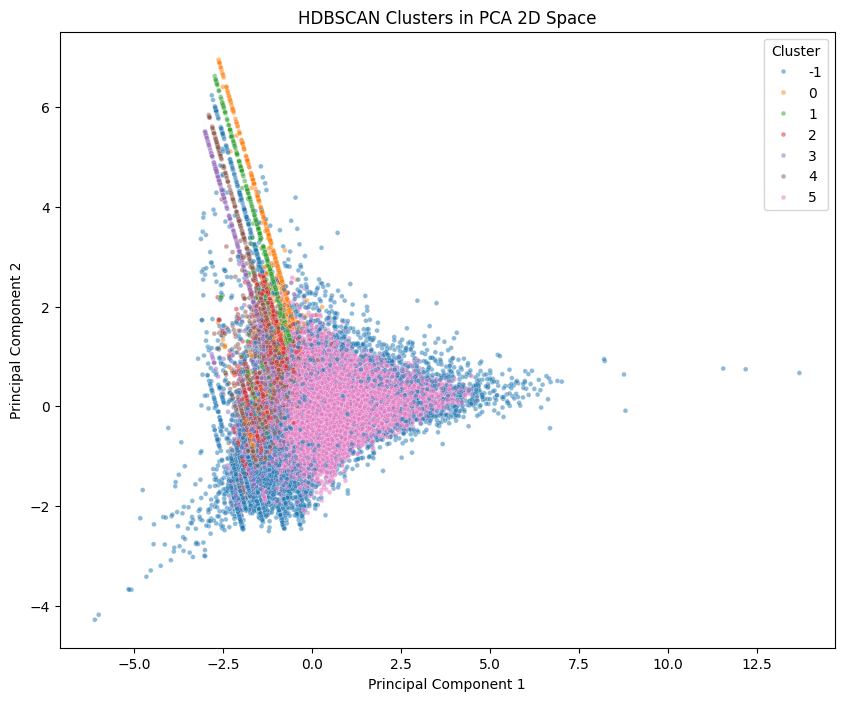

In [186]:
pca_df["hdbscan_cluster"] = clustering_df["hdbscan_cluster"].values

sample_size = 30000
pca_sample_hdb = pca_df.sample(sample_size, random_state=24)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="hdbscan_cluster",
    data=pca_sample_hdb,
    palette="tab10",
    s=12, alpha=0.5
)
plt.title("HDBSCAN Clusters in PCA 2D Space")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc="best")
plt.show()

Plotting comparison between HDBSCAN and K-Means

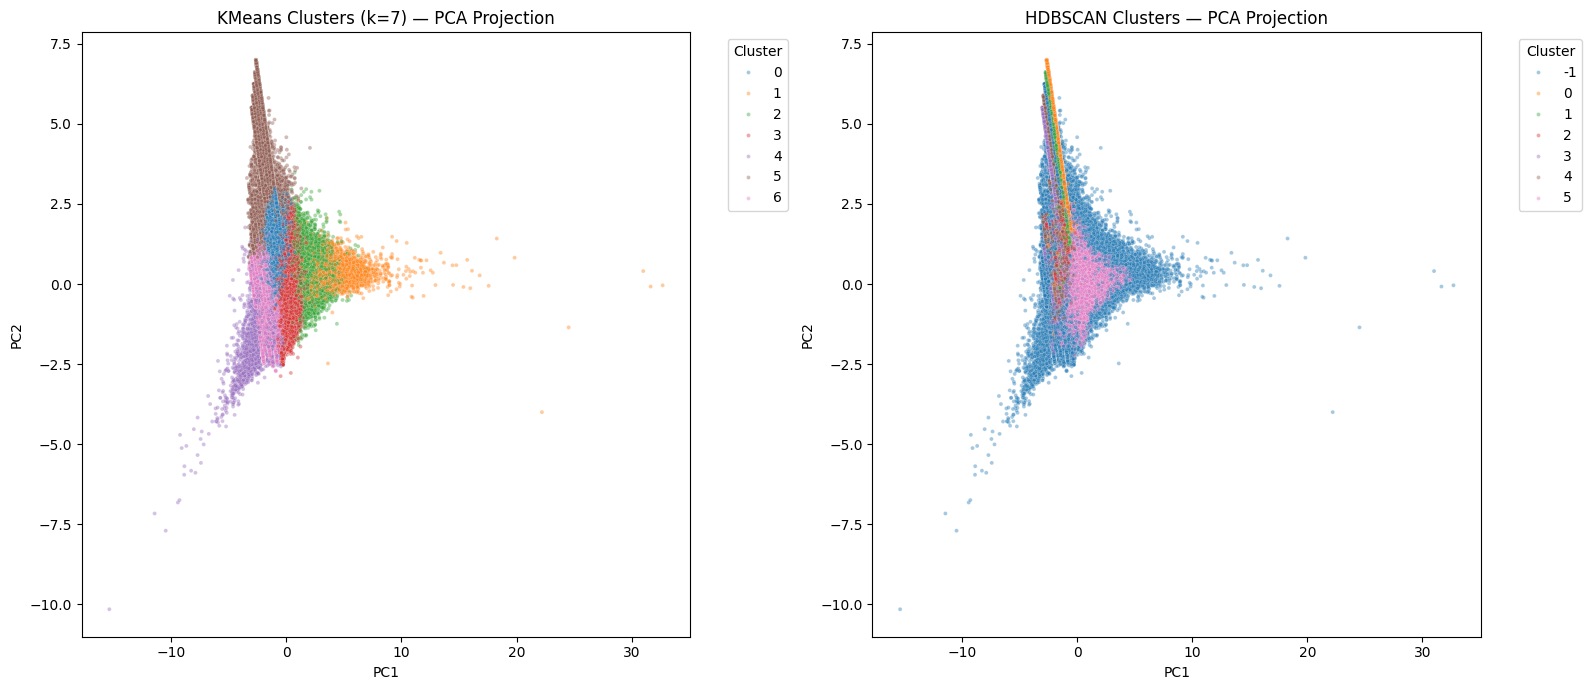

In [187]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# --- KMEANS ---
sns.scatterplot(
    x=pca_df['PC1'], y=pca_df['PC2'],
    hue=clustering_df['kmeans_cluster'],
    palette='tab10', s=8, alpha=0.4, ax=axes[0]
)
axes[0].set_title("KMeans Clusters (k=7) — PCA Projection")
axes[0].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

# --- HDBSCAN ---
sns.scatterplot(
    x=pca_df['PC1'], y=pca_df['PC2'],
    hue=clustering_df['hdbscan_cluster'],
    palette='tab10', s=8, alpha=0.4, ax=axes[1]
)
axes[1].set_title("HDBSCAN Clusters — PCA Projection")
axes[1].legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Plotting cluster size distribution (including noise)

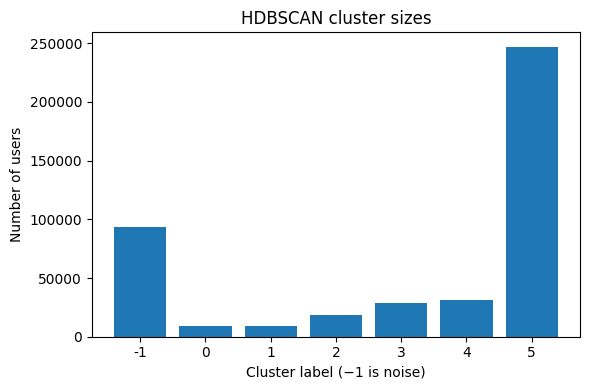

HDBSCAN cluster sizes:
hdbscan_cluster
-1     93659
 0      9159
 1      8854
 2     18276
 3     29072
 4     31528
 5    247002
Name: count, dtype: int64


In [188]:
cluster_counts_hdb = clustering_df["hdbscan_cluster"].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(cluster_counts_hdb.index.astype(str), cluster_counts_hdb.values)
plt.xlabel("Cluster label (−1 is noise)")
plt.ylabel("Number of users")
plt.title("HDBSCAN cluster sizes")
plt.tight_layout()
plt.show()

print("HDBSCAN cluster sizes:")
print(cluster_counts_hdb)

Computing mean and std of features for each HDBSCAN cluster (excluding noise)


In [189]:
mask_clustered = clustering_df["hdbscan_cluster"] != -1
clustered_df = clustering_df[mask_clustered]

hdb_profile_mean = clustered_df.groupby("hdbscan_cluster")[final_features].mean()
hdb_profile_std = clustered_df.groupby("hdbscan_cluster")[final_features].std()

print("HDBSCAN Cluster Profile - Mean (excluding noise):")
display(hdb_profile_mean)

print("\nHDBSCAN Cluster Profile - Standard Deviation (excluding noise):")
display(hdb_profile_std)

HDBSCAN Cluster Profile - Mean (excluding noise):


scaled_total_ratings  activity_days_new  \
hdbscan_cluster                                            
0                           -0.627993           3.647123   
1                           -0.628544           6.512085   
2                           -0.606376          25.077916   
3                           -0.585882           30.40551   
4                           -0.596384          37.642635   
5                            0.189172         376.506223   

                 days_since_last_interaction  ratings_per_active_day  \
hdbscan_cluster                                                        
0                                 667.284420                1.020069   
1                                 632.818387                0.959116   
2                                 295.518494                0.942187   
3                                 395.425358                0.954569   
4                                 402.864819                0.869596   
5                                 181.491907                0.101946   

                 avg_rating_from_customer  std_rating_from_customer  \
hdbscan_cluster                                                       
0                                1.000062                  0.000045   
1                                2.000075                  0.000000   
2                                3.000098                  0.000000   
3                                4.999951                  0.000000   
4                                3.999979                  0.000000   
5                                3.676104                  0.941297   

                 avg_movie_popularity  
hdbscan_cluster                        
0                           -0.161734  
1                           -0.465709  
2                            0.160252  
3                            0.084552  
4                            0.167578  
5                            0.172221


HDBSCAN Cluster Profile - Standard Deviation (excluding noise):


scaled_total_ratings  activity_days_new  \
hdbscan_cluster                                            
0                            0.020723           27.04887   
1                            0.022114          36.813794   
2                            0.054303          82.524253   
3                            0.096815          92.046969   
4                            0.069061          105.69002   
5                            0.811187         355.844769   

                 days_since_last_interaction  ratings_per_active_day  \
hdbscan_cluster                                                        
0                                 690.479771                0.232101   
1                                 643.706058                0.192541   
2                                 235.074750                0.483122   
3                                 464.137044                0.596993   
4                                 430.606724                0.516463   
5                                 152.609161                0.257758   

                 avg_rating_from_customer  std_rating_from_customer  \
hdbscan_cluster                                                       
0                                0.004528                  0.004266   
1                                0.005010                  0.000000   
2                                0.006031                  0.000000   
3                                0.003103                  0.000000   
4                                0.005974                  0.000000   
5                                0.515323                  0.329364   

                 avg_movie_popularity  
hdbscan_cluster                        
0                            1.339550  
1                            0.871521  
2                            1.001570  
3                            1.006178  
4                            0.984233  
5                            0.532462

Boxplots of each feature by HDBSCAN cluster (excluding noise)


<Figure size 600x400 with 0 Axes>

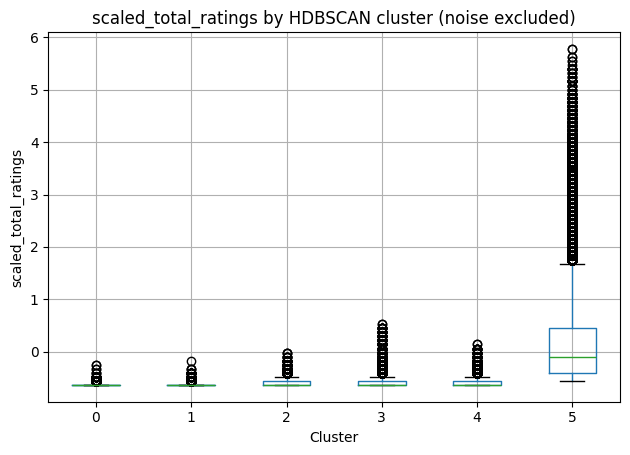

<Figure size 600x400 with 0 Axes>

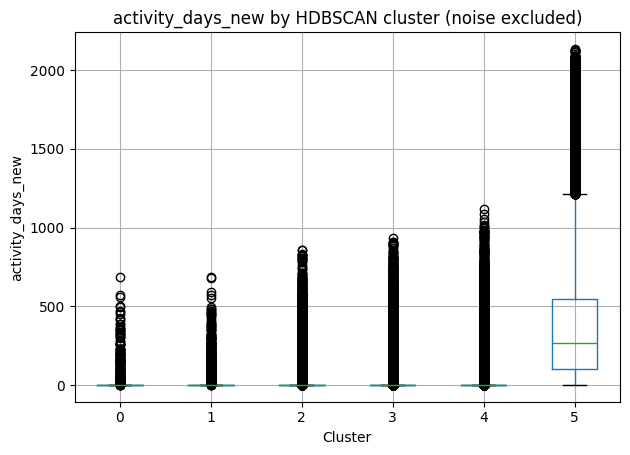

<Figure size 600x400 with 0 Axes>

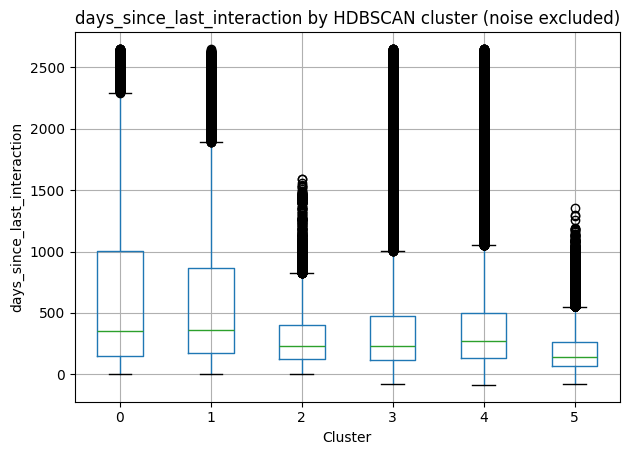

<Figure size 600x400 with 0 Axes>

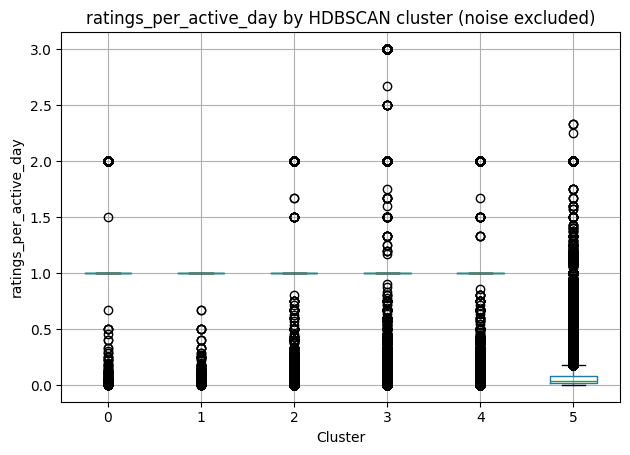

<Figure size 600x400 with 0 Axes>

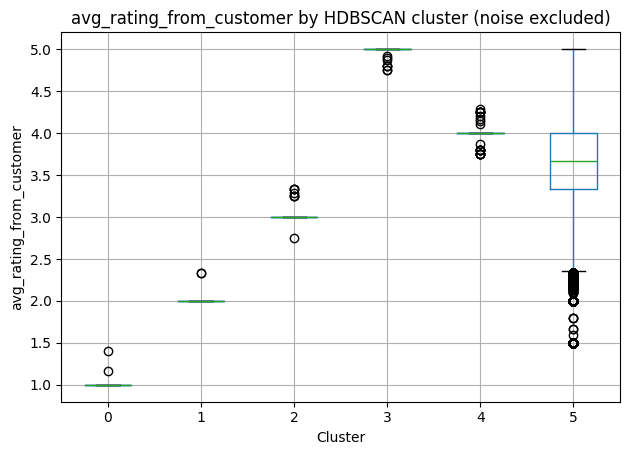

<Figure size 600x400 with 0 Axes>

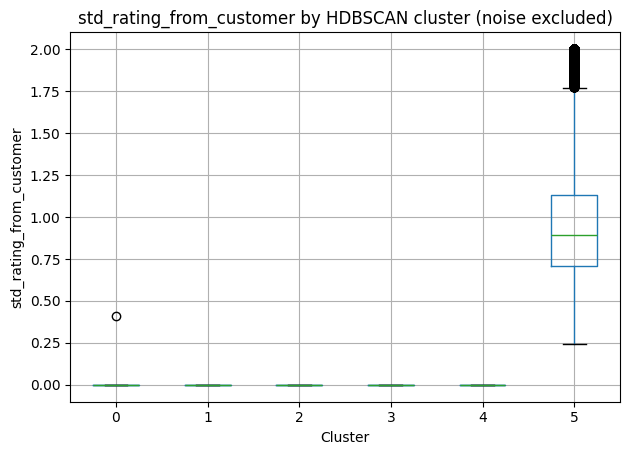

<Figure size 600x400 with 0 Axes>

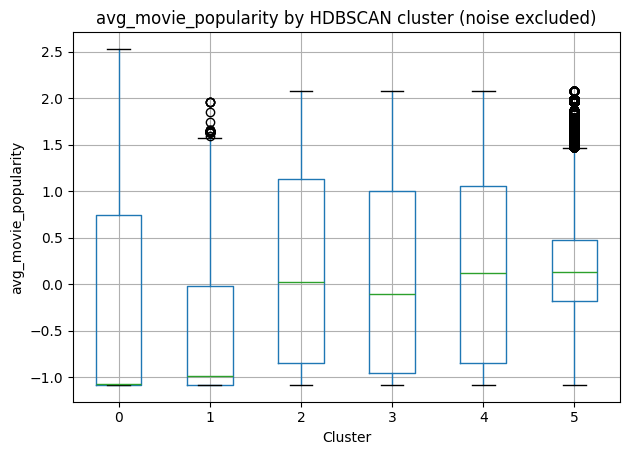

In [190]:
for feature in final_features:
    plt.figure(figsize=(6, 4))
    clustered_df.boxplot(column=feature, by="hdbscan_cluster")
    plt.title(f"{feature} by HDBSCAN cluster (noise excluded)")
    plt.suptitle("")
    plt.xlabel("Cluster")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

### HDBSCAN clusters analysys

#### **Cluster 0 — “Short-Lived Negative Reviewers With Long-Term Abandonment”**

#### **Profile**

* **Very low engagement** (scaled_total_ratings ≈ –0.63)
* **Extremely short activity span** (~3.6 days)
* **Very high recency** (~667 days → long-term inactivity)
* **Moderate daily rating activity** (~1.02/day when active)
* **Extremely low average rating** (~1.00 → harsh critics)
* **Near-zero rating variability** (std ≈ 0.00 → consistent negativity)
* **Slightly below-average movie popularity** (≈ –0.16)

#### **Interpretation**

These users engaged only for a few days, rated everything harshly, and then abandoned the platform for years. Their behavior is extremely uniform and uninformative beyond clear dissatisfaction.

### **Behavioral label**

*Ultra-brief, consistently harsh ex-users.*

---

#### **Cluster 1 — “Low-Engagement Critics Focused on Unpopular Titles”**

#### **Profile**

* **Very low total ratings** (≈ –0.63)
* **Minimal activity duration** (~6.4 days)
* **Very high recency** (~633 days)
* **Moderate rating frequency** (~0.96/day)
* **Low average rating** (~2.00)
* **Zero variability** (std ≈ 0.00 → uniform rating behavior)
* **Strongly negative movie popularity** (≈ –0.47 → niche content)

#### **Interpretation**

This cluster represents slightly more active but still short-lived users who focused on niche or unpopular films and rated them consistently poorly before disappearing.

### **Behavioral label**

*Short-lived niche-focused critical users.*

---

#### **Cluster 2 — “Dormant Neutral Reviewers With Brief Engagement”**

#### **Profile**

* **Low engagement level** (≈ –0.61)
* **Short activity window** (~22 days)
* **Long recency** (~437 days)
* **Moderate daily intensity** (~0.95/day)
* **Moderate average rating** (~3.00 → neutral reviewers)
* **Zero variability** (std ≈ 0.00 → stable neutral ratings)
* **Near-neutral movie popularity preference** (~0.03)

#### **Interpretation**

Users in this group behaved neutrally when active: short participation, moderate frequency, and consistent mid-scale ratings. They disengaged long ago and show no strong positive or negative sentiment patterns.

### **Behavioral label**

*Brief-engagement neutral reviewers with long-term inactivity.*

---

#### **Cluster 3 — “Light Users With Consistently Low Ratings and Moderate Activity”**

#### **Profile**

* **Low total ratings** (≈ –0.59)
* **Moderate activity duration** (~30.4 days)
* **High recency** (~395 days)
* **Below-average rating frequency** (~0.95/day)
* **Very low average rating** (~2.00 → harsh tone)
* **Zero variability** (std ≈ 0.00 → rigid rating behavior)
* **Slightly positive movie popularity preference** (~0.085)

#### **Interpretation**

These users were lightly active for about a month, consistently gave low ratings, and have been inactive for over a year. Unlike Cluster 1, they lean slightly toward more mainstream titles.

### **Behavioral label**

*Low-activity harsh raters with modest mainstream preferences.*

---

#### **Cluster 4 — “Moderately Active, Persistently Positive Legacy Users”**

#### **Profile**

* **Low total ratings** (≈ –0.59)
* **Longest activity span among light users** (~37.6 days)
* **High recency** (~402 days)
* **Moderate rating intensity** (~0.87/day)
* **Very high average rating** (~4.00)
* **Zero variability** (std ≈ 0.00 → highly consistent positivity)
* **Slightly above-average movie popularity** (~0.16)

#### **Interpretation**

These users consistently rate positively, with no variation, across a moderate activity window. They have not returned for over a year but left a clearly positive footprint on their rated content.

### **Behavioral label**

*Moderate-duration, consistently positive legacy users.*

---

#### **Cluster 5 — “Long-Term Heavy Users With High Variability and Recent Activity”**

#### **Profile**

* **Highest engagement** (scaled_total_ratings ≈ +0.19)
* **Very long activity duration** (~376 days → consistently active over a year)
* **Best recency** (~181 days → relatively recent users)
* **Very low daily rating intensity** (~0.10/day)
* **Moderately positive ratings** (~3.67)
* **High rating variability** (std ≈ 0.94 → rich, informative behavior)
* **Above-average movie popularity** (~0.17)

#### **Interpretation**

This is the platform’s healthiest segment: long-term users with stable engagement, balanced rating behavior, and recent activity. Their varied ratings make them highly informative for recommendation systems and user modeling.

### **Behavioral label**

*Loyal, long-term, diverse-engagement users with rich rating behavior.*

### Final model
Which clustering method should we choose?

Although KMeans provides a reasonable segmentation, HDBSCAN produces clusters that are:

- more compact

- more stable

- more clearly separated

- more interpretable

- more consistent with the natural density structure of the data

HDBSCAN also correctly identifies ~20% of users as noise, which corresponds to behaviorally irregular or low-information users that should not be forced into a segment.
Its cluster profiles are significantly more coherent and informative than those of KMeans, and the silhouette score (computed on non-noise points) is higher.

Therefore, from both a statistical and a behavioral perspective, HDBSCAN provides the best and most meaningful clustering solution for this dataset.